In [ ]:
from __future__ import annotations

import json
import math
import os
import random
import re
import sys
import time
import threading
import gc
import pickle
from pathlib import Path
from dataclasses import dataclass
from datetime import datetime
from collections import Counter, defaultdict
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.sparse as sp
from scipy import sparse
from scipy.stats import spearmanr
from scipy.spatial import ConvexHull

from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

import joblib

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(x, **kwargs):
        return x

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

try:
    import psutil
except Exception:
    psutil = None

try:
    import pynvml
    _NVML_AVAILABLE = True
except Exception:
    pynvml = None
    _NVML_AVAILABLE = False

In [1]:
WIKI_TXT   = Path("AllCombined.txt")
HEAD_CSV   = Path("abcnews-date-text.csv")
OUT_TXT    = Path("merged_raw.txt")


wiki_lines = []
with WIKI_TXT.open("r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        s = line.strip()
        if s:

            wiki_lines.append(s.replace("\r", " ").replace("\n", " "))

df = pd.read_csv(HEAD_CSV, encoding="utf-8", dtype=str)

if "headline_text" in df.columns:
    heads = df["headline_text"].astype(str)
else:

    if df.shape[1] < 2:
        raise ValueError("CSV must have at least two columns; couldn't find 'headline_text' or a second column.")
    heads = df.iloc[:, 1].astype(str)

head_lines = (
    heads.fillna("")
         .map(lambda x: x.replace("\r", " ").replace("\n", " ").strip())
)
head_lines = [s for s in head_lines if s]

all_lines = wiki_lines + head_lines

OUT_TXT.write_text("\n".join(all_lines), encoding="utf-8")


229716228

In [2]:
INPUT_FILE  = Path("merged_raw.txt")
OUTPUT_FILE = Path("merged_cleaned.txt")

REMOVE_STANDALONE_NUMBERS = False

ROMAN_NUMERALS = ("i","ii","iii","iv","v","vi","vii","viii","ix","x")
NAMEISH_LEADS  = {
    "king","queen","prince","princess","duke","duchess","earl","count","countess",
    "marquis","marchioness","baron","baroness","lord","lady","saint","sir","pope",
    "emperor","empress","tsar","czar","kaiser","sultan",
    "charles","henry","edward","george","james","william","louis","philip","alexander",
    "nicholas","john","richard","peter","ferdinand","alfonso"
}

ROMAN_KEEP_BIGRAMS = {
    ("world","war"), ("super","bowl"), ("final","fantasy"), ("chapter","ii"),
    ("act","ii"), ("scene","ii"), ("part","ii")
}


def read_text(path: Path) -> str:
    txt = path.read_text(encoding="utf-8", errors="ignore")
    before = len(txt)
    print(f"[read] characters: {before:,}")
    return txt


def normalize_unicode_lower(txt: str) -> str:

    txt = unicodedata.normalize("NFKC", txt)
    txt = txt.replace("’", "'").replace("‘", "'").replace("“", '"').replace("”", '"')
    txt = txt.replace("–", "-").replace("—", "-")
    txt = txt.lower()
    return txt


def remove_brackets_and_contents(txt: str) -> str:

    patterns = [r"\([^()]*\)", r"\[[^\[\]]*\]", r"\{[^{}]*\}"]
    changed = True
    while changed:
        changed = False
        for pat in patterns:
            new_txt = re.sub(pat, " ", txt)
            if new_txt != txt:
                changed = True
                txt = new_txt
    return txt


def remove_urls_emails_html(txt: str) -> str:

    txt = re.sub(r"\bhttps?://\S+\b", " ", txt)
    txt = re.sub(r"\bwww\.\S+\b", " ", txt)
    txt = re.sub(r"\b[a-z0-9.-]+\.(?:com|org|net|edu|gov|io|co|uk|de|fr|in|cn|ru|jp|au|ca|us)\S*\b", " ", txt)
    txt = re.sub(r"\b[a-z0-9._%+-]+@[a-z0-9.-]+\.[a-z]{2,}\b", " ", txt)
    txt = re.sub(r"<[^>]+>", " ", txt)
    return txt


def keep_only_sentence_punct_and_apostrophe(txt: str) -> str:

    txt = re.sub(r"(?<=\w)-(?=\w)", "##HYPHEN##", txt)
    txt = re.sub(r"\.\s*\.\s*\.", ".", txt)
    txt = txt.replace("…", ".")
    txt = re.sub(r"[\",:;#%*@&$^+=\|/\\_~\[\]\{\}<>\u00A0\u2000-\u206F]", " ", txt)
    txt = txt.replace("-", " ")
    txt = txt.replace("##HYPHEN##", "-")
    return txt


def remove_wikipedia_titles(txt: str) -> str:

    lines = txt.splitlines()
    out_lines = []
    i = 0
    n = len(lines)
    while i < n:
        start = i
        while start < n and lines[start].strip() == "":
            out_lines.append("") 
            start += 1
        if start >= n:
            break

        end = start
        while end < n and lines[end].strip() != "":
            end += 1

        block = lines[start:end]


        drop_first = False
        if block:
            first = block[0].strip()
            if re.fullmatch(r"=+\s.*\s=+", first):
                drop_first = True

            elif len(first) <= 120 and not re.search(r"[\.?!]", first):

                drop_first = True

        if drop_first:
            block = block[1:]  

        out_lines.extend(block)

        if end < n:
            out_lines.append("")
        i = end

    return "\n".join(out_lines)


def remove_roman_suffixes_safely(txt: str) -> str:

    def process_line(line: str) -> str:
        tokens = line.split()
        if len(tokens) < 2:
            return line
        out = []
        k = 0
        while k < len(tokens):
            tok = tokens[k]
            if k+1 < len(tokens):
                nxt = tokens[k+1]
                if (tok.isalpha() and tok in NAMEISH_LEADS and nxt in ROMAN_NUMERALS):
                    out.append(tok)
                    k += 2
                    continue
                if (tok.isalpha() and nxt in ROMAN_NUMERALS):
                    prev_bigram = (tokens[k-1], tok) if k-1 >= 0 else ("","")
                    if prev_bigram not in ROMAN_KEEP_BIGRAMS and (tok not in {"war","bowl","fantasy","chapter","act","scene","part"}):
                        out.append(tok)
                        k += 1
                        continue
            out.append(tok)
            k += 1
        return " ".join(out)

    return "\n".join(process_line(ln) for ln in txt.splitlines())


def remove_meaningless_numbers(txt: str) -> str:
    
    txt = re.sub(r"(?<![\w-])\d+(?![\w-])", " ", txt)
    return txt


def tidy_whitespace(txt: str) -> str:

    txt = re.sub(r"[ \t]+", " ", txt)
    txt = re.sub(r" *\n *", "\n", txt)
    txt = re.sub(r"\n{3,}", "\n\n", txt)
    txt = txt.strip()
    return txt


def ensure_sentence_end_spacing(txt: str) -> str:

    txt = re.sub(r"([.?!])([a-z])", r"\1 \2", txt)
    return txt


def main():
    if not INPUT_FILE.exists():
        raise FileNotFoundError(f"Input not found: {INPUT_FILE.resolve()}")

    text = read_text(INPUT_FILE)

    text = normalize_unicode_lower(text)

    text = remove_brackets_and_contents(text)

    text = remove_urls_emails_html(text)

    text = keep_only_sentence_punct_and_apostrophe(text)

    text = remove_wikipedia_titles(text)

    text = remove_roman_suffixes_safely(text)

    if REMOVE_STANDALONE_NUMBERS:
        text = remove_meaningless_numbers(text)

    text = tidy_whitespace(text)
    text = ensure_sentence_end_spacing(text)

    after = len(text)
    OUTPUT_FILE.write_text(text, encoding="utf-8")
    print(f"[write] characters: {after:,}")
    print(f"[delta] change: {after - after:+,}")
    print(f"✅ Cleaned file saved → {OUTPUT_FILE.resolve()}")

    sample = [ln for ln in text.splitlines() if ln.strip()][:5]
    if sample:
        print("\n--- SAMPLE LINES ---")
        for i, ln in enumerate(sample, 1):
            print(f"{i:02d}. {ln[:120]}{'...' if len(ln)>120 else ''}")


if __name__ == "__main__":
    main()


[read] characters: 229,716,228
[write] characters: 58,915,594
[delta] change: +0
✅ Cleaned file saved → C:\Users\abdul\Merged_Cleaned.txt

--- SAMPLE LINES ---
01. april is the fourth month of the year in the julian and gregorian calendars and comes between march and may. it is one o...
02. april always begins on the same day of the week as july and additionally january in leap years. april always ends on the...
03. april comes between march and may making it the fourth month of the year. it also comes first in the year out of the fou...
04. april begins on the same day of the week as july every year and on the same day of the week as january in leap years. ap...
05. in common years april starts on the same day of the week as october of the previous year and in leap years may of the pr...


In [3]:
INPUT_FILE = Path("merged_cleaned.txt")
OUT_PICKLE = Path("tokenized_corpus.pkl")
OUT_TXT    = Path("tokenized_corpus.txt")

SENT_SPLIT_RE = re.compile(r'(?<=[.?!])\s+|\n+')

TOKEN_RE = re.compile(r"[a-z0-9]+(?:['-][a-z0-9]+)*")

def main():
    if not INPUT_FILE.exists():
        raise FileNotFoundError(f"Missing input: {INPUT_FILE.resolve()}")

    text = INPUT_FILE.read_text(encoding="utf-8", errors="ignore")

    sentences = [s.strip() for s in SENT_SPLIT_RE.split(text) if s.strip()]

    if len(sentences) == 1:
        words = text.split()
        CHUNK_SIZE = 100
        sentences = [" ".join(words[i:i+CHUNK_SIZE]) for i in range(0, len(words), CHUNK_SIZE)]

    tokenized = [TOKEN_RE.findall(s) for s in sentences]

    with OUT_PICKLE.open("wb") as f:
        pickle.dump(tokenized, f)

    with OUT_TXT.open("w", encoding="utf-8") as f:
        for toks in tokenized:
            f.write(" ".join(toks) + "\n")

    total_tokens = sum(len(t) for t in tokenized)
    print("✅ Tokenization complete")
    print(f"Sentences: {len(tokenized):,}")
    print(f"Total tokens: {total_tokens:,}")
    if tokenized:
        print("Sample:", tokenized[0][:20])

if __name__ == "__main__":
    main()


✅ Tokenization complete
Sentences: 1,323,403
Total tokens: 9,235,984
Sample: ['april', 'is', 'the', 'fourth', 'month', 'of', 'the', 'year', 'in', 'the', 'julian', 'and', 'gregorian', 'calendars', 'and', 'comes', 'between', 'march', 'and', 'may']


In [5]:
PKL_FILE = Path("tokenized_corpus.pkl")

with PKL_FILE.open("rb") as f:
    tokenized_corpus = pickle.load(f)

print(f"✅ Loaded tokenized corpus successfully!")
print(f"Total sentences: {len(tokenized_corpus):,}")

for i, sent in enumerate(tokenized_corpus[:5], 1):
    print(f"\nSentence {i}:")
    print(sent)

✅ Loaded tokenized corpus successfully!
Total sentences: 1,323,403

Sentence 1:
['april', 'is', 'the', 'fourth', 'month', 'of', 'the', 'year', 'in', 'the', 'julian', 'and', 'gregorian', 'calendars', 'and', 'comes', 'between', 'march', 'and', 'may']

Sentence 2:
['it', 'is', 'one', 'of', 'four', 'months', 'to', 'have', '30', 'days']

Sentence 3:
['april', 'always', 'begins', 'on', 'the', 'same', 'day', 'of', 'the', 'week', 'as', 'july', 'and', 'additionally', 'january', 'in', 'leap', 'years']

Sentence 4:
['april', 'always', 'ends', 'on', 'the', 'same', 'day', 'of', 'the', 'week', 'as', 'december']

Sentence 5:
['april', 'comes', 'between', 'march', 'and', 'may', 'making', 'it', 'the', 'fourth', 'month', 'of', 'the', 'year']


# Skip gram + Sub Sampling + HS

In [2]:
IN_PICKLE        = Path("tokenized_corpus.pkl"
OUT_DIR          = Path("skipgram_hs_artifacts(10_epochs_reduced_subsampling)"); OUT_DIR.mkdir(exist_ok=True)

EMBED_DIM        = 200
WINDOW_SIZE      = 
MIN_COUNT        = 1
MAX_VOCAB        = 100_00
SUBSAMPLE_T      = 1e-

BATCH_SIZE       = 256
LR               = 5e-3
MIN_LR           = 1e-
EPOCHS           = 1
VAL_SPLIT        = 0.05
EARLY_STOP_PATIENCE = 
SEED             = 42
NUM_WORKERS      = 
LOG_EVERY        = 100
GRAD_CLIP        = 5.0
ACCUM_STEPS      = 1

RUN_NAME         = "sg_hs_subsample_1e-4"
DATASET_NAME     = "simplewiki_news"

METRICS_JSON   = OUT_DIR / "metrics.json"
SAMPLES_CSV    = OUT_DIR / "monitor_samples.csv"

                        
class ResourceMonitor(threading.Thread):

    def __init__(self, interval=0.5):
        super().__init__(daemon=True)
        self.interval = interval
        self.samples = []
        self._stop_event = threading.Event()
        self._proc = psutil.Process(os.getpid()) if psutil else None
        self._started_at = time.time()

        if psutil:
            psutil.cpu_percent(interval=None)
            self._proc.cpu_percent(interval=None)

        self._gpu_handles = []
        self._gpu_ok = False
        if _NVML_AVAILABLE:
            try:
                pynvml.nvmlInit()
                count = pynvml.nvmlDeviceGetCount()
                for i in range(count):
                    self._gpu_handles.append(pynvml.nvmlDeviceGetHandleByIndex(i))
                self._gpu_ok = count > 0
            except Exception:
                self._gpu_ok = False

    def _gpu_sample(self):
        if not self._gpu_ok:
            return None, None, None
        util_sum = 0.0
        mem_used = 0
        mem_total = 0
        for h in self._gpu_handles:
            try:
                util = pynvml.nvmlDeviceGetUtilizationRates(h)
                mem = pynvml.nvmlDeviceGetMemoryInfo(h)
                util_sum += float(util.gpu)
                mem_used += int(mem.used)
                mem_total += int(mem.total)
            except Exception:
                pass
        util_avg = util_sum / len(self._gpu_handles) if self._gpu_handles else None
        return util_avg, mem_used, mem_total

    def run(self):
        try:
            while not self._stop_event.is_set():
                ts = time.time()
                rec = {"t": ts - self._started_at}
                if psutil:
                    rec["cpu_percent"] = psutil.cpu_percent(interval=None)
                    rec["proc_cpu_percent"] = self._proc.cpu_percent(interval=None)
                    mem = self._proc.memory_info()
                    rec["rss_bytes"] = int(mem.rss)
                    rec["threads"] = self._proc.num_threads()
                gpu_util, gpu_mem_used, gpu_mem_total = self._gpu_sample()
                rec["gpu_util_percent"] = gpu_util
                rec["gpu_mem_used_bytes"] = gpu_mem_used
                rec["gpu_mem_total_bytes"] = gpu_mem_total
                self.samples.append(rec)
                time.sleep(self.interval)
        finally:
            if self._gpu_ok:
                try:
                    pynvml.nvmlShutdown()
                except Exception:
                    pass

    def stop(self):
        self._stop_event.set()

    def to_frame(self):
        if not self.samples:
            return pd.DataFrame()
        return pd.DataFrame(self.samples)

                        
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True


def load_corpus(path: Path):
    with open(path, "rb") as f:
        tok_lists = pickle.load(f)
    tok_lists = [t for t in tok_lists if isinstance(t, list) and len(t) >= 2]
    if not tok_lists:
        raise ValueError("Empty corpus after filtering.")
    return tok_lists


def build_vocab(tok_lists, min_count=MIN_COUNT, max_vocab=MAX_VOCAB):
    cnt = Counter()
    for doc in tok_lists:
        cnt.update(doc)
    kept = [(w, c) for w, c in cnt.items() if c >= min_count]
    kept.sort(key=lambda x: (-x[1], x[0]))
    if max_vocab is not None:
        kept = kept[:max_vocab]
    itos = [w for w, _ in kept]
    stoi = {w: i for i, w in enumerate(itos)}
    return itos, stoi, cnt


def subsample_tokens(doc, freq, t=1e-5, rng=None):

    if t is None:
        return [w for w in doc if w in freq]
    if rng is None:
        rng = random
    out = []
    for w in doc:
        if w not in freq:
            continue
        f = freq[w]
        if f <= 0.0:
            continue
        p_keep = (math.sqrt(f / t) + 1.0) * (t / f)
        if p_keep > 1.0:
            p_keep = 1.0
        if rng.random() < p_keep:
            out.append(w)
    return out


def generate_pairs_dynamic_window(tok_lists, stoi, max_window=WINDOW_SIZE, rng=None):
    if rng is None:
        rng = random
    pairs = []
    append = pairs.append
    for doc in tok_lists:
        idxs = [stoi[w] for w in doc if w in stoi]
        L = len(idxs)
        for i, center in enumerate(idxs):
            R = rng.randint(1, max_window)
            left = max(0, i - R)
            right = min(L, i + R + 1)
            for j in range(left, right):
                if j == i:
                    continue
                append((center, idxs[j]))
    return np.asarray(pairs, dtype=np.int32)


def build_huffman(itos, counts):
    V = len(itos)
    import heapq
    heap = []
    for i, w in enumerate(itos):
        heap.append((counts[w], i))
    if not heap:
        raise ValueError("Empty vocab for Huffman.")
    heapq.heapify(heap)
    parent = {}
    direction = {}
    next_id = V

    if len(heap) == 1:
        c, i = heapq.heappop(heap)
        root = i
        parent[i] = None
        direction[i] = None
    else:
        while len(heap) > 1:
            c1, i1 = heapq.heappop(heap)
            c2, i2 = heapq.heappop(heap)
            pid = next_id
            next_id += 1
            parent[i1] = pid
            direction[i1] = 0
            parent[i2] = pid
            direction[i2] = 1
            heapq.heappush(heap, (c1 + c2, pid))
        root = heap[0][1]

    paths = [None] * V
    codes = [None] * V
    all_internal_nodes = set()

    for wid in range(V):
        p = []
        b = []
        cur = wid
        while cur != root and cur in parent:
            p.append(parent[cur])
            b.append(direction[cur])
            cur = parent[cur]
        p.reverse()
        b.reverse()
        paths[wid] = p
        codes[wid] = b
        for n in p:
            if n is not None and n >= V:
                all_internal_nodes.add(n)

    all_internal = sorted(all_internal_nodes)
    return paths, codes, all_internal


class PairsArrayDataset(Dataset):
    def __init__(self, pairs_arr: np.ndarray, indices: np.ndarray):
        self.pairs_arr = pairs_arr
        self.indices = indices

    def __len__(self):
        return self.indices.shape[0]

    def __getitem__(self, i):
        row = self.pairs_arr[self.indices[i]]
        return int(row[0]), int(row[1])


class SkipGramEmbeddings(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.in_embed = nn.Embedding(
            vocab_size,
            embed_dim,
            sparse=True,
            max_norm=2.0
        )
        nn.init.uniform_(self.in_embed.weight, -0.5 / embed_dim, 0.5 / embed_dim)

    def forward(self, center_ids):
        return self.in_embed(center_ids) 


class HierSoftmaxHead(nn.Module):
    def __init__(self, num_internal_nodes, embed_dim):
        super().__init__()
        self.node_embed = nn.Embedding(num_internal_nodes, embed_dim)
        nn.init.normal_(self.node_embed.weight, std=0.1)

    def forward(self, center_vecs, path_nodes, path_bits):

        device = center_vecs.device
        valid = [i for i, p in enumerate(path_nodes) if p.numel() > 0]
        if not valid:
            z = torch.tensor(0.0, device=device, requires_grad=True)
            return z, None, None

        nodes_cat = torch.cat([path_nodes[i] for i in valid], dim=0)
        bits_cat  = torch.cat([path_bits[i]  for i in valid], dim=0) 
        lengths   = torch.tensor([path_nodes[i].numel() for i in valid], device=device)
        centers_rep = torch.repeat_interleave(center_vecs[valid], lengths, dim=0)
        node_vecs = self.node_embed(nodes_cat) 
        logits = (node_vecs * centers_rep).sum(dim=1)
        loss = nn.functional.binary_cross_entropy_with_logits(
            logits, bits_cat, reduction="mean"
        )
        return loss, logits, bits_cat

@torch.no_grad()
def evaluate_hs(emb_model, hs_head, val_loader, path_nodes_t, path_bits_t, device):
    emb_model.eval()
    hs_head.eval()
    total_pairs = 0
    sum_loss = 0.0
    correct_bits = 0
    total_bits = 0
    correct_words = 0

    for centers, targets in val_loader:
        centers = centers.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        center_vecs = emb_model(centers)

        path_nodes = [path_nodes_t[t.item()].to(device, non_blocking=True) for t in targets]
        path_bits  = [path_bits_t[t.item()].to(device, non_blocking=True)  for t in targets]

        loss, logits_cat, bits_cat = hs_head(center_vecs, path_nodes, path_bits)
        sum_loss += loss.item() * targets.size(0)

        for i in range(len(path_nodes)):
            L = path_nodes[i].numel()
            if L == 0:
                correct_words += 1
                continue
            vecs = hs_head.node_embed(path_nodes[i])
            logits = (vecs * center_vecs[i]).sum(dim=1)
            preds = (torch.sigmoid(logits) >= 0.5).float()
            bits = path_bits[i]
            correct_bits += (preds == bits).sum().item()
            total_bits += L
            if (preds == bits).all().item():
                correct_words += 1

        total_pairs += targets.size(0)

    mean_loss = sum_loss / max(1, total_pairs)
    bit_acc = correct_bits / max(1, total_bits)
    word_acc = correct_words / max(1, total_pairs)
    return mean_loss, bit_acc, word_acc

def save_artifacts(emb_model, itos, stoi, train_log, out_dir=OUT_DIR, embed_dim=EMBED_DIM):
    out_dir.mkdir(exist_ok=True)
    emb = emb_model.in_embed.weight.detach().cpu().numpy()
    np.save(out_dir / f"skipgram_hs_embeddings_{embed_dim}d.npy", emb)
    with open(out_dir / "vocab_itos.json", "w", encoding="utf-8") as f:
        json.dump(itos, f, ensure_ascii=False)
    with open(out_dir / "vocab_stoi.json", "w", encoding="utf-8") as f:
        json.dump(stoi, f, ensure_ascii=False)
    with open(out_dir / "train_log.json", "w", encoding="utf-8") as f:
        json.dump(train_log, f, indent=2)


if __name__ == "__main__":
    set_seed(SEED)

    if not IN_PICKLE.exists():
        raise FileNotFoundError(f"Missing {IN_PICKLE.resolve()}")

    metrics = {
        "timestamp": datetime.utcnow().isoformat() + "Z",
        "env": {
            "run_name": RUN_NAME,
            "dataset": DATASET_NAME,
            "python": sys.version.split()[0],
            "platform": sys.platform,
            "cpu_count": os.cpu_count(),
            "device": "cuda" if torch.cuda.is_available() else "cpu",
            "embed_dim": EMBED_DIM,
            "window": WINDOW_SIZE,
            "min_count": MIN_COUNT,
            "max_vocab": MAX_VOCAB,
            "batch_size": BATCH_SIZE,
            "lr": LR,
            "min_lr": MIN_LR,
            "epochs": EPOCHS,
            "val_split": VAL_SPLIT,
            "seed": SEED,
            "objective": "skip-gram + hierarchical softmax",
            "subsample_t": SUBSAMPLE_T,
            "grad_clip": GRAD_CLIP,
            "accum_steps": ACCUM_STEPS,
        },
        "results": {}
    }

    print(
        "CONFIG:",
        f"run={RUN_NAME}, dataset={DATASET_NAME},",
        f"subsample_t={SUBSAMPLE_T}, min_count={MIN_COUNT},",
        f"embed_dim={EMBED_DIM}, window={WINDOW_SIZE},",
        f"epochs={EPOCHS}, batch_size={BATCH_SIZE}, lr={LR}"
    )

    mon = ResourceMonitor(interval=0.5)
    mon.start()

    t0_all = time.perf_counter()
    try:

        t0 = time.perf_counter()
        print("Loading corpus …")
        tok_lists = load_corpus(IN_PICKLE)
        metrics["results"]["data_loading_time_sec"] = time.perf_counter() - t0
        print(f"Docs: {len(tok_lists):,}")

        total_tokens_before = sum(len(doc) for doc in tok_lists)
        metrics["results"]["tokens_before_subsample"] = int(total_tokens_before)


        t0 = time.perf_counter()
        print("Building vocab …")
        itos, stoi, counts = build_vocab(tok_lists, MIN_COUNT, MAX_VOCAB)
        metrics["results"]["vocab_build_time_sec"] = time.perf_counter() - t0
        V = len(itos)
        if V < 2:
            raise ValueError(f"Vocab too small (V={V}). Lower MIN_COUNT or increase data.")
        print(f"Vocab size: {V:,} (min_count={MIN_COUNT}, cap={MAX_VOCAB})")

        if SUBSAMPLE_T is not None:
            total_kept = sum(counts[w] for w in itos)
            freq = {w: counts[w] / total_kept for w in itos}
            print("Subsampling frequent tokens …")
            rng = random.Random(SEED)
            tok_lists = [subsample_tokens(doc, freq, t=SUBSAMPLE_T, rng=rng) for doc in tok_lists]


        tok_lists = [t for t in tok_lists if len([w for w in t if w in stoi]) >= 2]

        total_tokens_after = sum(len(doc) for doc in tok_lists)
        metrics["results"]["tokens_after_subsample"] = int(total_tokens_after)

        t0 = time.perf_counter()
        print("Building Huffman tree …")
        paths, codes, all_internal = build_huffman(itos, counts)
        metrics["results"]["huffman_build_time_sec"] = time.perf_counter() - t0
        node2row = {nid: i for i, nid in enumerate(all_internal)}
        num_internal = len(all_internal)
        print(f"Internal HS nodes: {num_internal:,}")

        print("Caching HS paths …")
        path_nodes_t = []
        path_bits_t  = []
        for wid in range(V):
            node_ids = [node2row[n] for n in paths[wid]] if paths[wid] else []
            bits = codes[wid] if codes[wid] else []
            path_nodes_t.append(torch.tensor(node_ids, dtype=torch.long))
            path_bits_t.append(torch.tensor(bits, dtype=torch.float32))

        t0 = time.perf_counter()
        print("Generating (center, context) pairs …")
        pairs = generate_pairs_dynamic_window(
            tok_lists, stoi, max_window=WINDOW_SIZE, rng=random.Random(SEED)

        )
        Npairs = int(pairs.shape[0])
        metrics["results"]["pair_gen_time_sec"] = time.perf_counter() - t0
        metrics["results"]["num_pairs"] = int(Npairs)
        if Npairs == 0:
            raise ValueError("No training pairs generated. Check window/min_count.")
        print(f"Training pairs: {Npairs:,}")

        del tok_lists
        gc.collect()

        val_n = max(1, int(VAL_SPLIT * Npairs))
        train_n = Npairs - val_n
        rng_np = np.random.default_rng(SEED)
        perm = rng_np.permutation(Npairs)
        train_idx = perm[:train_n]
        val_idx = perm[train_n:]

        train_ds = PairsArrayDataset(pairs, train_idx)
        val_ds   = PairsArrayDataset(pairs, val_idx)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Device: {device}")
        pin_mem = (device.type == "cuda")

        train_dl = DataLoader(
            train_ds,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=pin_mem,
        )
        val_dl   = DataLoader(
            val_ds,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=pin_mem,
        )

        metrics["results"]["train_batches_per_epoch"] = len(train_dl)
        metrics["results"]["val_batches_per_epoch"]   = len(val_dl)
        metrics["results"]["train_pairs_per_epoch"]   = int(train_n)
        metrics["results"]["val_pairs_per_epoch"]     = int(val_n)

        emb_model = SkipGramEmbeddings(vocab_size=V, embed_dim=EMBED_DIM).to(device)
        hs_head   = HierSoftmaxHead(num_internal_nodes=num_internal, embed_dim=EMBED_DIM).to(device)

        emb_opt = torch.optim.SparseAdam(emb_model.in_embed.parameters(), lr=LR)
        hs_opt  = torch.optim.Adam(hs_head.parameters(), lr=LR)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            hs_opt,
            mode="min",
            factor=0.5,
            patience=1,
            verbose=True,
            min_lr=MIN_LR,
        )

        best_word_acc = 0.0
        patience_left = EARLY_STOP_PATIENCE
        train_log = {"config": metrics["env"], "epochs": []}

        t0_train = time.perf_counter()
        print("Training (Skip-Gram + Hierarchical Softmax) …")
        for epoch in range(1, EPOCHS + 1):
            epoch_start = time.perf_counter()

            emb_model.train()
            hs_head.train()
            pbar = tqdm(train_dl, desc=f"Epoch {epoch}/{EPOCHS}", leave=True)
            total_loss = 0.0
            total_bits = 0
            correct_bits = 0
            seen_pairs = 0

            emb_opt.zero_grad(set_to_none=True)
            hs_opt.zero_grad(set_to_none=True)

            for step, (centers, targets) in enumerate(pbar, 1):
                centers = centers.to(device, non_blocking=True)
                targets = targets.to(device, non_blocking=True)
                center_vecs = emb_model(centers)

                path_nodes = [path_nodes_t[t.item()].to(device, non_blocking=True) for t in targets]
                path_bits  = [path_bits_t[t.item()].to(device, non_blocking=True)  for t in targets]

                loss, logits_cat, bits_cat = hs_head(center_vecs, path_nodes, path_bits)
                loss = loss / ACCUM_STEPS
                loss.backward()

                if step % ACCUM_STEPS == 0:
                    torch.nn.utils.clip_grad_norm_(hs_head.parameters(), GRAD_CLIP)
                    emb_opt.step()
                    hs_opt.step()
                    emb_opt.zero_grad(set_to_none=True)
                    hs_opt.zero_grad(set_to_none=True)

                bs = targets.size(0)
                total_loss += loss.item() * bs * ACCUM_STEPS
                seen_pairs += bs

                if logits_cat is not None and bits_cat is not None:
                    with torch.no_grad():
                        preds_cat = (torch.sigmoid(logits_cat) >= 0.5).float()
                        correct_bits += (preds_cat == bits_cat).sum().item()
                        total_bits += bits_cat.numel()

                if step % LOG_EVERY == 0:
                    running_loss = total_loss / max(1, seen_pairs)
                    running_bit_acc = (correct_bits / total_bits) if total_bits > 0 else 0.0
                    pbar.set_postfix(
                        loss=f"{running_loss:.4f}",
                        bit_acc=f"{running_bit_acc*100:.1f}%",
                    )

            if (step % ACCUM_STEPS) != 0:
                torch.nn.utils.clip_grad_norm_(hs_head.parameters(), GRAD_CLIP)
                emb_opt.step()
                hs_opt.step()
                emb_opt.zero_grad(set_to_none=True)
                hs_opt.zero_grad(set_to_none=True)

            val_loss, val_bit_acc, val_word_acc = evaluate_hs(
                emb_model, hs_head, val_dl, path_nodes_t, path_bits_t, device
            )
            scheduler.step(val_loss)

            current_lr = hs_opt.param_groups[0]["lr"]
            print(
                f"  -> val_loss={val_loss:.4f} | "
                f"val_bit_acc={val_bit_acc*100:.2f}% | "
                f"val_word_acc={val_word_acc*100:.2f}% | "
                f"lr={current_lr:.6f}"
            )

            epoch_time = time.perf_counter() - epoch_start
            updates_this_epoch = math.ceil(len(train_dl) / ACCUM_STEPS)

            train_log["epochs"].append({
                "epoch": epoch,
                "train_loss_mean": total_loss / max(1, seen_pairs),
                "train_bit_acc": (correct_bits / total_bits) if total_bits > 0 else None,
                "val_loss": val_loss,
                "val_bit_acc": val_bit_acc,
                "val_word_acc": val_word_acc,
                "lr": current_lr,
                "epoch_time_sec": epoch_time,
                "updates": updates_this_epoch,
                "pairs_seen": seen_pairs,
            })

            improved = val_word_acc > best_word_acc
            if improved:
                best_word_acc = val_word_acc
                patience_left = EARLY_STOP_PATIENCE
                save_artifacts(emb_model, itos, stoi, train_log, OUT_DIR, EMBED_DIM)
            else:
                patience_left -= 1
                if patience_left <= 0:
                    print("Early stopping: validation word accuracy did not improve.")
                    break

        total_train_time = time.perf_counter() - t0_train
        metrics["results"]["total_training_time_sec"] = total_train_time
        metrics["results"]["pairs_per_sec"] = float(Npairs / max(1e-9, total_train_time))
        metrics["results"]["total_train_batches"] = len(train_dl) * len(train_log["epochs"])

        epoch_df = pd.DataFrame(train_log["epochs"])
        epoch_df.to_csv(OUT_DIR / "epoch_log.csv", index=False)

        save_artifacts(emb_model, itos, stoi, train_log, OUT_DIR, EMBED_DIM)
        print(f"Done. Best validation word accuracy: {best_word_acc*100:.2f}%")

    finally:
        mon.stop()
        mon.join()

    if len(mon.samples) > 0:
        df = mon.to_frame()
        df.to_csv(SAMPLES_CSV, index=False)

        if "cpu_percent" in df:
            metrics["results"]["cpu_system_percent_mean"]  = float(df["cpu_percent"].mean())
            metrics["results"]["cpu_system_percent_peak"]  = float(df["cpu_percent"].max())
        if "proc_cpu_percent" in df:
            metrics["results"]["cpu_process_percent_mean"] = float(df["proc_cpu_percent"].mean())
            metrics["results"]["cpu_process_percent_peak"] = float(df["proc_cpu_percent"].max())
        if "rss_bytes" in df:
            metrics["results"]["ram_rss_mean_bytes"]       = float(df["rss_bytes"].mean())
            metrics["results"]["ram_rss_peak_bytes"]       = int(df["rss_bytes"].max())
        if "threads" in df:
            metrics["results"]["threads_peak"]             = int(df["threads"].max())

        if "gpu_util_percent" in df and df["gpu_util_percent"].notna().any():
            metrics["results"]["gpu_util_percent_mean"]  = float(df["gpu_util_percent"].dropna().mean())
            metrics["results"]["gpu_util_percent_peak"]  = float(df["gpu_util_percent"].dropna().max())
            if "gpu_mem_used_bytes" in df:
                metrics["results"]["gpu_mem_used_peak_bytes"] = int(df["gpu_mem_used_bytes"].dropna().max())
                metrics["results"]["gpu_mem_total_bytes"]     = int(df["gpu_mem_total_bytes"].dropna().max())
        else:
            metrics["results"]["gpu_note"] = "No NVML data (no NVIDIA GPU or pynvml not installed)."
    else:
        metrics["results"]["monitor_note"] = "No samples recorded."

    metrics["results"]["vocab_size"] = int(V)
    metrics["results"]["num_internal_nodes"] = int(num_internal)
    metrics["results"]["best_val_word_acc"] = float(best_word_acc)
    metrics["results"]["total_wall_time_sec"] = time.perf_counter() - t0_all

    METRICS_JSON.write_text(json.dumps(metrics, indent=2), encoding="utf-8")

    def mb(n):
        return f"{n/1024/1024:,.1f} MB" if n is not None else "NA"

    print("\n=== SUMMARY ===")
    print(f"Vocab size: {V:,} | Internal nodes: {num_internal:,}")
    print(f"Pairs: {Npairs:,}")
    if metrics["results"].get("ram_rss_peak_bytes") is not None:
        print(f"RAM peak: {mb(metrics['results']['ram_rss_peak_bytes'])}")
    if metrics["results"].get("cpu_process_percent_mean") is not None:
        print(
            f"CPU(proc) mean/peak: "
            f"{metrics['results']['cpu_process_percent_mean']:.1f}% / "
            f"{metrics['results']['cpu_process_percent_peak']:.1f}%"
        )
    if metrics["results"].get("gpu_util_percent_mean") is not None:
        print(
            f"GPU util mean/peak: "
            f"{metrics['results']['gpu_util_percent_mean']:.1f}% / "
            f"{metrics['results']['gpu_util_percent_peak']:.1f}%  "
            f"(mem peak: {mb(metrics['results'].get('gpu_mem_used_peak_bytes'))})"
        )
    print(f"Training time: {metrics['results']['total_training_time_sec']:.2f} s")
    print(f"Metrics JSON → {METRICS_JSON.resolve()}")
    print(f"Samples CSV  → {SAMPLES_CSV.resolve()}")

CONFIG: run=sg_hs_subsample_1e-4, dataset=simplewiki_news, subsample_t=0.0001, min_count=10, embed_dim=200, window=5, epochs=10, batch_size=256, lr=0.005
Loading corpus …
Docs: 1,318,738
Building vocab …
Vocab size: 32,427 (min_count=10, cap=100000)
Subsampling frequent tokens …
Building Huffman tree …
Internal HS nodes: 32,426
Caching HS paths …
Generating (center, context) pairs …
Training pairs: 21,057,362
Device: cuda
Training (Skip-Gram + Hierarchical Softmax) …


Epoch 1/10: 100%|██████████| 78143/78143 [1:51:35<00:00, 11.67it/s, bit_acc=60.4%, loss=0.6492]  


  -> val_loss=0.6421 | val_bit_acc=61.33% | val_word_acc=1.02% | lr=0.005000


Epoch 2/10: 100%|██████████| 78143/78143 [1:46:22<00:00, 12.24it/s, bit_acc=62.2%, loss=0.6327]  


  -> val_loss=0.6417 | val_bit_acc=61.60% | val_word_acc=1.21% | lr=0.005000


Epoch 3/10: 100%|██████████| 78143/78143 [1:45:48<00:00, 12.31it/s, bit_acc=62.6%, loss=0.6275]  


  -> val_loss=0.6431 | val_bit_acc=61.69% | val_word_acc=1.20% | lr=0.005000


Epoch 4/10: 100%|██████████| 78143/78143 [1:45:45<00:00, 12.31it/s, bit_acc=62.8%, loss=0.6251]  


  -> val_loss=0.6447 | val_bit_acc=61.73% | val_word_acc=1.32% | lr=0.002500


Epoch 5/10: 100%|██████████| 78143/78143 [1:45:44<00:00, 12.32it/s, bit_acc=63.5%, loss=0.6163]  


  -> val_loss=0.6404 | val_bit_acc=62.19% | val_word_acc=1.46% | lr=0.002500


Epoch 6/10: 100%|██████████| 78143/78143 [1:46:18<00:00, 12.25it/s, bit_acc=63.7%, loss=0.6141]  


  -> val_loss=0.6409 | val_bit_acc=62.19% | val_word_acc=1.37% | lr=0.002500


Epoch 7/10: 100%|██████████| 78143/78143 [1:45:50<00:00, 12.30it/s, bit_acc=63.7%, loss=0.6135]  


  -> val_loss=0.6415 | val_bit_acc=62.21% | val_word_acc=1.42% | lr=0.001250


Epoch 8/10: 100%|██████████| 78143/78143 [1:48:52<00:00, 11.96it/s, bit_acc=64.1%, loss=0.6092]  


  -> val_loss=0.6400 | val_bit_acc=62.42% | val_word_acc=1.49% | lr=0.001250


Epoch 9/10: 100%|██████████| 78143/78143 [1:50:34<00:00, 11.78it/s, bit_acc=64.2%, loss=0.6083]  


  -> val_loss=0.6401 | val_bit_acc=62.44% | val_word_acc=1.46% | lr=0.001250


Epoch 10/10: 100%|██████████| 78143/78143 [1:47:23<00:00, 12.13it/s, bit_acc=64.2%, loss=0.6081]  


  -> val_loss=0.6404 | val_bit_acc=62.43% | val_word_acc=1.52% | lr=0.000625
Done. Best validation word accuracy: 1.52%

=== SUMMARY ===
Vocab size: 32,427 | Internal nodes: 32,426
Pairs: 21,057,362
RAM peak: 2,504.8 MB
CPU(proc) mean/peak: 99.9% / 455.1%
Training time: 75526.57 s
Metrics JSON → C:\Users\abdul\skipgram_hs_artifacts(10_epochs_reduced_subsampling)\metrics.json
Samples CSV  → C:\Users\abdul\skipgram_hs_artifacts(10_epochs_reduced_subsampling)\monitor_samples.csv


## SkipGram + HS Without Subsampling

In [1]:
IN_PICKLE        = Path("tokenized_corpus.pkl")
OUT_DIR          = Path("skipgram_hs_artifacts(10_epochs_without_subsampling)"); OUT_DIR.mkdir(exist_ok=True)

EMBED_DIM        = 200
WINDOW_SIZE      = 5
MIN_COUNT        = 10
MAX_VOCAB        = 100_000
SUBSAMPLE_T      = None 

BATCH_SIZE       = 256
LR               = 5e-3
MIN_LR           = 1e-4
EPOCHS           = 10
VAL_SPLIT        = 0.05
EARLY_STOP_PATIENCE = 4
SEED             = 42
NUM_WORKERS      = 0
LOG_EVERY        = 100
GRAD_CLIP        = 5.0
ACCUM_STEPS      = 1

RUN_NAME         = "sg_hs_subsample_1e-4"
DATASET_NAME     = "simplewiki_news"

METRICS_JSON   = OUT_DIR / "metrics.json"
SAMPLES_CSV    = OUT_DIR / "monitor_samples.csv"



class ResourceMonitor(threading.Thread):

    def __init__(self, interval=0.5):
        super().__init__(daemon=True)
        self.interval = interval
        self.samples = []
        self._stop_event = threading.Event()
        self._proc = psutil.Process(os.getpid()) if psutil else None
        self._started_at = time.time()

        if psutil:

            psutil.cpu_percent(interval=None)
            self._proc.cpu_percent(interval=None)

        self._gpu_handles = []
        self._gpu_ok = False
        if _NVML_AVAILABLE:
            try:
                pynvml.nvmlInit()
                count = pynvml.nvmlDeviceGetCount()
                for i in range(count):
                    self._gpu_handles.append(pynvml.nvmlDeviceGetHandleByIndex(i))
                self._gpu_ok = count > 0
            except Exception:
                self._gpu_ok = False

    def _gpu_sample(self):
        if not self._gpu_ok:
            return None, None, None
        util_sum = 0.0
        mem_used = 0
        mem_total = 0
        for h in self._gpu_handles:
            try:
                util = pynvml.nvmlDeviceGetUtilizationRates(h)
                mem = pynvml.nvmlDeviceGetMemoryInfo(h)
                util_sum += float(util.gpu)
                mem_used += int(mem.used)
                mem_total += int(mem.total)
            except Exception:
                pass
        util_avg = util_sum / len(self._gpu_handles) if self._gpu_handles else None
        return util_avg, mem_used, mem_total

    def run(self):
        try:
            while not self._stop_event.is_set():
                ts = time.time()
                rec = {"t": ts - self._started_at}
                if psutil:
                    rec["cpu_percent"] = psutil.cpu_percent(interval=None)
                    rec["proc_cpu_percent"] = self._proc.cpu_percent(interval=None)
                    mem = self._proc.memory_info()
                    rec["rss_bytes"] = int(mem.rss)
                    rec["threads"] = self._proc.num_threads()
                gpu_util, gpu_mem_used, gpu_mem_total = self._gpu_sample()
                rec["gpu_util_percent"] = gpu_util
                rec["gpu_mem_used_bytes"] = gpu_mem_used
                rec["gpu_mem_total_bytes"] = gpu_mem_total
                self.samples.append(rec)
                time.sleep(self.interval)
        finally:
            if self._gpu_ok:
                try:
                    pynvml.nvmlShutdown()
                except Exception:
                    pass

    def stop(self):
        self._stop_event.set()

    def to_frame(self):
        if not self.samples:
            return pd.DataFrame()
        return pd.DataFrame(self.samples)

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True


def load_corpus(path: Path):
    with open(path, "rb") as f:
        tok_lists = pickle.load(f)
    tok_lists = [t for t in tok_lists if isinstance(t, list) and len(t) >= 2]
    if not tok_lists:
        raise ValueError("Empty corpus after filtering.")
    return tok_lists


def build_vocab(tok_lists, min_count=MIN_COUNT, max_vocab=MAX_VOCAB):
    cnt = Counter()
    for doc in tok_lists:
        cnt.update(doc)
    kept = [(w, c) for w, c in cnt.items() if c >= min_count]
    kept.sort(key=lambda x: (-x[1], x[0]))
    if max_vocab is not None:
        kept = kept[:max_vocab]
    itos = [w for w, _ in kept]
    stoi = {w: i for i, w in enumerate(itos)}
    return itos, stoi, cnt


def subsample_tokens(doc, freq, t=1e-5, rng=None):
    if t is None:
        return [w for w in doc if w in freq]
    if rng is None:
        rng = random
    out = []
    for w in doc:
        if w not in freq:
            continue
        f = freq[w]
        if f <= 0.0:
            continue
        p_keep = (math.sqrt(f / t) + 1.0) * (t / f)
        if p_keep > 1.0:
            p_keep = 1.0
        if rng.random() < p_keep:
            out.append(w)
    return out


def generate_pairs_dynamic_window(tok_lists, stoi, max_window=WINDOW_SIZE, rng=None):
    if rng is None:
        rng = random
    pairs = []
    append = pairs.append
    for doc in tok_lists:
        idxs = [stoi[w] for w in doc if w in stoi]
        L = len(idxs)
        for i, center in enumerate(idxs):
            R = rng.randint(1, max_window)
            left = max(0, i - R)
            right = min(L, i + R + 1)
            for j in range(left, right):
                if j == i:
                    continue
                append((center, idxs[j]))
    return np.asarray(pairs, dtype=np.int32)


def build_huffman(itos, counts):
    V = len(itos)
    import heapq
    heap = []
    for i, w in enumerate(itos):
        heap.append((counts[w], i))
    if not heap:
        raise ValueError("Empty vocab for Huffman.")
    heapq.heapify(heap)
    parent = {}
    direction = {} 
    next_id = V

    if len(heap) == 1:
        c, i = heapq.heappop(heap)
        root = i
        parent[i] = None
        direction[i] = None
    else:
        while len(heap) > 1:
            c1, i1 = heapq.heappop(heap)
            c2, i2 = heapq.heappop(heap)
            pid = next_id
            next_id += 1
            parent[i1] = pid
            direction[i1] = 0
            parent[i2] = pid
            direction[i2] = 1
            heapq.heappush(heap, (c1 + c2, pid))
        root = heap[0][1]

    paths = [None] * V
    codes = [None] * V
    all_internal_nodes = set()

    for wid in range(V):
        p = []
        b = []
        cur = wid
        while cur != root and cur in parent:
            p.append(parent[cur])
            b.append(direction[cur])
            cur = parent[cur]
        p.reverse()
        b.reverse()
        paths[wid] = p
        codes[wid] = b
        for n in p:
            if n is not None and n >= V:
                all_internal_nodes.add(n)

    all_internal = sorted(all_internal_nodes)
    return paths, codes, all_internal

class PairsArrayDataset(Dataset):
    def __init__(self, pairs_arr: np.ndarray, indices: np.ndarray):
        self.pairs_arr = pairs_arr
        self.indices = indices

    def __len__(self):
        return self.indices.shape[0]

    def __getitem__(self, i):
        row = self.pairs_arr[self.indices[i]]
        return int(row[0]), int(row[1])


class SkipGramEmbeddings(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.in_embed = nn.Embedding(
            vocab_size,
            embed_dim,
            sparse=True,
            max_norm=2.0
        )
        nn.init.uniform_(self.in_embed.weight, -0.5 / embed_dim, 0.5 / embed_dim)

    def forward(self, center_ids):
        return self.in_embed(center_ids)


class HierSoftmaxHead(nn.Module):
    def __init__(self, num_internal_nodes, embed_dim):
        super().__init__()
        self.node_embed = nn.Embedding(num_internal_nodes, embed_dim)
        nn.init.normal_(self.node_embed.weight, std=0.1)

    def forward(self, center_vecs, path_nodes, path_bits):
        device = center_vecs.device
        valid = [i for i, p in enumerate(path_nodes) if p.numel() > 0]
        if not valid:
            z = torch.tensor(0.0, device=device, requires_grad=True)
            return z, None, None

        nodes_cat = torch.cat([path_nodes[i] for i in valid], dim=0)  
        bits_cat  = torch.cat([path_bits[i]  for i in valid], dim=0) 
        lengths   = torch.tensor([path_nodes[i].numel() for i in valid], device=device)
        centers_rep = torch.repeat_interleave(center_vecs[valid], lengths, dim=0)
        node_vecs = self.node_embed(nodes_cat)                     
        logits = (node_vecs * centers_rep).sum(dim=1)                   
        loss = nn.functional.binary_cross_entropy_with_logits(
            logits, bits_cat, reduction="mean"
        )
        return loss, logits, bits_cat


@torch.no_grad()
def evaluate_hs(emb_model, hs_head, val_loader, path_nodes_t, path_bits_t, device):
    emb_model.eval()
    hs_head.eval()
    total_pairs = 0
    sum_loss = 0.0
    correct_bits = 0
    total_bits = 0
    correct_words = 0

    for centers, targets in val_loader:
        centers = centers.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        center_vecs = emb_model(centers)

        path_nodes = [path_nodes_t[t.item()].to(device, non_blocking=True) for t in targets]
        path_bits  = [path_bits_t[t.item()].to(device, non_blocking=True)  for t in targets]

        loss, logits_cat, bits_cat = hs_head(center_vecs, path_nodes, path_bits)
        sum_loss += loss.item() * targets.size(0)

        for i in range(len(path_nodes)):
            L = path_nodes[i].numel()
            if L == 0:
                correct_words += 1
                continue
            vecs = hs_head.node_embed(path_nodes[i])
            logits = (vecs * center_vecs[i]).sum(dim=1)
            preds = (torch.sigmoid(logits) >= 0.5).float()
            bits = path_bits[i]
            correct_bits += (preds == bits).sum().item()
            total_bits += L
            if (preds == bits).all().item():
                correct_words += 1

        total_pairs += targets.size(0)

    mean_loss = sum_loss / max(1, total_pairs)
    bit_acc = correct_bits / max(1, total_bits)
    word_acc = correct_words / max(1, total_pairs)
    return mean_loss, bit_acc, word_acc

def save_artifacts(emb_model, itos, stoi, train_log, out_dir=OUT_DIR, embed_dim=EMBED_DIM):
    out_dir.mkdir(exist_ok=True)
    emb = emb_model.in_embed.weight.detach().cpu().numpy()
    np.save(out_dir / f"skipgram_hs_embeddings_{embed_dim}d.npy", emb)
    with open(out_dir / "vocab_itos.json", "w", encoding="utf-8") as f:
        json.dump(itos, f, ensure_ascii=False)
    with open(out_dir / "vocab_stoi.json", "w", encoding="utf-8") as f:
        json.dump(stoi, f, ensure_ascii=False)
    with open(out_dir / "train_log.json", "w", encoding="utf-8") as f:
        json.dump(train_log, f, indent=2)


if __name__ == "__main__":
    set_seed(SEED)

    if not IN_PICKLE.exists():
        raise FileNotFoundError(f"Missing {IN_PICKLE.resolve()}")

    metrics = {
        "timestamp": datetime.utcnow().isoformat() + "Z",
        "env": {
            "run_name": RUN_NAME,
            "dataset": DATASET_NAME,
            "python": sys.version.split()[0],
            "platform": sys.platform,
            "cpu_count": os.cpu_count(),
            "device": "cuda" if torch.cuda.is_available() else "cpu",
            "embed_dim": EMBED_DIM,
            "window": WINDOW_SIZE,
            "min_count": MIN_COUNT,
            "max_vocab": MAX_VOCAB,
            "batch_size": BATCH_SIZE,
            "lr": LR,
            "min_lr": MIN_LR,
            "epochs": EPOCHS,
            "val_split": VAL_SPLIT,
            "seed": SEED,
            "objective": "skip-gram + hierarchical softmax",
            "subsample_t": SUBSAMPLE_T,
            "grad_clip": GRAD_CLIP,
            "accum_steps": ACCUM_STEPS,
        },
        "results": {}
    }

    print(
        "CONFIG:",
        f"run={RUN_NAME}, dataset={DATASET_NAME},",
        f"subsample_t={SUBSAMPLE_T}, min_count={MIN_COUNT},",
        f"embed_dim={EMBED_DIM}, window={WINDOW_SIZE},",
        f"epochs={EPOCHS}, batch_size={BATCH_SIZE}, lr={LR}"
    )

    mon = ResourceMonitor(interval=0.5)
    mon.start()

    t0_all = time.perf_counter()
    try:

        t0 = time.perf_counter()
        print("Loading corpus …")
        tok_lists = load_corpus(IN_PICKLE)
        metrics["results"]["data_loading_time_sec"] = time.perf_counter() - t0
        print(f"Docs: {len(tok_lists):,}")

        total_tokens_before = sum(len(doc) for doc in tok_lists)
        metrics["results"]["tokens_before_subsample"] = int(total_tokens_before)


        t0 = time.perf_counter()
        print("Building vocab …")
        itos, stoi, counts = build_vocab(tok_lists, MIN_COUNT, MAX_VOCAB)
        metrics["results"]["vocab_build_time_sec"] = time.perf_counter() - t0
        V = len(itos)
        if V < 2:
            raise ValueError(f"Vocab too small (V={V}). Lower MIN_COUNT or increase data.")
        print(f"Vocab size: {V:,} (min_count={MIN_COUNT}, cap={MAX_VOCAB})")

        if SUBSAMPLE_T is not None:
            total_kept = sum(counts[w] for w in itos)
            freq = {w: counts[w] / total_kept for w in itos}
            print("Subsampling frequent tokens …")
            rng = random.Random(SEED)
            tok_lists = [subsample_tokens(doc, freq, t=SUBSAMPLE_T, rng=rng) for doc in tok_lists]

        tok_lists = [t for t in tok_lists if len([w for w in t if w in stoi]) >= 2]

        total_tokens_after = sum(len(doc) for doc in tok_lists)
        metrics["results"]["tokens_after_subsample"] = int(total_tokens_after)

        t0 = time.perf_counter()
        print("Building Huffman tree …")
        paths, codes, all_internal = build_huffman(itos, counts)
        metrics["results"]["huffman_build_time_sec"] = time.perf_counter() - t0
        node2row = {nid: i for i, nid in enumerate(all_internal)}
        num_internal = len(all_internal)
        print(f"Internal HS nodes: {num_internal:,}")

        print("Caching HS paths …")
        path_nodes_t = []
        path_bits_t  = []
        for wid in range(V):
            node_ids = [node2row[n] for n in paths[wid]] if paths[wid] else []
            bits = codes[wid] if codes[wid] else []
            path_nodes_t.append(torch.tensor(node_ids, dtype=torch.long))
            path_bits_t.append(torch.tensor(bits, dtype=torch.float32))


        t0 = time.perf_counter()
        print("Generating (center, context) pairs …")
        pairs = generate_pairs_dynamic_window(
            tok_lists, stoi, max_window=WINDOW_SIZE, rng=random.Random(SEED)

        )
        Npairs = int(pairs.shape[0])
        metrics["results"]["pair_gen_time_sec"] = time.perf_counter() - t0
        metrics["results"]["num_pairs"] = int(Npairs)
        if Npairs == 0:
            raise ValueError("No training pairs generated. Check window/min_count.")
        print(f"Training pairs: {Npairs:,}")

        del tok_lists
        gc.collect()

        val_n = max(1, int(VAL_SPLIT * Npairs))
        train_n = Npairs - val_n
        rng_np = np.random.default_rng(SEED)
        perm = rng_np.permutation(Npairs)
        train_idx = perm[:train_n]
        val_idx = perm[train_n:]

        train_ds = PairsArrayDataset(pairs, train_idx)
        val_ds   = PairsArrayDataset(pairs, val_idx)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Device: {device}")
        pin_mem = (device.type == "cuda")

        train_dl = DataLoader(
            train_ds,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=pin_mem,
        )
        val_dl   = DataLoader(
            val_ds,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=pin_mem,
        )

        metrics["results"]["train_batches_per_epoch"] = len(train_dl)
        metrics["results"]["val_batches_per_epoch"]   = len(val_dl)
        metrics["results"]["train_pairs_per_epoch"]   = int(train_n)
        metrics["results"]["val_pairs_per_epoch"]     = int(val_n)

        emb_model = SkipGramEmbeddings(vocab_size=V, embed_dim=EMBED_DIM).to(device)
        hs_head   = HierSoftmaxHead(num_internal_nodes=num_internal, embed_dim=EMBED_DIM).to(device)

        emb_opt = torch.optim.SparseAdam(emb_model.in_embed.parameters(), lr=LR)
        hs_opt  = torch.optim.Adam(hs_head.parameters(), lr=LR)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            hs_opt,
            mode="min",
            factor=0.5,
            patience=1,
            verbose=True,
            min_lr=MIN_LR,
        )

        best_word_acc = 0.0
        patience_left = EARLY_STOP_PATIENCE
        train_log = {"config": metrics["env"], "epochs": []}

        t0_train = time.perf_counter()
        print("Training (Skip-Gram + Hierarchical Softmax) …")
        for epoch in range(1, EPOCHS + 1):
            epoch_start = time.perf_counter()

            emb_model.train()
            hs_head.train()
            pbar = tqdm(train_dl, desc=f"Epoch {epoch}/{EPOCHS}", leave=True)
            total_loss = 0.0
            total_bits = 0
            correct_bits = 0
            seen_pairs = 0

            emb_opt.zero_grad(set_to_none=True)
            hs_opt.zero_grad(set_to_none=True)

            for step, (centers, targets) in enumerate(pbar, 1):
                centers = centers.to(device, non_blocking=True)
                targets = targets.to(device, non_blocking=True)
                center_vecs = emb_model(centers)

                path_nodes = [path_nodes_t[t.item()].to(device, non_blocking=True) for t in targets]
                path_bits  = [path_bits_t[t.item()].to(device, non_blocking=True)  for t in targets]

                loss, logits_cat, bits_cat = hs_head(center_vecs, path_nodes, path_bits)
                loss = loss / ACCUM_STEPS
                loss.backward()

                if step % ACCUM_STEPS == 0:
                    torch.nn.utils.clip_grad_norm_(hs_head.parameters(), GRAD_CLIP)
                    emb_opt.step()
                    hs_opt.step()
                    emb_opt.zero_grad(set_to_none=True)
                    hs_opt.zero_grad(set_to_none=True)

                bs = targets.size(0)
                total_loss += loss.item() * bs * ACCUM_STEPS
                seen_pairs += bs

                if logits_cat is not None and bits_cat is not None:
                    with torch.no_grad():
                        preds_cat = (torch.sigmoid(logits_cat) >= 0.5).float()
                        correct_bits += (preds_cat == bits_cat).sum().item()
                        total_bits += bits_cat.numel()

                if step % LOG_EVERY == 0:
                    running_loss = total_loss / max(1, seen_pairs)
                    running_bit_acc = (correct_bits / total_bits) if total_bits > 0 else 0.0
                    pbar.set_postfix(
                        loss=f"{running_loss:.4f}",
                        bit_acc=f"{running_bit_acc*100:.1f}%",
                    )

            if (step % ACCUM_STEPS) != 0:
                torch.nn.utils.clip_grad_norm_(hs_head.parameters(), GRAD_CLIP)
                emb_opt.step()
                hs_opt.step()
                emb_opt.zero_grad(set_to_none=True)
                hs_opt.zero_grad(set_to_none=True)

            val_loss, val_bit_acc, val_word_acc = evaluate_hs(
                emb_model, hs_head, val_dl, path_nodes_t, path_bits_t, device
            )
            scheduler.step(val_loss)

            current_lr = hs_opt.param_groups[0]["lr"]
            print(
                f"  -> val_loss={val_loss:.4f} | "
                f"val_bit_acc={val_bit_acc*100:.2f}% | "
                f"val_word_acc={val_word_acc*100:.2f}% | "
                f"lr={current_lr:.6f}"
            )

            epoch_time = time.perf_counter() - epoch_start
            updates_this_epoch = math.ceil(len(train_dl) / ACCUM_STEPS)

            train_log["epochs"].append({
                "epoch": epoch,
                "train_loss_mean": total_loss / max(1, seen_pairs),
                "train_bit_acc": (correct_bits / total_bits) if total_bits > 0 else None,
                "val_loss": val_loss,
                "val_bit_acc": val_bit_acc,
                "val_word_acc": val_word_acc,
                "lr": current_lr,
                "epoch_time_sec": epoch_time,
                "updates": updates_this_epoch,
                "pairs_seen": seen_pairs,
            })

            improved = val_word_acc > best_word_acc
            if improved:
                best_word_acc = val_word_acc
                patience_left = EARLY_STOP_PATIENCE
                save_artifacts(emb_model, itos, stoi, train_log, OUT_DIR, EMBED_DIM)
            else:
                patience_left -= 1
                if patience_left <= 0:
                    print("Early stopping: validation word accuracy did not improve.")
                    break

        total_train_time = time.perf_counter() - t0_train
        metrics["results"]["total_training_time_sec"] = total_train_time
        metrics["results"]["pairs_per_sec"] = float(Npairs / max(1e-9, total_train_time))
        metrics["results"]["total_train_batches"] = len(train_dl) * len(train_log["epochs"])

        epoch_df = pd.DataFrame(train_log["epochs"])
        epoch_df.to_csv(OUT_DIR / "epoch_log.csv", index=False)

        save_artifacts(emb_model, itos, stoi, train_log, OUT_DIR, EMBED_DIM)
        print(f"Done. Best validation word accuracy: {best_word_acc*100:.2f}%")

    finally:
        mon.stop()
        mon.join()

    if len(mon.samples) > 0:
        df = mon.to_frame()
        df.to_csv(SAMPLES_CSV, index=False)

        if "cpu_percent" in df:
            metrics["results"]["cpu_system_percent_mean"]  = float(df["cpu_percent"].mean())
            metrics["results"]["cpu_system_percent_peak"]  = float(df["cpu_percent"].max())
        if "proc_cpu_percent" in df:
            metrics["results"]["cpu_process_percent_mean"] = float(df["proc_cpu_percent"].mean())
            metrics["results"]["cpu_process_percent_peak"] = float(df["proc_cpu_percent"].max())
        if "rss_bytes" in df:
            metrics["results"]["ram_rss_mean_bytes"]       = float(df["rss_bytes"].mean())
            metrics["results"]["ram_rss_peak_bytes"]       = int(df["rss_bytes"].max())
        if "threads" in df:
            metrics["results"]["threads_peak"]             = int(df["threads"].max())

        if "gpu_util_percent" in df and df["gpu_util_percent"].notna().any():
            metrics["results"]["gpu_util_percent_mean"]  = float(df["gpu_util_percent"].dropna().mean())
            metrics["results"]["gpu_util_percent_peak"]  = float(df["gpu_util_percent"].dropna().max())
            if "gpu_mem_used_bytes" in df:
                metrics["results"]["gpu_mem_used_peak_bytes"] = int(df["gpu_mem_used_bytes"].dropna().max())
                metrics["results"]["gpu_mem_total_bytes"]     = int(df["gpu_mem_total_bytes"].dropna().max())
        else:
            metrics["results"]["gpu_note"] = "No NVML data (no NVIDIA GPU or pynvml not installed)."
    else:
        metrics["results"]["monitor_note"] = "No samples recorded."

    metrics["results"]["vocab_size"] = int(V)
    metrics["results"]["num_internal_nodes"] = int(num_internal)
    metrics["results"]["best_val_word_acc"] = float(best_word_acc)
    metrics["results"]["total_wall_time_sec"] = time.perf_counter() - t0_all

    METRICS_JSON.write_text(json.dumps(metrics, indent=2), encoding="utf-8")

    def mb(n):
        return f"{n/1024/1024:,.1f} MB" if n is not None else "NA"

    print("\n=== SUMMARY ===")
    print(f"Vocab size: {V:,} | Internal nodes: {num_internal:,}")
    print(f"Pairs: {Npairs:,}")
    if metrics["results"].get("ram_rss_peak_bytes") is not None:
        print(f"RAM peak: {mb(metrics['results']['ram_rss_peak_bytes'])}")
    if metrics["results"].get("cpu_process_percent_mean") is not None:
        print(
            f"CPU(proc) mean/peak: "
            f"{metrics['results']['cpu_process_percent_mean']:.1f}% / "
            f"{metrics['results']['cpu_process_percent_peak']:.1f}%"
        )
    if metrics["results"].get("gpu_util_percent_mean") is not None:
        print(
            f"GPU util mean/peak: "
            f"{metrics['results']['gpu_util_percent_mean']:.1f}% / "
            f"{metrics['results']['gpu_util_percent_peak']:.1f}%  "
            f"(mem peak: {mb(metrics['results'].get('gpu_mem_used_peak_bytes'))})"
        )
    print(f"Training time: {metrics['results']['total_training_time_sec']:.2f} s")
    print(f"Metrics JSON → {METRICS_JSON.resolve()}")
    print(f"Samples CSV  → {SAMPLES_CSV.resolve()}")

CONFIG: run=sg_hs_subsample_1e-4, dataset=simplewiki_news, subsample_t=None, min_count=10, embed_dim=200, window=5, epochs=10, batch_size=256, lr=0.005
Loading corpus …
Docs: 1,318,738
Building vocab …
Vocab size: 32,427 (min_count=10, cap=100000)
Building Huffman tree …
Internal HS nodes: 32,426
Caching HS paths …
Generating (center, context) pairs …
Training pairs: 35,819,399
Device: cuda


C:\Users\abdul\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training (Skip-Gram + Hierarchical Softmax) …


Epoch 1/10: 100%|██████████| 132924/132924 [3:33:44<00:00, 10.36it/s, bit_acc=59.2%, loss=0.6598]  


  -> val_loss=0.6556 | val_bit_acc=59.85% | val_word_acc=2.71% | lr=0.005000


Epoch 2/10: 100%|██████████| 132924/132924 [3:11:20<00:00, 11.58it/s, bit_acc=60.4%, loss=0.6494] 


  -> val_loss=0.6558 | val_bit_acc=60.04% | val_word_acc=2.69% | lr=0.005000


Epoch 3/10: 100%|██████████| 132924/132924 [3:11:11<00:00, 11.59it/s, bit_acc=60.7%, loss=0.6464] 


  -> val_loss=0.6571 | val_bit_acc=60.05% | val_word_acc=2.92% | lr=0.002500


Epoch 4/10: 100%|██████████| 132924/132924 [3:12:24<00:00, 11.51it/s, bit_acc=61.3%, loss=0.6382]  


  -> val_loss=0.6518 | val_bit_acc=60.57% | val_word_acc=2.92% | lr=0.002500


Epoch 5/10: 100%|██████████| 132924/132924 [3:11:52<00:00, 11.55it/s, bit_acc=61.5%, loss=0.6362]  


  -> val_loss=0.6519 | val_bit_acc=60.59% | val_word_acc=2.79% | lr=0.002500


Epoch 6/10: 100%|██████████| 132924/132924 [3:14:01<00:00, 11.42it/s, bit_acc=61.5%, loss=0.6357]  


  -> val_loss=0.6520 | val_bit_acc=60.63% | val_word_acc=2.99% | lr=0.001250


Epoch 7/10: 100%|██████████| 132924/132924 [3:12:40<00:00, 11.50it/s, bit_acc=61.9%, loss=0.6317]  


  -> val_loss=0.6499 | val_bit_acc=60.87% | val_word_acc=2.98% | lr=0.001250


Epoch 8/10: 100%|██████████| 132924/132924 [3:12:15<00:00, 11.52it/s, bit_acc=61.9%, loss=0.6309]  


  -> val_loss=0.6499 | val_bit_acc=60.89% | val_word_acc=3.03% | lr=0.001250


Epoch 9/10: 100%|██████████| 132924/132924 [3:12:27<00:00, 11.51it/s, bit_acc=62.0%, loss=0.6307]  


  -> val_loss=0.6498 | val_bit_acc=60.88% | val_word_acc=2.95% | lr=0.001250


Epoch 10/10: 100%|██████████| 132924/132924 [3:15:17<00:00, 11.34it/s, bit_acc=62.0%, loss=0.6306] 


  -> val_loss=0.6499 | val_bit_acc=60.89% | val_word_acc=3.02% | lr=0.001250
Done. Best validation word accuracy: 3.03%

=== SUMMARY ===
Vocab size: 32,427 | Internal nodes: 32,426
Pairs: 35,819,399
RAM peak: 4,031.0 MB
CPU(proc) mean/peak: 99.6% / 515.6%
Training time: 136496.81 s
Metrics JSON → C:\Users\abdul\skipgram_hs_artifacts(10_epochs_without_subsampling)\metrics.json
Samples CSV  → C:\Users\abdul\skipgram_hs_artifacts(10_epochs_without_subsampling)\monitor_samples.csv


# Skip Gram + NS + Subsampling

In [2]:
IN_PICKLE        = Path("tokenized_corpus.pkl")
OUT_DIR          = Path("skipgram_ns_artifacts(10_epochs_reduced_subsampling)"); OUT_DIR.mkdir(exist_ok=True)

EMBED_DIM        = 200
WINDOW_SIZE      = 5
MIN_COUNT        = 10
MAX_VOCAB        = 100_000
SUBSAMPLE_T      = 1e-4

NEG_SAMPLES      = 10
NEG_POWER        = 0.75

BATCH_SIZE       = 256
LR               = 5e-3
MIN_LR           = 1e-4
EPOCHS           = 10
VAL_SPLIT        = 0.05
EARLY_STOP_PATIENCE = 4
SEED             = 42
NUM_WORKERS      = 0
LOG_EVERY        = 100
GRAD_CLIP        = 5.0
ACCUM_STEPS      = 1

RUN_NAME         = "sg_ns_subsample_1e-4"
DATASET_NAME     = "simplewiki_news"


METRICS_JSON   = OUT_DIR / "metrics.json"
SAMPLES_CSV    = OUT_DIR / "monitor_samples.csv"


class ResourceMonitor(threading.Thread):

    def __init__(self, interval=0.5):
        super().__init__(daemon=True)
        self.interval = interval
        self.samples = []
        self._stop_event = threading.Event()
        self._proc = psutil.Process(os.getpid()) if psutil else None
        self._started_at = time.time()

        if psutil:

            psutil.cpu_percent(interval=None)
            self._proc.cpu_percent(interval=None)

        self._gpu_handles = []
        self._gpu_ok = False
        if _NVML_AVAILABLE:
            try:
                pynvml.nvmlInit()
                count = pynvml.nvmlDeviceGetCount()
                for i in range(count):
                    self._gpu_handles.append(pynvml.nvmlDeviceGetHandleByIndex(i))
                self._gpu_ok = count > 0
            except Exception:
                self._gpu_ok = False

    def _gpu_sample(self):
        if not self._gpu_ok:
            return None, None, None
        util_sum = 0.0
        mem_used = 0
        mem_total = 0
        for h in self._gpu_handles:
            try:
                util = pynvml.nvmlDeviceGetUtilizationRates(h)
                mem = pynvml.nvmlDeviceGetMemoryInfo(h)
                util_sum += float(util.gpu)
                mem_used += int(mem.used)
                mem_total += int(mem.total)
            except Exception:
                pass
        util_avg = util_sum / len(self._gpu_handles) if self._gpu_handles else None
        return util_avg, mem_used, mem_total

    def run(self):
        try:
            while not self._stop_event.is_set():
                ts = time.time()
                rec = {"t": ts - self._started_at}
                if psutil:
                    rec["cpu_percent"] = psutil.cpu_percent(interval=None)
                    rec["proc_cpu_percent"] = self._proc.cpu_percent(interval=None)
                    mem = self._proc.memory_info()
                    rec["rss_bytes"] = int(mem.rss)
                    rec["threads"] = self._proc.num_threads()
                gpu_util, gpu_mem_used, gpu_mem_total = self._gpu_sample()
                rec["gpu_util_percent"] = gpu_util
                rec["gpu_mem_used_bytes"] = gpu_mem_used
                rec["gpu_mem_total_bytes"] = gpu_mem_total
                self.samples.append(rec)
                time.sleep(self.interval)
        finally:
            if self._gpu_ok:
                try:
                    pynvml.nvmlShutdown()
                except Exception:
                    pass

    def stop(self):
        self._stop_event.set()

    def to_frame(self):
        if not self.samples:
            return pd.DataFrame()
        return pd.DataFrame(self.samples)


def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True


def load_corpus(path: Path):
    with open(path, "rb") as f:
        tok_lists = pickle.load(f)
    tok_lists = [t for t in tok_lists if isinstance(t, list) and len(t) >= 2]
    if not tok_lists:
        raise ValueError("Empty corpus after filtering.")
    return tok_lists


def build_vocab(tok_lists, min_count=MIN_COUNT, max_vocab=MAX_VOCAB):
    cnt = Counter()
    for doc in tok_lists:
        cnt.update(doc)
    kept = [(w, c) for w, c in cnt.items() if c >= min_count]
    kept.sort(key=lambda x: (-x[1], x[0]))
    if max_vocab is not None:
        kept = kept[:max_vocab]
    itos = [w for w, _ in kept]
    stoi = {w: i for i, w in enumerate(itos)}
    return itos, stoi, cnt


def subsample_tokens(doc, freq, t=1e-5, rng=None):
    if t is None:
        return [w for w in doc if w in freq]
    if rng is None:
        rng = random
    out = []
    for w in doc:
        if w not in freq:
            continue
        f = freq[w]
        if f <= 0.0:
            continue
        p_keep = (math.sqrt(f / t) + 1.0) * (t / f)
        if p_keep > 1.0:
            p_keep = 1.0
        if rng.random() < p_keep:
            out.append(w)
    return out


def generate_pairs_dynamic_window(tok_lists, stoi, max_window=WINDOW_SIZE, rng=None):
    if rng is None:
        rng = random
    pairs = []
    append = pairs.append
    for doc in tok_lists:
        idxs = [stoi[w] for w in doc if w in stoi]
        L = len(idxs)
        for i, center in enumerate(idxs):
            R = rng.randint(1, max_window)
            left = max(0, i - R)
            right = min(L, i + R + 1)
            for j in range(left, right):
                if j == i:
                    continue
                append((center, idxs[j]))
    return np.asarray(pairs, dtype=np.int32)


class PairsArrayDataset(Dataset):
    def __init__(self, pairs_arr: np.ndarray, indices: np.ndarray):
        self.pairs_arr = pairs_arr
        self.indices = indices

    def __len__(self):
        return self.indices.shape[0]

    def __getitem__(self, i):
        row = self.pairs_arr[self.indices[i]]
        return int(row[0]), int(row[1])


class SkipGramEmbeddings(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.in_embed = nn.Embedding(
            vocab_size,
            embed_dim,
            sparse=True,
            max_norm=2.0
        )
        nn.init.uniform_(self.in_embed.weight, -0.5 / embed_dim, 0.5 / embed_dim)

    def forward(self, center_ids):
        return self.in_embed(center_ids)  


class NegativeSamplingHead(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.out_embed = nn.Embedding(vocab_size, embed_dim)
        nn.init.normal_(self.out_embed.weight, std=0.1)

    def forward(self, center_vecs, pos_ids, neg_ids)
        device = center_vecs.device
        pos_ids = pos_ids.to(device)
        neg_ids = neg_ids.to(device)

        pos_vecs = self.out_embed(pos_ids)
        pos_logits = (pos_vecs * center_vecs).sum(dim=1) 

        neg_vecs = self.out_embed(neg_ids)  
        center_expanded = center_vecs.unsqueeze(1)  
        neg_logits = (neg_vecs * center_expanded).sum(dim=2) 

        logits_cat = torch.cat([pos_logits, neg_logits.reshape(-1)], dim=0)
        pos_labels = torch.ones_like(pos_logits)
        neg_labels = torch.zeros_like(neg_logits.reshape(-1))
        bits_cat = torch.cat([pos_labels, neg_labels], dim=0)

        loss = nn.functional.binary_cross_entropy_with_logits(
            logits_cat, bits_cat, reduction="mean"
        )
        return loss, logits_cat, bits_cat

@torch.no_grad()
def evaluate_ns(emb_model, ns_head, val_loader, device, neg_probs, num_neg=NEG_SAMPLES, seed_offset=1234):
    emb_model.eval()
    ns_head.eval()
    total_pairs = 0
    sum_loss = 0.0
    correct_bits = 0
    total_bits = 0
    correct_words = 0

    rng = np.random.default_rng(SEED + seed_offset)
    V = ns_head.out_embed.num_embeddings

    for centers, targets in val_loader:
        centers = centers.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        bs = targets.size(0)

        neg_ids_np = rng.choice(V, size=(bs, num_neg), p=neg_probs)
        neg_ids = torch.from_numpy(neg_ids_np).long().to(device, non_blocking=True)

        center_vecs = emb_model(centers)

        loss, logits_cat, bits_cat = ns_head(center_vecs, targets, neg_ids)
        sum_loss += loss.item() * bs

        preds_cat = (torch.sigmoid(logits_cat) >= 0.5).float()
        correct_bits += (preds_cat == bits_cat).sum().item()
        total_bits += bits_cat.numel()

        pos_vecs = ns_head.out_embed(targets)  
        neg_vecs = ns_head.out_embed(neg_ids)
        pos_logits = (pos_vecs * center_vecs).sum(dim=1)
        neg_logits = (neg_vecs * center_vecs.unsqueeze(1)).sum(dim=2)
        best_neg, _ = neg_logits.max(dim=1)
        correct_words += (pos_logits > best_neg).sum().item()

        total_pairs += bs

    mean_loss = sum_loss / max(1, total_pairs)
    bit_acc = correct_bits / max(1, total_bits)
    word_acc = correct_words / max(1, total_pairs)
    return mean_loss, bit_acc, word_acc


def save_artifacts(emb_model, itos, stoi, train_log, out_dir=OUT_DIR, embed_dim=EMBED_DIM):
    out_dir.mkdir(exist_ok=True)
    emb = emb_model.in_embed.weight.detach().cpu().numpy()
    np.save(out_dir / f"skipgram_ns_embeddings_{embed_dim}d.npy", emb)
    with open(out_dir / "vocab_itos.json", "w", encoding="utf-8") as f:
        json.dump(itos, f, ensure_ascii=False)
    with open(out_dir / "vocab_stoi.json", "w", encoding="utf-8") as f:
        json.dump(stoi, f, ensure_ascii=False)
    with open(out_dir / "train_log.json", "w", encoding="utf-8") as f:
        json.dump(train_log, f, indent=2)
if __name__ == "__main__":
    set_seed(SEED)

    if not IN_PICKLE.exists():
        raise FileNotFoundError(f"Missing {IN_PICKLE.resolve()}")

    metrics = {
        "timestamp": datetime.utcnow().isoformat() + "Z",
        "env": {
            "run_name": RUN_NAME,
            "dataset": DATASET_NAME,
            "python": sys.version.split()[0],
            "platform": sys.platform,
            "cpu_count": os.cpu_count(),
            "device": "cuda" if torch.cuda.is_available() else "cpu",
            "embed_dim": EMBED_DIM,
            "window": WINDOW_SIZE,
            "min_count": MIN_COUNT,
            "max_vocab": MAX_VOCAB,
            "batch_size": BATCH_SIZE,
            "lr": LR,
            "min_lr": MIN_LR,
            "epochs": EPOCHS,
            "val_split": VAL_SPLIT,
            "seed": SEED,
            "objective": "skip-gram + negative sampling",
            "subsample_t": SUBSAMPLE_T,
            "grad_clip": GRAD_CLIP,
            "accum_steps": ACCUM_STEPS,
            "neg_samples": NEG_SAMPLES,
            "neg_power": NEG_POWER,
        },
        "results": {}
    }

    print(
        "CONFIG:",
        f"run={RUN_NAME}, dataset={DATASET_NAME},",
        f"subsample_t={SUBSAMPLE_T}, min_count={MIN_COUNT},",
        f"embed_dim={EMBED_DIM}, window={WINDOW_SIZE},",
        f"epochs={EPOCHS}, batch_size={BATCH_SIZE}, lr={LR},",
        f"neg_samples={NEG_SAMPLES}"
    )

    mon = ResourceMonitor(interval=0.5)
    mon.start()

    t0_all = time.perf_counter()
    try:
        t0 = time.perf_counter()
        print("Loading corpus …")
        tok_lists = load_corpus(IN_PICKLE)
        metrics["results"]["data_loading_time_sec"] = time.perf_counter() - t0
        print(f"Docs: {len(tok_lists):,}")

        total_tokens_before = sum(len(doc) for doc in tok_lists)
        metrics["results"]["tokens_before_subsample"] = int(total_tokens_before)
        t0 = time.perf_counter()
        print("Building vocab …")
        itos, stoi, counts = build_vocab(tok_lists, MIN_COUNT, MAX_VOCAB)
        metrics["results"]["vocab_build_time_sec"] = time.perf_counter() - t0
        V = len(itos)
        if V < 2:
            raise ValueError(f"Vocab too small (V={V}). Lower MIN_COUNT or increase data.")
        print(f"Vocab size: {V:,} (min_count={MIN_COUNT}, cap={MAX_VOCAB})")
        if SUBSAMPLE_T is not None:
            total_kept = sum(counts[w] for w in itos)
            freq = {w: counts[w] / total_kept for w in itos}
            print("Subsampling frequent tokens …")
            rng = random.Random(SEED)
            tok_lists = [subsample_tokens(doc, freq, t=SUBSAMPLE_T, rng=rng) for doc in tok_lists]

        tok_lists = [t for t in tok_lists if len([w for w in t if w in stoi]) >= 2]

        total_tokens_after = sum(len(doc) for doc in tok_lists)
        metrics["results"]["tokens_after_subsample"] = int(total_tokens_after)

        t0 = time.perf_counter()
        print("Building negative sampling distribution …")
        neg_freqs = np.array([counts[w] for w in itos], dtype=np.float64)
        neg_probs = neg_freqs ** NEG_POWER
        neg_probs /= neg_probs.sum()
        metrics["results"]["neg_table_build_time_sec"] = time.perf_counter() - t0

        metrics["results"]["huffman_build_time_sec"] = 0.0

        t0 = time.perf_counter()
        print("Generating (center, context) pairs …")
        pairs = generate_pairs_dynamic_window(
            tok_lists, stoi, max_window=WINDOW_SIZE, rng=random.Random(SEED)
        )
        Npairs = int(pairs.shape[0])
        metrics["results"]["pair_gen_time_sec"] = time.perf_counter() - t0
        metrics["results"]["num_pairs"] = int(Npairs)
        if Npairs == 0:
            raise ValueError("No training pairs generated. Check window/min_count.")
        print(f"Training pairs: {Npairs:,}")

        del tok_lists
        gc.collect()

        val_n = max(1, int(VAL_SPLIT * Npairs))
        train_n = Npairs - val_n
        rng_np = np.random.default_rng(SEED)
        perm = rng_np.permutation(Npairs)
        train_idx = perm[:train_n]
        val_idx = perm[train_n:]

        train_ds = PairsArrayDataset(pairs, train_idx)
        val_ds   = PairsArrayDataset(pairs, val_idx)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Device: {device}")
        pin_mem = (device.type == "cuda")

        train_dl = DataLoader(
            train_ds,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=pin_mem,
        )
        val_dl   = DataLoader(
            val_ds,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=pin_mem,
        )

        metrics["results"]["train_batches_per_epoch"] = len(train_dl)
        metrics["results"]["val_batches_per_epoch"]   = len(val_dl)
        metrics["results"]["train_pairs_per_epoch"]   = int(train_n)
        metrics["results"]["val_pairs_per_epoch"]     = int(val_n)

        emb_model = SkipGramEmbeddings(vocab_size=V, embed_dim=EMBED_DIM).to(device)
        ns_head   = NegativeSamplingHead(vocab_size=V, embed_dim=EMBED_DIM).to(device)

        emb_opt = torch.optim.SparseAdam(emb_model.in_embed.parameters(), lr=LR)
        ns_opt  = torch.optim.Adam(ns_head.parameters(), lr=LR)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            ns_opt,
            mode="min",
            factor=0.5,
            patience=1,
            verbose=True,
            min_lr=MIN_LR,
        )

        best_word_acc = 0.0
        patience_left = EARLY_STOP_PATIENCE
        train_log = {"config": metrics["env"], "epochs": []}

        t0_train = time.perf_counter()
        print("Training (Skip-Gram + Negative Sampling) …")
        rng_neg = np.random.default_rng(SEED + 1)

        for epoch in range(1, EPOCHS + 1):
            epoch_start = time.perf_counter()

            emb_model.train()
            ns_head.train()
            pbar = tqdm(train_dl, desc=f"Epoch {epoch}/{EPOCHS}", leave=True)
            total_loss = 0.0
            total_bits = 0
            correct_bits = 0
            seen_pairs = 0

            emb_opt.zero_grad(set_to_none=True)
            ns_opt.zero_grad(set_to_none=True)

            for step, (centers, targets) in enumerate(pbar, 1):
                centers = centers.to(device, non_blocking=True)
                targets = targets.to(device, non_blocking=True)
                bs = targets.size(0)

                neg_ids_np = rng_neg.choice(V, size=(bs, NEG_SAMPLES), p=neg_probs)
                neg_ids = torch.from_numpy(neg_ids_np).long().to(device, non_blocking=True)

                center_vecs = emb_model(centers)

                loss, logits_cat, bits_cat = ns_head(center_vecs, targets, neg_ids)
                loss = loss / ACCUM_STEPS
                loss.backward()

                if step % ACCUM_STEPS == 0:
                    torch.nn.utils.clip_grad_norm_(ns_head.parameters(), GRAD_CLIP)
                    emb_opt.step()
                    ns_opt.step()
                    emb_opt.zero_grad(set_to_none=True)
                    ns_opt.zero_grad(set_to_none=True)

                total_loss += loss.item() * bs * ACCUM_STEPS
                seen_pairs += bs

                if logits_cat is not None and bits_cat is not None:
                    with torch.no_grad():
                        preds_cat = (torch.sigmoid(logits_cat) >= 0.5).float()
                        correct_bits += (preds_cat == bits_cat).sum().item()
                        total_bits += bits_cat.numel()

                if step % LOG_EVERY == 0:
                    running_loss = total_loss / max(1, seen_pairs)
                    running_bit_acc = (correct_bits / total_bits) if total_bits > 0 else 0.0
                    pbar.set_postfix(
                        loss=f"{running_loss:.4f}",
                        bit_acc=f"{running_bit_acc*100:.1f}%",
                    )

            if (step % ACCUM_STEPS) != 0:
                torch.nn.utils.clip_grad_norm_(ns_head.parameters(), GRAD_CLIP)
                emb_opt.step()
                ns_opt.step()
                emb_opt.zero_grad(set_to_none=True)
                ns_opt.zero_grad(set_to_none=True)

            val_loss, val_bit_acc, val_word_acc = evaluate_ns(
                emb_model, ns_head, val_dl, device, neg_probs, num_neg=NEG_SAMPLES
            )
            scheduler.step(val_loss)

            current_lr = ns_opt.param_groups[0]["lr"]
            print(
                f"  -> val_loss={val_loss:.4f} | "
                f"val_bit_acc={val_bit_acc*100:.2f}% | "
                f"val_word_acc={val_word_acc*100:.2f}% | "
                f"lr={current_lr:.6f}"
            )

            epoch_time = time.perf_counter() - epoch_start
            updates_this_epoch = math.ceil(len(train_dl) / ACCUM_STEPS)

            train_log["epochs"].append({
                "epoch": epoch,
                "train_loss_mean": total_loss / max(1, seen_pairs),
                "train_bit_acc": (correct_bits / total_bits) if total_bits > 0 else None,
                "val_loss": val_loss,
                "val_bit_acc": val_bit_acc,
                "val_word_acc": val_word_acc,
                "lr": current_lr,
                "epoch_time_sec": epoch_time,
                "updates": updates_this_epoch,
                "pairs_seen": seen_pairs,
            })

            improved = val_word_acc > best_word_acc
            if improved:
                best_word_acc = val_word_acc
                patience_left = EARLY_STOP_PATIENCE
                save_artifacts(emb_model, itos, stoi, train_log, OUT_DIR, EMBED_DIM)
            else:
                patience_left -= 1
                if patience_left <= 0:
                    print("Early stopping: validation word accuracy did not improve.")
                    break

        total_train_time = time.perf_counter() - t0_train
        metrics["results"]["total_training_time_sec"] = total_train_time
        metrics["results"]["pairs_per_sec"] = float(Npairs / max(1e-9, total_train_time))
        metrics["results"]["total_train_batches"] = len(train_dl) * len(train_log["epochs"])

        epoch_df = pd.DataFrame(train_log["epochs"])
        epoch_df.to_csv(OUT_DIR / "epoch_log.csv", index=False)

        save_artifacts(emb_model, itos, stoi, train_log, OUT_DIR, EMBED_DIM)
        print(f"Done. Best validation word accuracy: {best_word_acc*100:.2f}%")

    finally:
        mon.stop()
        mon.join()

    if len(mon.samples) > 0:
        df = mon.to_frame()
        df.to_csv(SAMPLES_CSV, index=False)

        if "cpu_percent" in df:
            metrics["results"]["cpu_system_percent_mean"]  = float(df["cpu_percent"].mean())
            metrics["results"]["cpu_system_percent_peak"]  = float(df["cpu_percent"].max())
        if "proc_cpu_percent" in df:
            metrics["results"]["cpu_process_percent_mean"] = float(df["proc_cpu_percent"].mean())
            metrics["results"]["cpu_process_percent_peak"] = float(df["proc_cpu_percent"].max())
        if "rss_bytes" in df:
            metrics["results"]["ram_rss_mean_bytes"]       = float(df["rss_bytes"].mean())
            metrics["results"]["ram_rss_peak_bytes"]       = int(df["rss_bytes"].max())
        if "threads" in df:
            metrics["results"]["threads_peak"]             = int(df["threads"].max())

        if "gpu_util_percent" in df and df["gpu_util_percent"].notna().any():
            metrics["results"]["gpu_util_percent_mean"]  = float(df["gpu_util_percent"].dropna().mean())
            metrics["results"]["gpu_util_percent_peak"]  = float(df["gpu_util_percent"].dropna().max())
            if "gpu_mem_used_bytes" in df:
                metrics["results"]["gpu_mem_used_peak_bytes"] = int(df["gpu_mem_used_bytes"].dropna().max())
                metrics["results"]["gpu_mem_total_bytes"]     = int(df["gpu_mem_total_bytes"].dropna().max())
        else:
            metrics["results"]["gpu_note"] = "No NVML data (no NVIDIA GPU or pynvml not installed)."
    else:
        metrics["results"]["monitor_note"] = "No samples recorded."

    metrics["results"]["vocab_size"] = int(V)
    metrics["results"]["num_internal_nodes"] = int(0) 
    metrics["results"]["best_val_word_acc"] = float(best_word_acc)
    metrics["results"]["total_wall_time_sec"] = time.perf_counter() - t0_all

    METRICS_JSON.write_text(json.dumps(metrics, indent=2), encoding="utf-8")

    def mb(n):
        return f"{n/1024/1024:,.1f} MB" if n is not None else "NA"

    print("\n=== SUMMARY ===")
    print(f"Vocab size: {V:,} | Internal nodes: {0:,}")
    print(f"Pairs: {Npairs:,}")
    if metrics["results"].get("ram_rss_peak_bytes") is not None:
        print(f"RAM peak: {mb(metrics['results']['ram_rss_peak_bytes'])}")
    if metrics["results"].get("cpu_process_percent_mean") is not None:
        print(
            f"CPU(proc) mean/peak: "
            f"{metrics['results']['cpu_process_percent_mean']:.1f}% / "
            f"{metrics['results']['cpu_process_percent_peak']:.1f}%"
        )
    if metrics["results"].get("gpu_util_percent_mean") is not None:
        print(
            f"GPU util mean/peak: "
            f"{metrics['results']['gpu_util_percent_mean']:.1f}% / "
            f"{metrics['results']['gpu_util_percent_peak']:.1f}%  "
            f"(mem peak: {mb(metrics['results'].get('gpu_mem_used_peak_bytes'))})"
        )
    print(f"Training time: {metrics['results']['total_training_time_sec']:.2f} s")
    print(f"Metrics JSON → {METRICS_JSON.resolve()}")
    print(f"Samples CSV  → {SAMPLES_CSV.resolve()}")

CONFIG: run=sg_ns_subsample_1e-4, dataset=simplewiki_news, subsample_t=0.0001, min_count=10, embed_dim=200, window=5, epochs=10, batch_size=256, lr=0.005, neg_samples=10
Loading corpus …
Docs: 1,318,738
Building vocab …
Vocab size: 32,427 (min_count=10, cap=100000)
Subsampling frequent tokens …
Building negative sampling distribution …
Generating (center, context) pairs …
Training pairs: 21,057,362
Device: cuda
Training (Skip-Gram + Negative Sampling) …


Epoch 1/10: 100%|██████████| 78143/78143 [17:08<00:00, 75.98it/s, bit_acc=91.3%, loss=0.2726]


  -> val_loss=0.2625 | val_bit_acc=91.53% | val_word_acc=38.00% | lr=0.005000


Epoch 2/10: 100%|██████████| 78143/78143 [17:07<00:00, 76.06it/s, bit_acc=91.6%, loss=0.2551]


  -> val_loss=0.2622 | val_bit_acc=91.56% | val_word_acc=38.79% | lr=0.005000


Epoch 3/10: 100%|██████████| 78143/78143 [17:01<00:00, 76.47it/s, bit_acc=91.7%, loss=0.2507]


  -> val_loss=0.2629 | val_bit_acc=91.55% | val_word_acc=38.94% | lr=0.005000


Epoch 4/10: 100%|██████████| 78143/78143 [17:05<00:00, 76.17it/s, bit_acc=91.7%, loss=0.2484]


  -> val_loss=0.2631 | val_bit_acc=91.56% | val_word_acc=39.05% | lr=0.002500


Epoch 5/10: 100%|██████████| 78143/78143 [17:00<00:00, 76.57it/s, bit_acc=91.9%, loss=0.2396]


  -> val_loss=0.2579 | val_bit_acc=91.70% | val_word_acc=40.59% | lr=0.002500


Epoch 6/10: 100%|██████████| 78143/78143 [17:06<00:00, 76.14it/s, bit_acc=91.9%, loss=0.2370]


  -> val_loss=0.2572 | val_bit_acc=91.72% | val_word_acc=40.72% | lr=0.002500


Epoch 7/10: 100%|██████████| 78143/78143 [17:06<00:00, 76.13it/s, bit_acc=92.0%, loss=0.2363]


  -> val_loss=0.2571 | val_bit_acc=91.71% | val_word_acc=40.72% | lr=0.002500


Epoch 8/10: 100%|██████████| 78143/78143 [17:04<00:00, 76.29it/s, bit_acc=92.0%, loss=0.2360]


  -> val_loss=0.2571 | val_bit_acc=91.71% | val_word_acc=40.78% | lr=0.002500


Epoch 9/10: 100%|██████████| 78143/78143 [17:02<00:00, 76.45it/s, bit_acc=92.0%, loss=0.2359]


  -> val_loss=0.2571 | val_bit_acc=91.72% | val_word_acc=40.77% | lr=0.001250


Epoch 10/10: 100%|██████████| 78143/78143 [17:06<00:00, 76.12it/s, bit_acc=92.1%, loss=0.2314]


  -> val_loss=0.2547 | val_bit_acc=91.78% | val_word_acc=41.51% | lr=0.001250
Done. Best validation word accuracy: 41.51%

=== SUMMARY ===
Vocab size: 32,427 | Internal nodes: 0
Pairs: 21,057,362
RAM peak: 2,238.5 MB
CPU(proc) mean/peak: 100.0% / 400.0%
Training time: 10492.52 s
Metrics JSON → C:\Users\abdul\skipgram_ns_artifacts(10_epochs_reduced_subsampling)\metrics.json
Samples CSV  → C:\Users\abdul\skipgram_ns_artifacts(10_epochs_reduced_subsampling)\monitor_samples.csv


# Skip Gram + NS (No Subsampling)

In [3]:
IN_PICKLE        = Path("tokenized_corpus.pkl")
OUT_DIR          = Path("skipgram_ns_artifacts(10_epochs_no_subsampling)"); OUT_DIR.mkdir(exist_ok=True)

EMBED_DIM        = 200
WINDOW_SIZE      = 5
MIN_COUNT        = 10
MAX_VOCAB        = 100_000
SUBSAMPLE_T      = None

NEG_SAMPLES      = 10
NEG_POWER        = 0.75

BATCH_SIZE       = 256
LR               = 5e-3
MIN_LR           = 1e-4
EPOCHS           = 10
VAL_SPLIT        = 0.05
EARLY_STOP_PATIENCE = 4 
SEED             = 42
NUM_WORKERS      = 0
LOG_EVERY        = 100
GRAD_CLIP        = 5.0
ACCUM_STEPS      = 1

RUN_NAME         = "sg_ns_subsample_1e-4"
DATASET_NAME     = "simplewiki_news"


METRICS_JSON   = OUT_DIR / "metrics.json"
SAMPLES_CSV    = OUT_DIR / "monitor_samples.csv"


class ResourceMonitor(threading.Thread):

    def __init__(self, interval=0.5):
        super().__init__(daemon=True)
        self.interval = interval
        self.samples = []
        self._stop_event = threading.Event()
        self._proc = psutil.Process(os.getpid()) if psutil else None
        self._started_at = time.time()

        if psutil:
            psutil.cpu_percent(interval=None)
            self._proc.cpu_percent(interval=None)

        self._gpu_handles = []
        self._gpu_ok = False
        if _NVML_AVAILABLE:
            try:
                pynvml.nvmlInit()
                count = pynvml.nvmlDeviceGetCount()
                for i in range(count):
                    self._gpu_handles.append(pynvml.nvmlDeviceGetHandleByIndex(i))
                self._gpu_ok = count > 0
            except Exception:
                self._gpu_ok = False

    def _gpu_sample(self):
        if not self._gpu_ok:
            return None, None, None
        util_sum = 0.0
        mem_used = 0
        mem_total = 0
        for h in self._gpu_handles:
            try:
                util = pynvml.nvmlDeviceGetUtilizationRates(h)
                mem = pynvml.nvmlDeviceGetMemoryInfo(h)
                util_sum += float(util.gpu)
                mem_used += int(mem.used)
                mem_total += int(mem.total)
            except Exception:
                pass
        util_avg = util_sum / len(self._gpu_handles) if self._gpu_handles else None
        return util_avg, mem_used, mem_total

    def run(self):
        try:
            while not self._stop_event.is_set():
                ts = time.time()
                rec = {"t": ts - self._started_at}
                if psutil:
                    rec["cpu_percent"] = psutil.cpu_percent(interval=None)
                    rec["proc_cpu_percent"] = self._proc.cpu_percent(interval=None)
                    mem = self._proc.memory_info()
                    rec["rss_bytes"] = int(mem.rss)
                    rec["threads"] = self._proc.num_threads()
                gpu_util, gpu_mem_used, gpu_mem_total = self._gpu_sample()
                rec["gpu_util_percent"] = gpu_util
                rec["gpu_mem_used_bytes"] = gpu_mem_used
                rec["gpu_mem_total_bytes"] = gpu_mem_total
                self.samples.append(rec)
                time.sleep(self.interval)
        finally:
            if self._gpu_ok:
                try:
                    pynvml.nvmlShutdown()
                except Exception:
                    pass

    def stop(self):
        self._stop_event.set()

    def to_frame(self):
        if not self.samples:
            return pd.DataFrame()
        return pd.DataFrame(self.samples)

    
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True


def load_corpus(path: Path):
    with open(path, "rb") as f:
        tok_lists = pickle.load(f)
    tok_lists = [t for t in tok_lists if isinstance(t, list) and len(t) >= 2]
    if not tok_lists:
        raise ValueError("Empty corpus after filtering.")
    return tok_lists


def build_vocab(tok_lists, min_count=MIN_COUNT, max_vocab=MAX_VOCAB):
    cnt = Counter()
    for doc in tok_lists:
        cnt.update(doc)
    kept = [(w, c) for w, c in cnt.items() if c >= min_count]
    kept.sort(key=lambda x: (-x[1], x[0]))
    if max_vocab is not None:
        kept = kept[:max_vocab]
    itos = [w for w, _ in kept]
    stoi = {w: i for i, w in enumerate(itos)}
    return itos, stoi, cnt


def subsample_tokens(doc, freq, t=1e-5, rng=None):
    if t is None:
        return [w for w in doc if w in freq]
    if rng is None:
        rng = random
    out = []
    for w in doc:
        if w not in freq:
            continue
        f = freq[w]
        if f <= 0.0:
            continue
        p_keep = (math.sqrt(f / t) + 1.0) * (t / f)
        if p_keep > 1.0:
            p_keep = 1.0
        if rng.random() < p_keep:
            out.append(w)
    return out


def generate_pairs_dynamic_window(tok_lists, stoi, max_window=WINDOW_SIZE, rng=None):
    if rng is None:
        rng = random
    pairs = []
    append = pairs.append
    for doc in tok_lists:
        idxs = [stoi[w] for w in doc if w in stoi]
        L = len(idxs)
        for i, center in enumerate(idxs):
            R = rng.randint(1, max_window)
            left = max(0, i - R)
            right = min(L, i + R + 1)
            for j in range(left, right):
                if j == i:
                    continue
                append((center, idxs[j]))
    return np.asarray(pairs, dtype=np.int32)


class PairsArrayDataset(Dataset):
    def __init__(self, pairs_arr: np.ndarray, indices: np.ndarray):
        self.pairs_arr = pairs_arr
        self.indices = indices

    def __len__(self):
        return self.indices.shape[0]

    def __getitem__(self, i):
        row = self.pairs_arr[self.indices[i]]
        return int(row[0]), int(row[1])


class SkipGramEmbeddings(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.in_embed = nn.Embedding(
            vocab_size,
            embed_dim,
            sparse=True,
            max_norm=2.0
        )
        nn.init.uniform_(self.in_embed.weight, -0.5 / embed_dim, 0.5 / embed_dim)

    def forward(self, center_ids):
        return self.in_embed(center_ids)


class NegativeSamplingHead(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.out_embed = nn.Embedding(vocab_size, embed_dim)
        nn.init.normal_(self.out_embed.weight, std=0.1)

    def forward(self, center_vecs, pos_ids, neg_ids):
        device = center_vecs.device
        pos_ids = pos_ids.to(device)
        neg_ids = neg_ids.to(device)
        pos_vecs = self.out_embed(pos_ids)
        pos_logits = (pos_vecs * center_vecs).sum(dim=1)
        neg_vecs = self.out_embed(neg_ids)
        center_expanded = center_vecs.unsqueeze(1)
        neg_logits = (neg_vecs * center_expanded).sum(dim=2)
        logits_cat = torch.cat([pos_logits, neg_logits.reshape(-1)], dim=0)
        pos_labels = torch.ones_like(pos_logits)
        neg_labels = torch.zeros_like(neg_logits.reshape(-1))
        bits_cat = torch.cat([pos_labels, neg_labels], dim=0)

        loss = nn.functional.binary_cross_entropy_with_logits(
            logits_cat, bits_cat, reduction="mean"
        )
        return loss, logits_cat, bits_cat


@torch.no_grad()
def evaluate_ns(emb_model, ns_head, val_loader, device, neg_probs, num_neg=NEG_SAMPLES, seed_offset=1234):
    emb_model.eval()
    ns_head.eval()
    total_pairs = 0
    sum_loss = 0.0
    correct_bits = 0
    total_bits = 0
    correct_words = 0

    rng = np.random.default_rng(SEED + seed_offset)
    V = ns_head.out_embed.num_embeddings

    for centers, targets in val_loader:
        centers = centers.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        bs = targets.size(0)

        neg_ids_np = rng.choice(V, size=(bs, num_neg), p=neg_probs)
        neg_ids = torch.from_numpy(neg_ids_np).long().to(device, non_blocking=True)

        center_vecs = emb_model(centers)

        loss, logits_cat, bits_cat = ns_head(center_vecs, targets, neg_ids)
        sum_loss += loss.item() * bs

        preds_cat = (torch.sigmoid(logits_cat) >= 0.5).float()
        correct_bits += (preds_cat == bits_cat).sum().item()
        total_bits += bits_cat.numel()
        pos_vecs = ns_head.out_embed(targets)
        neg_vecs = ns_head.out_embed(neg_ids)
        pos_logits = (pos_vecs * center_vecs).sum(dim=1)
        neg_logits = (neg_vecs * center_vecs.unsqueeze(1)).sum(dim=2)
        best_neg, _ = neg_logits.max(dim=1)
        correct_words += (pos_logits > best_neg).sum().item()

        total_pairs += bs

    mean_loss = sum_loss / max(1, total_pairs)
    bit_acc = correct_bits / max(1, total_bits)
    word_acc = correct_words / max(1, total_pairs)
    return mean_loss, bit_acc, word_acc


def save_artifacts(emb_model, itos, stoi, train_log, out_dir=OUT_DIR, embed_dim=EMBED_DIM):
    out_dir.mkdir(exist_ok=True)
    emb = emb_model.in_embed.weight.detach().cpu().numpy()
    np.save(out_dir / f"skipgram_ns_embeddings_{embed_dim}d.npy", emb)
    with open(out_dir / "vocab_itos.json", "w", encoding="utf-8") as f:
        json.dump(itos, f, ensure_ascii=False)
    with open(out_dir / "vocab_stoi.json", "w", encoding="utf-8") as f:
        json.dump(stoi, f, ensure_ascii=False)
    with open(out_dir / "train_log.json", "w", encoding="utf-8") as f:
        json.dump(train_log, f, indent=2)


if __name__ == "__main__":
    set_seed(SEED)

    if not IN_PICKLE.exists():
        raise FileNotFoundError(f"Missing {IN_PICKLE.resolve()}")

    metrics = {
        "timestamp": datetime.utcnow().isoformat() + "Z",
        "env": {
            "run_name": RUN_NAME,
            "dataset": DATASET_NAME,
            "python": sys.version.split()[0],
            "platform": sys.platform,
            "cpu_count": os.cpu_count(),
            "device": "cuda" if torch.cuda.is_available() else "cpu",
            "embed_dim": EMBED_DIM,
            "window": WINDOW_SIZE,
            "min_count": MIN_COUNT,
            "max_vocab": MAX_VOCAB,
            "batch_size": BATCH_SIZE,
            "lr": LR,
            "min_lr": MIN_LR,
            "epochs": EPOCHS,
            "val_split": VAL_SPLIT,
            "seed": SEED,
            "objective": "skip-gram + negative sampling",
            "subsample_t": SUBSAMPLE_T,
            "grad_clip": GRAD_CLIP,
            "accum_steps": ACCUM_STEPS,
            "neg_samples": NEG_SAMPLES,
            "neg_power": NEG_POWER,
        },
        "results": {}
    }

    print(
        "CONFIG:",
        f"run={RUN_NAME}, dataset={DATASET_NAME},",
        f"subsample_t={SUBSAMPLE_T}, min_count={MIN_COUNT},",
        f"embed_dim={EMBED_DIM}, window={WINDOW_SIZE},",
        f"epochs={EPOCHS}, batch_size={BATCH_SIZE}, lr={LR},",
        f"neg_samples={NEG_SAMPLES}"
    )

    mon = ResourceMonitor(interval=0.5)
    mon.start()

    t0_all = time.perf_counter()
    try:

        t0 = time.perf_counter()
        print("Loading corpus …")
        tok_lists = load_corpus(IN_PICKLE)
        metrics["results"]["data_loading_time_sec"] = time.perf_counter() - t0
        print(f"Docs: {len(tok_lists):,}")

        total_tokens_before = sum(len(doc) for doc in tok_lists)
        metrics["results"]["tokens_before_subsample"] = int(total_tokens_before)

        t0 = time.perf_counter()
        print("Building vocab …")
        itos, stoi, counts = build_vocab(tok_lists, MIN_COUNT, MAX_VOCAB)
        metrics["results"]["vocab_build_time_sec"] = time.perf_counter() - t0
        V = len(itos)
        if V < 2:
            raise ValueError(f"Vocab too small (V={V}). Lower MIN_COUNT or increase data.")
        print(f"Vocab size: {V:,} (min_count={MIN_COUNT}, cap={MAX_VOCAB})")

        if SUBSAMPLE_T is not None:
            total_kept = sum(counts[w] for w in itos)
            freq = {w: counts[w] / total_kept for w in itos}
            print("Subsampling frequent tokens …")
            rng = random.Random(SEED)
            tok_lists = [subsample_tokens(doc, freq, t=SUBSAMPLE_T, rng=rng) for doc in tok_lists]


        tok_lists = [t for t in tok_lists if len([w for w in t if w in stoi]) >= 2]

        total_tokens_after = sum(len(doc) for doc in tok_lists)
        metrics["results"]["tokens_after_subsample"] = int(total_tokens_after)

        t0 = time.perf_counter()
        print("Building negative sampling distribution …")
        neg_freqs = np.array([counts[w] for w in itos], dtype=np.float64)
        neg_probs = neg_freqs ** NEG_POWER
        neg_probs /= neg_probs.sum()
        metrics["results"]["neg_table_build_time_sec"] = time.perf_counter() - t0

        metrics["results"]["huffman_build_time_sec"] = 0.0

        t0 = time.perf_counter()
        print("Generating (center, context) pairs …")
        pairs = generate_pairs_dynamic_window(
            tok_lists, stoi, max_window=WINDOW_SIZE, rng=random.Random(SEED)
        )
        Npairs = int(pairs.shape[0])
        metrics["results"]["pair_gen_time_sec"] = time.perf_counter() - t0
        metrics["results"]["num_pairs"] = int(Npairs)
        if Npairs == 0:
            raise ValueError("No training pairs generated. Check window/min_count.")
        print(f"Training pairs: {Npairs:,}")

        del tok_lists
        gc.collect()

        val_n = max(1, int(VAL_SPLIT * Npairs))
        train_n = Npairs - val_n
        rng_np = np.random.default_rng(SEED)
        perm = rng_np.permutation(Npairs)
        train_idx = perm[:train_n]
        val_idx = perm[train_n:]

        train_ds = PairsArrayDataset(pairs, train_idx)
        val_ds   = PairsArrayDataset(pairs, val_idx)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Device: {device}")
        pin_mem = (device.type == "cuda")

        train_dl = DataLoader(
            train_ds,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=pin_mem,
        )
        val_dl   = DataLoader(
            val_ds,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=pin_mem,
        )

        metrics["results"]["train_batches_per_epoch"] = len(train_dl)
        metrics["results"]["val_batches_per_epoch"]   = len(val_dl)
        metrics["results"]["train_pairs_per_epoch"]   = int(train_n)
        metrics["results"]["val_pairs_per_epoch"]     = int(val_n)

        emb_model = SkipGramEmbeddings(vocab_size=V, embed_dim=EMBED_DIM).to(device)
        ns_head   = NegativeSamplingHead(vocab_size=V, embed_dim=EMBED_DIM).to(device)

        emb_opt = torch.optim.SparseAdam(emb_model.in_embed.parameters(), lr=LR)
        ns_opt  = torch.optim.Adam(ns_head.parameters(), lr=LR)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            ns_opt,
            mode="min",
            factor=0.5,
            patience=1,
            verbose=True,
            min_lr=MIN_LR,
        )

        best_word_acc = 0.0
        patience_left = EARLY_STOP_PATIENCE
        train_log = {"config": metrics["env"], "epochs": []}

        t0_train = time.perf_counter()
        print("Training (Skip-Gram + Negative Sampling) …")
        rng_neg = np.random.default_rng(SEED + 1)

        for epoch in range(1, EPOCHS + 1):
            epoch_start = time.perf_counter()

            emb_model.train()
            ns_head.train()
            pbar = tqdm(train_dl, desc=f"Epoch {epoch}/{EPOCHS}", leave=True)
            total_loss = 0.0
            total_bits = 0
            correct_bits = 0
            seen_pairs = 0

            emb_opt.zero_grad(set_to_none=True)
            ns_opt.zero_grad(set_to_none=True)

            for step, (centers, targets) in enumerate(pbar, 1):
                centers = centers.to(device, non_blocking=True)
                targets = targets.to(device, non_blocking=True)
                bs = targets.size(0)

                neg_ids_np = rng_neg.choice(V, size=(bs, NEG_SAMPLES), p=neg_probs)
                neg_ids = torch.from_numpy(neg_ids_np).long().to(device, non_blocking=True)

                center_vecs = emb_model(centers)

                loss, logits_cat, bits_cat = ns_head(center_vecs, targets, neg_ids)
                loss = loss / ACCUM_STEPS
                loss.backward()

                if step % ACCUM_STEPS == 0:
                    torch.nn.utils.clip_grad_norm_(ns_head.parameters(), GRAD_CLIP)
                    emb_opt.step()
                    ns_opt.step()
                    emb_opt.zero_grad(set_to_none=True)
                    ns_opt.zero_grad(set_to_none=True)

                total_loss += loss.item() * bs * ACCUM_STEPS
                seen_pairs += bs

                if logits_cat is not None and bits_cat is not None:
                    with torch.no_grad():
                        preds_cat = (torch.sigmoid(logits_cat) >= 0.5).float()
                        correct_bits += (preds_cat == bits_cat).sum().item()
                        total_bits += bits_cat.numel()

                if step % LOG_EVERY == 0:
                    running_loss = total_loss / max(1, seen_pairs)
                    running_bit_acc = (correct_bits / total_bits) if total_bits > 0 else 0.0
                    pbar.set_postfix(
                        loss=f"{running_loss:.4f}",
                        bit_acc=f"{running_bit_acc*100:.1f}%",
                    )

            if (step % ACCUM_STEPS) != 0:
                torch.nn.utils.clip_grad_norm_(ns_head.parameters(), GRAD_CLIP)
                emb_opt.step()
                ns_opt.step()
                emb_opt.zero_grad(set_to_none=True)
                ns_opt.zero_grad(set_to_none=True)

            val_loss, val_bit_acc, val_word_acc = evaluate_ns(
                emb_model, ns_head, val_dl, device, neg_probs, num_neg=NEG_SAMPLES
            )
            scheduler.step(val_loss)

            current_lr = ns_opt.param_groups[0]["lr"]
            print(
                f"  -> val_loss={val_loss:.4f} | "
                f"val_bit_acc={val_bit_acc*100:.2f}% | "
                f"val_word_acc={val_word_acc*100:.2f}% | "
                f"lr={current_lr:.6f}"
            )

            epoch_time = time.perf_counter() - epoch_start
            updates_this_epoch = math.ceil(len(train_dl) / ACCUM_STEPS)

            train_log["epochs"].append({
                "epoch": epoch,
                "train_loss_mean": total_loss / max(1, seen_pairs),
                "train_bit_acc": (correct_bits / total_bits) if total_bits > 0 else None,
                "val_loss": val_loss,
                "val_bit_acc": val_bit_acc,
                "val_word_acc": val_word_acc,
                "lr": current_lr,
                "epoch_time_sec": epoch_time,
                "updates": updates_this_epoch,
                "pairs_seen": seen_pairs,
            })

            improved = val_word_acc > best_word_acc
            if improved:
                best_word_acc = val_word_acc
                patience_left = EARLY_STOP_PATIENCE
                save_artifacts(emb_model, itos, stoi, train_log, OUT_DIR, EMBED_DIM)
            else:
                patience_left -= 1
                if patience_left <= 0:
                    print("Early stopping: validation word accuracy did not improve.")
                    break

        total_train_time = time.perf_counter() - t0_train
        metrics["results"]["total_training_time_sec"] = total_train_time
        metrics["results"]["pairs_per_sec"] = float(Npairs / max(1e-9, total_train_time))
        metrics["results"]["total_train_batches"] = len(train_dl) * len(train_log["epochs"])

        epoch_df = pd.DataFrame(train_log["epochs"])
        epoch_df.to_csv(OUT_DIR / "epoch_log.csv", index=False)

        save_artifacts(emb_model, itos, stoi, train_log, OUT_DIR, EMBED_DIM)
        print(f"Done. Best validation word accuracy: {best_word_acc*100:.2f}%")

    finally:
        mon.stop()
        mon.join()

    if len(mon.samples) > 0:
        df = mon.to_frame()
        df.to_csv(SAMPLES_CSV, index=False)

        if "cpu_percent" in df:
            metrics["results"]["cpu_system_percent_mean"]  = float(df["cpu_percent"].mean())
            metrics["results"]["cpu_system_percent_peak"]  = float(df["cpu_percent"].max())
        if "proc_cpu_percent" in df:
            metrics["results"]["cpu_process_percent_mean"] = float(df["proc_cpu_percent"].mean())
            metrics["results"]["cpu_process_percent_peak"] = float(df["proc_cpu_percent"].max())
        if "rss_bytes" in df:
            metrics["results"]["ram_rss_mean_bytes"]       = float(df["rss_bytes"].mean())
            metrics["results"]["ram_rss_peak_bytes"]       = int(df["rss_bytes"].max())
        if "threads" in df:
            metrics["results"]["threads_peak"]             = int(df["threads"].max())

        if "gpu_util_percent" in df and df["gpu_util_percent"].notna().any():
            metrics["results"]["gpu_util_percent_mean"]  = float(df["gpu_util_percent"].dropna().mean())
            metrics["results"]["gpu_util_percent_peak"]  = float(df["gpu_util_percent"].dropna().max())
            if "gpu_mem_used_bytes" in df:
                metrics["results"]["gpu_mem_used_peak_bytes"] = int(df["gpu_mem_used_bytes"].dropna().max())
                metrics["results"]["gpu_mem_total_bytes"]     = int(df["gpu_mem_total_bytes"].dropna().max())
        else:
            metrics["results"]["gpu_note"] = "No NVML data (no NVIDIA GPU or pynvml not installed)."
    else:
        metrics["results"]["monitor_note"] = "No samples recorded."

    metrics["results"]["vocab_size"] = int(V)
    metrics["results"]["num_internal_nodes"] = int(0) 
    metrics["results"]["best_val_word_acc"] = float(best_word_acc)
    metrics["results"]["total_wall_time_sec"] = time.perf_counter() - t0_all

    METRICS_JSON.write_text(json.dumps(metrics, indent=2), encoding="utf-8")

    def mb(n):
        return f"{n/1024/1024:,.1f} MB" if n is not None else "NA"

    print("\n=== SUMMARY ===")
    print(f"Vocab size: {V:,} | Internal nodes: {0:,}")
    print(f"Pairs: {Npairs:,}")
    if metrics["results"].get("ram_rss_peak_bytes") is not None:
        print(f"RAM peak: {mb(metrics['results']['ram_rss_peak_bytes'])}")
    if metrics["results"].get("cpu_process_percent_mean") is not None:
        print(
            f"CPU(proc) mean/peak: "
            f"{metrics['results']['cpu_process_percent_mean']:.1f}% / "
            f"{metrics['results']['cpu_process_percent_peak']:.1f}%"
        )
    if metrics["results"].get("gpu_util_percent_mean") is not None:
        print(
            f"GPU util mean/peak: "
            f"{metrics['results']['gpu_util_percent_mean']:.1f}% / "
            f"{metrics['results']['gpu_util_percent_peak']:.1f}%  "
            f"(mem peak: {mb(metrics['results'].get('gpu_mem_used_peak_bytes'))})"
        )
    print(f"Training time: {metrics['results']['total_training_time_sec']:.2f} s")
    print(f"Metrics JSON → {METRICS_JSON.resolve()}")
    print(f"Samples CSV  → {SAMPLES_CSV.resolve()}")

CONFIG: run=sg_ns_subsample_1e-4, dataset=simplewiki_news, subsample_t=None, min_count=10, embed_dim=200, window=5, epochs=10, batch_size=256, lr=0.005, neg_samples=10
Loading corpus …
Docs: 1,318,738
Building vocab …
Vocab size: 32,427 (min_count=10, cap=100000)
Building negative sampling distribution …
Generating (center, context) pairs …
Training pairs: 35,819,399
Device: cuda
Training (Skip-Gram + Negative Sampling) …


Epoch 1/10: 100%|██████████| 132924/132924 [29:31<00:00, 75.03it/s, bit_acc=91.3%, loss=0.2655]


  -> val_loss=0.2593 | val_bit_acc=91.40% | val_word_acc=38.43% | lr=0.005000


Epoch 2/10: 100%|██████████| 132924/132924 [29:39<00:00, 74.69it/s, bit_acc=91.4%, loss=0.2554]


  -> val_loss=0.2590 | val_bit_acc=91.40% | val_word_acc=38.82% | lr=0.005000


Epoch 3/10: 100%|██████████| 132924/132924 [29:12<00:00, 75.84it/s, bit_acc=91.5%, loss=0.2533]


  -> val_loss=0.2588 | val_bit_acc=91.42% | val_word_acc=38.98% | lr=0.005000


Epoch 4/10: 100%|██████████| 132924/132924 [29:19<00:00, 75.53it/s, bit_acc=91.5%, loss=0.2523]


  -> val_loss=0.2590 | val_bit_acc=91.42% | val_word_acc=38.89% | lr=0.005000


Epoch 5/10: 100%|██████████| 132924/132924 [29:25<00:00, 75.29it/s, bit_acc=91.5%, loss=0.2516]


  -> val_loss=0.2588 | val_bit_acc=91.41% | val_word_acc=38.95% | lr=0.005000


Epoch 6/10: 100%|██████████| 132924/132924 [29:17<00:00, 75.64it/s, bit_acc=91.5%, loss=0.2513]


  -> val_loss=0.2587 | val_bit_acc=91.41% | val_word_acc=38.92% | lr=0.005000


Epoch 7/10: 100%|██████████| 132924/132924 [37:32<00:00, 59.02it/s, bit_acc=91.5%, loss=0.2510] 


  -> val_loss=0.2588 | val_bit_acc=91.42% | val_word_acc=38.95% | lr=0.005000
Early stopping: validation word accuracy did not improve.
Done. Best validation word accuracy: 38.98%

=== SUMMARY ===
Vocab size: 32,427 | Internal nodes: 0
Pairs: 35,819,399
RAM peak: 4,052.3 MB
CPU(proc) mean/peak: 99.2% / 497.6%
Training time: 13139.11 s
Metrics JSON → C:\Users\abdul\skipgram_ns_artifacts(10_epochs_no_subsampling)\metrics.json
Samples CSV  → C:\Users\abdul\skipgram_ns_artifacts(10_epochs_no_subsampling)\monitor_samples.csv


# TF-IDF

In [26]:
IN_PICKLE        = Path("tokenized_corpus.pkl")
OUT_DIR          = Path("tfidf_artifacts (same vocab)"); OUT_DIR.mkdir(exist_ok=True)


SKIPGRAM_VOCAB_DIR   = Path("skipgram_ns_artifacts(10_epochs_reduced_subsampling)")
SKIPGRAM_VOCAB_PATH  = SKIPGRAM_VOCAB_DIR / "vocab_stoi.json"

SEED             = 42

RUN_NAME         = "tfidf_baseline_shared_vocab"
DATASET_NAME     = "simplewiki_news"

METRICS_JSON        = OUT_DIR / "metrics.json"
SAMPLES_CSV         = OUT_DIR / "monitor_samples.csv"
TOP_TERMS_JSON      = OUT_DIR / "top_terms.json"
TFIDF_NPZ           = OUT_DIR / "tfidf_matrix.npz"
VECTORIZER_JOBLIB   = OUT_DIR / "tfidf_vectorizer.joblib"
FEATURE_NAMES_TXT   = OUT_DIR / "tfidf_feature_names.txt"
VOCAB_ITOS_JSON     = OUT_DIR / "vocab_itos.json"
VOCAB_STOI_JSON     = OUT_DIR / "vocab_stoi.json"
DOC_INDEX_CSV       = OUT_DIR / "doc_index.csv"


class ResourceMonitor(threading.Thread):
    def __init__(self, interval=0.5):
        super().__init__(daemon=True)
        self.interval = interval
        self.samples = []
        self._stop_event = threading.Event()
        self._proc = psutil.Process(os.getpid()) if psutil else None
        self._started_at = time.time()

        if psutil:
            psutil.cpu_percent(interval=None)
            self._proc.cpu_percent(interval=None)

        self._gpu_handles = []
        self._gpu_ok = False
        if _NVML_AVAILABLE:
            try:
                pynvml.nvmlInit()
                count = pynvml.nvmlDeviceGetCount()
                for i in range(count):
                    self._gpu_handles.append(
                        pynvml.nvmlDeviceGetHandleByIndex(i)
                    )
                self._gpu_ok = count > 0
            except Exception:
                self._gpu_ok = False

    def _gpu_sample(self):
        if not self._gpu_ok:
            return None, None, None
        util_sum = 0.0
        mem_used = 0
        mem_total = 0
        for h in self._gpu_handles:
            try:
                util = pynvml.nvmlDeviceGetUtilizationRates(h)
                mem = pynvml.nvmlDeviceGetMemoryInfo(h)
                util_sum += float(util.gpu)
                mem_used += int(mem.used)
                mem_total += int(mem.total)
            except Exception:
                pass
        util_avg = util_sum / len(self._gpu_handles) if self._gpu_handles else None
        return util_avg, mem_used, mem_total

    def run(self):
        try:
            while not self._stop_event.is_set():
                ts = time.time()
                rec = {"t": ts - self._started_at}
                if psutil:
                    rec["cpu_percent"] = psutil.cpu_percent(interval=None)
                    rec["proc_cpu_percent"] = self._proc.cpu_percent(interval=None)
                    mem = self._proc.memory_info()
                    rec["rss_bytes"] = int(mem.rss)
                    rec["threads"] = self._proc.num_threads()
                gpu_util, gpu_mem_used, gpu_mem_total = self._gpu_sample()
                rec["gpu_util_percent"] = gpu_util
                rec["gpu_mem_used_bytes"] = gpu_mem_used
                rec["gpu_mem_total_bytes"] = gpu_mem_total
                self.samples.append(rec)
                time.sleep(self.interval)
        finally:
            if self._gpu_ok:
                try:
                    pynvml.nvmlShutdown()
                except Exception:
                    pass

    def stop(self):
        self._stop_event.set()

    def to_frame(self):
        if not self.samples:
            return pd.DataFrame()
        return pd.DataFrame(self.samples)


def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)


def load_corpus(path: Path):
    with open(path, "rb") as f:
        tok_lists = pickle.load(f)
    tok_lists = [t for t in tok_lists if isinstance(t, list) and len(t) >= 1]
    if not tok_lists:
        raise ValueError("Empty corpus after filtering.")
    return tok_lists


def load_skipgram_vocab(vocab_path: Path):
    if not vocab_path.exists():
        raise FileNotFoundError(f"Skip-Gram vocab not found at {vocab_path.resolve()}")

    with open(vocab_path, "r", encoding="utf-8") as f:
        stoi = json.load(f)

    V = max(stoi.values()) + 1
    itos = [""] * V
    for token, idx in stoi.items():
        if 0 <= idx < V:
            itos[idx] = token

    if any(t == "" for t in itos):
        raise ValueError("Loaded Skip-Gram vocab has gaps in indices; check stoi JSON.")

    return itos, stoi


def mb(n):
    return f"{n/1024/1024:,.1f} MB" if n is not None else "NA"


if __name__ == "__main__":
    set_seed(SEED)

    if not IN_PICKLE.exists():
        raise FileNotFoundError(f"Missing {IN_PICKLE.resolve()}")
    if not SKIPGRAM_VOCAB_PATH.exists():
        raise FileNotFoundError(f"Missing Skip-Gram vocab at {SKIPGRAM_VOCAB_PATH.resolve()}")

    metrics = {
        "timestamp": datetime.utcnow().isoformat() + "Z",
        "env": {
            "run_name": RUN_NAME,
            "dataset": DATASET_NAME,
            "python": sys.version.split()[0],
            "platform": sys.platform,
            "cpu_count": os.cpu_count(),
            "device": "cpu",
            "objective": "tf-idf bag-of-words",
            "vocab_source": str(SKIPGRAM_VOCAB_PATH),
            "subsample_enabled": False,
            "subsample_type": "none",
            "seed": SEED,
        },
        "results": {}
    }

    print("CONFIG:",
          f"run={RUN_NAME}, dataset={DATASET_NAME},",
          f"vocab_from={SKIPGRAM_VOCAB_PATH}")

    mon = ResourceMonitor(interval=0.5)
    mon.start()

    t0_all = time.perf_counter()
    try:

        t0 = time.perf_counter()
        print("Loading corpus …")
        tok_lists = load_corpus(IN_PICKLE)
        load_time = time.perf_counter() - t0
        metrics["results"]["data_loading_time_sec"] = load_time

        num_docs_raw = len(tok_lists)
        total_tokens_before = sum(len(doc) for doc in tok_lists)
        metrics["results"]["num_docs_raw"] = int(num_docs_raw)
        metrics["results"]["tokens_before_subsample"] = int(total_tokens_before)

        print(f"Docs (raw): {num_docs_raw:,}")
        print(f"Tokens (raw): {total_tokens_before:,}")

        print("Loading Skip-Gram vocabulary …")
        itos, stoi = load_skipgram_vocab(SKIPGRAM_VOCAB_PATH)
        V = len(itos)
        metrics["results"]["vocab_size"] = int(V)
        print(f"Vocab size (from Skip-Gram): {V:,}")

        print("Filtering documents to shared vocab …")
        filtered_docs = []
        orig_doc_ids = []     
        for i, doc in enumerate(tok_lists):
            kept = [w for w in doc if w in stoi]
            if kept:
                filtered_docs.append(kept)
                orig_doc_ids.append(i)

        num_docs_filtered = len(filtered_docs)
        metrics["results"]["num_docs_filtered"] = int(num_docs_filtered)
        metrics["results"]["num_docs_dropped_empty"] = int(num_docs_raw - num_docs_filtered)

        total_tokens_after = sum(len(doc) for doc in filtered_docs)
        metrics["results"]["tokens_after_subsample"] = int(total_tokens_after)

        print(f"Docs (after vocab filter): {num_docs_filtered:,}")
        print(f"Tokens (after filter): {total_tokens_after:,}")
        print(f"Docs dropped (empty after filter): {num_docs_raw - num_docs_filtered:,}")

        token_counts = Counter()
        doc_freqs = Counter()
        for doc in filtered_docs:
            token_counts.update(doc)
            doc_freqs.update(set(doc))

        doc_strings = [" ".join(doc) for doc in filtered_docs]


        print("Fitting TF-IDF with shared vocab …")
        t0 = time.perf_counter()

        vectorizer = TfidfVectorizer(
            vocabulary=stoi,      
            lowercase=False,
            tokenizer=str.split,
            preprocessor=None,
            token_pattern=None,
            dtype=np.float32,
            norm="l2",
            use_idf=True,
            smooth_idf=True,
            sublinear_tf=False,
        )

        X = vectorizer.fit_transform(doc_strings)
        tfidf_time = time.perf_counter() - t0

        metrics["results"]["total_training_time_sec"] = tfidf_time
        metrics["results"]["tokens_per_sec"] = float(
            total_tokens_after / max(1e-9, tfidf_time)
        )
        metrics["results"]["tfidf_shape"] = [int(X.shape[0]), int(X.shape[1])]
        metrics["results"]["tfidf_nnz"] = int(X.nnz)
        metrics["results"]["tfidf_density"] = float(
            X.nnz / max(1, X.shape[0] * X.shape[1])
        )

        idf_vals = vectorizer.idf_
        metrics["results"]["idf_min"] = float(idf_vals.min())
        metrics["results"]["idf_max"] = float(idf_vals.max())
        metrics["results"]["idf_mean"] = float(idf_vals.mean())

        print(f"TF-IDF matrix shape: {X.shape[0]:,} docs x {X.shape[1]:,} terms")
        print(f"TF-IDF nnz: {X.nnz:,} (density={metrics['results']['tfidf_density']:.6f})")
        print(f"TF-IDF time: {tfidf_time:.2f} s")
        print(f"Tokens/sec (TF-IDF): {metrics['results']['tokens_per_sec']:.2f}")


        print("Saving artifacts …")

        sparse.save_npz(TFIDF_NPZ, X)

        joblib.dump(vectorizer, VECTORIZER_JOBLIB)

        feature_names = vectorizer.get_feature_names_out()
        with open(FEATURE_NAMES_TXT, "w", encoding="utf-8") as f:
            for tok in feature_names:
                f.write(tok + "\n")

        with open(VOCAB_ITOS_JSON, "w", encoding="utf-8") as f:
            json.dump(itos, f, ensure_ascii=False)
        with open(VOCAB_STOI_JSON, "w", encoding="utf-8") as f:
            json.dump(stoi, f, ensure_ascii=False)

        TOP_K = 50
        top_terms = []
        for w, c in token_counts.most_common():
            if w not in stoi:
                continue
            top_terms.append({
                "token": w,
                "count": int(c),
                "doc_freq": int(doc_freqs[w])
            })
            if len(top_terms) >= TOP_K:
                break

        with open(TOP_TERMS_JSON, "w", encoding="utf-8") as f:
            json.dump(top_terms, f, indent=2, ensure_ascii=False)


        doc_df = pd.DataFrame({
            "tfidf_row": np.arange(len(orig_doc_ids), dtype=int),
            "orig_doc_id": orig_doc_ids,
            "num_tokens": [len(d) for d in filtered_docs],
        })
        doc_df.to_csv(DOC_INDEX_CSV, index=False)

    finally:
        mon.stop()
        mon.join()


    if len(mon.samples) > 0:
        df = mon.to_frame()
        df.to_csv(SAMPLES_CSV, index=False)

        if "cpu_percent" in df:
            metrics["results"]["cpu_system_percent_mean"]  = float(df["cpu_percent"].mean())
            metrics["results"]["cpu_system_percent_peak"]  = float(df["cpu_percent"].max())
        if "proc_cpu_percent" in df:
            metrics["results"]["cpu_process_percent_mean"] = float(df["proc_cpu_percent"].mean())
            metrics["results"]["cpu_process_percent_peak"] = float(df["proc_cpu_percent"].max())
        if "rss_bytes" in df:
            metrics["results"]["ram_rss_mean_bytes"]       = float(df["rss_bytes"].mean())
            metrics["results"]["ram_rss_peak_bytes"]       = int(df["rss_bytes"].max())
        if "threads" in df:
            metrics["results"]["threads_peak"]             = int(df["threads"].max())

        if "gpu_util_percent" in df and df["gpu_util_percent"].notna().any():
            metrics["results"]["gpu_util_percent_mean"]  = float(df["gpu_util_percent"].dropna().mean())
            metrics["results"]["gpu_util_percent_peak"]  = float(df["gpu_util_percent"].dropna().max())
            if "gpu_mem_used_bytes" in df:
                metrics["results"]["gpu_mem_used_peak_bytes"] = int(df["gpu_mem_used_bytes"].dropna().max())
                metrics["results"]["gpu_mem_total_bytes"]     = int(df["gpu_mem_total_bytes"].dropna().max())
        else:
            metrics["results"]["gpu_note"] = "No NVML data (no NVIDIA GPU or pynvml not installed)."
    else:
        metrics["results"]["monitor_note"] = "No samples recorded."

    metrics["results"]["total_wall_time_sec"] = time.perf_counter() - t0_all

    METRICS_JSON.write_text(json.dumps(metrics, indent=2), encoding="utf-8")

    print("\n=== SUMMARY (TF-IDF, shared vocab) ===")
    print(f"Docs (raw): {metrics['results']['num_docs_raw']:,}")
    print(f"Docs (filtered): {metrics['results']['num_docs_filtered']:,}")
    print(f"Docs dropped (empty after filter): {metrics['results']['num_docs_dropped_empty']:,}")
    print(f"Tokens (raw): {metrics['results']['tokens_before_subsample']:,}")
    print(f"Tokens (after filter): {metrics['results']['tokens_after_subsample']:,}")
    print(f"Vocab size (shared): {metrics['results']['vocab_size']:,}")
    print(f"TF-IDF shape: {metrics['results']['tfidf_shape'][0]:,} x {metrics['results']['tfidf_shape'][1]:,}")
    print(f"TF-IDF nnz: {metrics['results']['tfidf_nnz']:,}")
    print(f"Density: {metrics['results']['tfidf_density']:.6f}")
    if metrics["results"].get("ram_rss_peak_bytes") is not None:
        print(f"RAM peak: {mb(metrics['results']['ram_rss_peak_bytes'])}")
    if metrics["results"].get("cpu_process_percent_mean") is not None:
        print(
            f"CPU(proc) mean/peak: "
            f"{metrics['results']['cpu_process_percent_mean']:.1f}% / "
            f"{metrics['results']['cpu_process_percent_peak']:.1f}%"
        )
    print(f"TF-IDF time: {metrics['results']['total_training_time_sec']:.2f} s")
    print(f"Tokens/sec: {metrics['results']['tokens_per_sec']:.2f}")
    print(f"Metrics JSON → {METRICS_JSON.resolve()}")
    print(f"Samples CSV  → {SAMPLES_CSV.resolve()}")
    print(f"TF-IDF NPZ   → {TFIDF_NPZ.resolve()}")
    print(f"Vectorizer   → {VECTORIZER_JOBLIB.resolve()}")
    print(f"Features txt → {FEATURE_NAMES_TXT.resolve()}")
    print(f"Top terms    → {TOP_TERMS_JSON.resolve()}")
    print(f"Doc index    → {DOC_INDEX_CSV.resolve()}")

CONFIG: run=tfidf_baseline_shared_vocab, dataset=simplewiki_news, vocab_from=skipgram_ns_artifacts(10_epochs_reduced_subsampling)\vocab_stoi.json
Loading corpus …
Docs (raw): 1,323,222
Tokens (raw): 9,235,984
Loading Skip-Gram vocabulary …
Vocab size (from Skip-Gram): 32,427
Filtering documents to shared vocab …
Docs (after vocab filter): 1,320,891
Tokens (after filter): 9,005,752
Docs dropped (empty after filter): 2,331
Fitting TF-IDF with shared vocab …
TF-IDF matrix shape: 1,320,891 docs x 32,427 terms
TF-IDF nnz: 8,872,295 (density=0.000207)
TF-IDF time: 12.84 s
Tokens/sec (TF-IDF): 701577.08
Saving artifacts …

=== SUMMARY (TF-IDF, shared vocab) ===
Docs (raw): 1,323,222
Docs (filtered): 1,320,891
Docs dropped (empty after filter): 2,331
Tokens (raw): 9,235,984
Tokens (after filter): 9,005,752
Vocab size (shared): 32,427
TF-IDF shape: 1,320,891 x 32,427
TF-IDF nnz: 8,872,295
Density: 0.000207
RAM peak: 2,337.3 MB
CPU(proc) mean/peak: 97.9% / 103.2%
TF-IDF time: 12.84 s
Tokens/sec:

# Evaluation

## WordSim-353 Semantic Evaluation for Skip-Gram (HS/NS, with/without Subsampling) and TF-IDF Baseline

In [27]:
WORDSIM_PATH = Path("wordsim353.csv")

ARTIFACTS_TFIDF = Path("tfidf_artifacts (same vocab)")

ARTIFACTS_HS_SUB   = Path("skipgram_hs_artifacts(10_epochs_reduced_subsampling)")
ARTIFACTS_HS_NOSUB = Path("skipgram_hs_artifacts(10_epochs_without_subsampling)")

ARTIFACTS_NS_SUB   = Path("skipgram_ns_artifacts(10_epochs_reduced_subsampling)")
ARTIFACTS_NS_NOSUB = Path("skipgram_ns_artifacts(10_epochs_no_subsampling)")

EMBED_DIM = 200 


@dataclass
class ModelConfig:
    name: str         
    subsampling: str   
    kind: str          
    artifacts_dir: Path


MODEL_CONFIGS: List[ModelConfig] = [
    ModelConfig(name="SG + HS", subsampling="Yes", kind="sg_hs", artifacts_dir=ARTIFACTS_HS_SUB),
    ModelConfig(name="SG + HS", subsampling="No",  kind="sg_hs", artifacts_dir=ARTIFACTS_HS_NOSUB),
    ModelConfig(name="SG + NS", subsampling="Yes", kind="sg_ns", artifacts_dir=ARTIFACTS_NS_SUB),
    ModelConfig(name="SG + NS", subsampling="No",  kind="sg_ns", artifacts_dir=ARTIFACTS_NS_NOSUB),
    ModelConfig(name="TF-IDF",  subsampling="N/A", kind="tfidf", artifacts_dir=ARTIFACTS_TFIDF),
]


def load_wordsim_353(path: Path) -> pd.DataFrame:

    if not path.exists():
        raise FileNotFoundError(f"WordSim-353 file not found at: {path.resolve()}")

    df = pd.read_csv(path, sep=None, engine="python") 
    col_map = {c.lower().strip(): c for c in df.columns}

    def find_col(candidates: List[str]) -> Optional[str]:
        for cand in candidates:
            if cand in col_map:
                return col_map[cand]
        return None

    w1_col = find_col(["word1", "word 1"])
    w2_col = find_col(["word2", "word 2"])
    score_col = find_col(["similarity", "human (mean)", "score"])

    if w1_col is None or w2_col is None or score_col is None:
        raise ValueError(
            f"Could not infer columns word1/word2/score from {path}. "
            f"Found columns: {list(df.columns)}"
        )

    return pd.DataFrame(
        {
            "word1": df[w1_col].astype(str),
            "word2": df[w2_col].astype(str),
            "score": df[score_col].astype(float),
        }
    )


def normalize_token(w: str) -> str:
    return w.strip().lower()



@dataclass
class EmbeddingModel:
    name: str
    subsampling: str
    kind: str    
    embeddings: np.ndarray 
    stoi: Dict[str, int]


@dataclass
class TfIdfModel:
    name: str
    subsampling: str
    kind: str       
    matrix: sparse.spmatrix 
    stoi: Dict[str, int]


def load_vocab_stoi(dir_path: Path) -> Dict[str, int]:
    path = dir_path / "vocab_stoi.json"
    if not path.exists():
        raise FileNotFoundError(f"Missing vocab_stoi.json in {dir_path}")
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)


def load_sg_embeddings(cfg: ModelConfig) -> EmbeddingModel:
    dir_path = cfg.artifacts_dir
    if not dir_path.exists():
        raise FileNotFoundError(f"Artifacts directory does not exist: {dir_path}")

    if cfg.kind == "sg_hs":
        emb_file = dir_path / f"skipgram_hs_embeddings_{EMBED_DIM}d.npy"
    elif cfg.kind == "sg_ns":
        emb_file = dir_path / f"skipgram_ns_embeddings_{EMBED_DIM}d.npy"
    else:
        raise ValueError(f"Unknown SG kind: {cfg.kind}")

    if not emb_file.exists():
        raise FileNotFoundError(f"Embeddings file not found: {emb_file}")

    emb = np.load(emb_file)
    stoi = load_vocab_stoi(dir_path)

    return EmbeddingModel(
        name=cfg.name,
        subsampling=cfg.subsampling,
        kind=cfg.kind,
        embeddings=emb,
        stoi=stoi,
    )


def load_tfidf_model(cfg: ModelConfig) -> TfIdfModel:
    dir_path = cfg.artifacts_dir
    if not dir_path.exists():
        raise FileNotFoundError(f"Artifacts directory does not exist: {dir_path}")

    tfidf_path = dir_path / "tfidf_matrix.npz"
    if not tfidf_path.exists():
        raise FileNotFoundError(f"TF-IDF matrix not found: {tfidf_path}")

    X = sparse.load_npz(tfidf_path)
    stoi = load_vocab_stoi(dir_path)

    return TfIdfModel(
        name=cfg.name,
        subsampling=cfg.subsampling,
        kind=cfg.kind,
        matrix=X,
        stoi=stoi,
    )



def cosine_sim_dense(v1: np.ndarray, v2: np.ndarray) -> Optional[float]:
    n1 = np.linalg.norm(v1)
    n2 = np.linalg.norm(v2)
    if n1 == 0.0 or n2 == 0.0:
        return None
    return float(np.dot(v1, v2) / (n1 * n2))


def cosine_sim_tfidf_column(X: sparse.spmatrix, j1: int, j2: int) -> Optional[float]:
    col1 = X[:, j1].toarray().ravel()
    col2 = X[:, j2].toarray().ravel()
    return cosine_sim_dense(col1, col2)



@dataclass
class EvalResult:
    model_name: str
    subsampling: str
    spearman_rho: Optional[float]
    num_pairs_used: int
    num_pairs_total: int
    num_oov_pairs: int


def evaluate_embedding_model(model: EmbeddingModel, wordsim_df: pd.DataFrame) -> EvalResult:
    sims = []
    human = []
    total = len(wordsim_df)
    oov = 0

    for _, row in wordsim_df.iterrows():
        w1 = normalize_token(row["word1"])
        w2 = normalize_token(row["word2"])
        score = float(row["score"])

        if w1 not in model.stoi or w2 not in model.stoi:
            oov += 1
            continue

        i1 = model.stoi[w1]
        i2 = model.stoi[w2]
        v1 = model.embeddings[i1]
        v2 = model.embeddings[i2]

        cos = cosine_sim_dense(v1, v2)
        if cos is None:
            oov += 1
            continue

        sims.append(cos)
        human.append(score)

    rho = None
    if sims:
        rho, _ = spearmanr(human, sims)

    return EvalResult(
        model_name=model.name,
        subsampling=model.subsampling,
        spearman_rho=float(rho) if rho is not None else None,
        num_pairs_used=len(sims),
        num_pairs_total=total,
        num_oov_pairs=oov,
    )


def evaluate_tfidf_model(model: TfIdfModel, wordsim_df: pd.DataFrame) -> EvalResult:
    sims = []
    human = []
    total = len(wordsim_df)
    oov = 0

    for _, row in wordsim_df.iterrows():
        w1 = normalize_token(row["word1"])
        w2 = normalize_token(row["word2"])
        score = float(row["score"])

        if w1 not in model.stoi or w2 not in model.stoi:
            oov += 1
            continue

        j1 = model.stoi[w1]
        j2 = model.stoi[w2]
        cos = cosine_sim_tfidf_column(model.matrix, j1, j2)
        if cos is None:
            oov += 1
            continue

        sims.append(cos)
        human.append(score)

    rho = None
    if sims:
        rho, _ = spearmanr(human, sims)

    return EvalResult(
        model_name=model.name,
        subsampling=model.subsampling,
        spearman_rho=float(rho) if rho is not None else None,
        num_pairs_used=len(sims),
        num_pairs_total=total,
        num_oov_pairs=oov,
    )



def main():
    print("=== WordSim-353 Semantic Evaluation ===")
    print(f"Loading WordSim-353 from: {WORDSIM_PATH.resolve()}")
    wordsim_df = load_wordsim_353(WORDSIM_PATH)
    print(f"Loaded {len(wordsim_df)} word pairs.\n")

    results: List[EvalResult] = []

    for cfg in tqdm(MODEL_CONFIGS, desc="Evaluating models"):
        if not cfg.artifacts_dir.exists():
            print(f"[WARN] Skipping {cfg.name} (subsampling={cfg.subsampling}): "
                  f"artifacts dir not found at {cfg.artifacts_dir}")
            continue

        try:
            if cfg.kind in ("sg_hs", "sg_ns"):
                print(f"\nEvaluating {cfg.name} (subsampling={cfg.subsampling}, kind={cfg.kind})")
                model = load_sg_embeddings(cfg)
                res = evaluate_embedding_model(model, wordsim_df)
            elif cfg.kind == "tfidf":
                print(f"\nEvaluating {cfg.name} (subsampling={cfg.subsampling}, kind=tfidf)")
                model = load_tfidf_model(cfg)
                res = evaluate_tfidf_model(model, wordsim_df)
            else:
                print(f"[WARN] Unknown model kind '{cfg.kind}' for {cfg.name}; skipping.")
                continue
        except FileNotFoundError as e:
            print(f"[WARN] {e}; skipping this model.")
            continue

        results.append(res)

    if not results:
        print("No models were evaluated (no valid artifacts found).")
        return

    rows = []
    for r in results:
        rows.append({
            "Model": r.model_name,
            "Subsampling": r.subsampling,
            "Spearman_rho": r.spearman_rho,
            "Pairs_used": r.num_pairs_used,
            "Pairs_total": r.num_pairs_total,
            "OOV_pairs": r.num_oov_pairs,
        })

    res_df = pd.DataFrame(rows)
    res_df = res_df.sort_values(by=["Model", "Subsampling"]).reset_index(drop=True)

    print("\n=== RESULTS: WordSim-353 Spearman ρ ===")
    print(res_df.to_string(index=False,
                           float_format=lambda x: f"{x:.4f}" if isinstance(x, float) else str(x)))

    out_csv = Path("wordsim353_results.csv")
    res_df.to_csv(out_csv, index=False)
    print(f"\nResults saved to: {out_csv.resolve()}")


if __name__ == "__main__":
    main()

=== WordSim-353 Semantic Evaluation ===
Loading WordSim-353 from: C:\Users\abdul\wordsim353.csv
Loaded 353 word pairs.



Evaluating models:   0%|          | 0/5 [00:00<?, ?it/s]


Evaluating SG + HS (subsampling=Yes, kind=sg_hs)


Evaluating models:  20%|██        | 1/5 [00:00<00:00,  5.90it/s]


Evaluating SG + HS (subsampling=No, kind=sg_hs)


Evaluating models:  60%|██████    | 3/5 [00:00<00:00,  5.89it/s]


Evaluating SG + NS (subsampling=Yes, kind=sg_ns)

Evaluating SG + NS (subsampling=No, kind=sg_ns)


Evaluating models:  80%|████████  | 4/5 [00:00<00:00,  6.03it/s]


Evaluating TF-IDF (subsampling=N/A, kind=tfidf)


Evaluating models: 100%|██████████| 5/5 [01:00<00:00, 12.04s/it]


=== RESULTS: WordSim-353 Spearman ρ ===
  Model Subsampling  Spearman_rho  Pairs_used  Pairs_total  OOV_pairs
SG + HS          No        0.3936         332          353         21
SG + HS         Yes        0.4282         332          353         21
SG + NS          No        0.3758         332          353         21
SG + NS         Yes        0.4358         332          353         21
 TF-IDF         N/A        0.2010         332          353         21

Results saved to: C:\Users\abdul\wordsim353_results.csv


Evaluation on WordSim-353 reveals that Skip-Gram embeddings substantially outperform the TF-IDF baseline, achieving more than twice the rank correlation with human similarity judgments (ρ ≈ 0.43 vs ρ ≈ 0.20). Subsampling consistently improves performance for both Hierarchical Softmax and Negative Sampling objectives, confirming its role in removing noise from frequent function words and sharpening semantic signals. Negative Sampling with subsampling achieves the strongest overall result (ρ = 0.4358), while Hierarchical Softmax displays greater robustness when subsampling is disabled. These results demonstrate that neural word embeddings not only better model semantic similarity but also benefit significantly from frequency-based regularization strategies.

## Word Analogy Evaluation for Skip-Gram (HS/NS, with/without Subsampling) and TF-IDF Baseline

In [29]:
ANALOGY_PATH = Path("questions-words.txt")

ARTIFACTS_TFIDF = Path("tfidf_artifacts (same vocab)")

ARTIFACTS_HS_SUB   = Path("skipgram_hs_artifacts(10_epochs_reduced_subsampling)")
ARTIFACTS_HS_NOSUB = Path("skipgram_hs_artifacts(10_epochs_without_subsampling)")

ARTIFACTS_NS_SUB   = Path("skipgram_ns_artifacts(10_epochs_reduced_subsampling)")
ARTIFACTS_NS_NOSUB = Path("skipgram_ns_artifacts(10_epochs_no_subsampling)")

EMBED_DIM = 200 


@dataclass
class ModelConfig:
    name: str        
    subsampling: str 
    kind: str        
    artifacts_dir: Path


MODEL_CONFIGS: List[ModelConfig] = [
    ModelConfig(name="SG + HS", subsampling="Yes", kind="sg_hs", artifacts_dir=ARTIFACTS_HS_SUB),
    ModelConfig(name="SG + HS", subsampling="No",  kind="sg_hs", artifacts_dir=ARTIFACTS_HS_NOSUB),
    ModelConfig(name="SG + NS", subsampling="Yes", kind="sg_ns", artifacts_dir=ARTIFACTS_NS_SUB),
    ModelConfig(name="SG + NS", subsampling="No",  kind="sg_ns", artifacts_dir=ARTIFACTS_NS_NOSUB),
    ModelConfig(name="TF-IDF",  subsampling="N/A", kind="tfidf", artifacts_dir=ARTIFACTS_TFIDF),
]



@dataclass
class EmbeddingModel:
    name: str
    subsampling: str
    kind: str        
    embeddings: np.ndarray  
    stoi: Dict[str, int]
    emb_norm: np.ndarray  


@dataclass
class TfIdfModel:
    name: str
    subsampling: str
    kind: str       
    matrix_norm: sparse.spmatrix
    stoi: Dict[str, int]
    col_norms: np.ndarray        


@dataclass
class Analogy:
    section: str
    a: str
    b: str
    c: str
    d: str


@dataclass
class AnalogyResult:
    model_name: str
    subsampling: str
    accuracy: Optional[float]
    num_correct: int
    num_evaluated: int
    num_oov: int
    num_total: int



def normalize_token(w: str) -> str:
    return w.strip().lower()


def load_vocab_stoi(dir_path: Path) -> Dict[str, int]:
    path = dir_path / "vocab_stoi.json"
    if not path.exists():
        raise FileNotFoundError(f"Missing vocab_stoi.json in {dir_path}")
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)



def load_sg_embeddings(cfg: ModelConfig) -> EmbeddingModel:
    dir_path = cfg.artifacts_dir
    if not dir_path.exists():
        raise FileNotFoundError(f"Artifacts directory does not exist: {dir_path}")

    if cfg.kind == "sg_hs":
        emb_file = dir_path / f"skipgram_hs_embeddings_{EMBED_DIM}d.npy"
    elif cfg.kind == "sg_ns":
        emb_file = dir_path / f"skipgram_ns_embeddings_{EMBED_DIM}d.npy"
    else:
        raise ValueError(f"Unknown SG kind: {cfg.kind}")

    if not emb_file.exists():
        raise FileNotFoundError(f"Embeddings file not found: {emb_file}")

    emb = np.load(emb_file).astype(np.float32) 
    stoi = load_vocab_stoi(dir_path)

    norms = np.linalg.norm(emb, axis=1, keepdims=True)
    norms[norms == 0.0] = 1e-8
    emb_norm = emb / norms

    return EmbeddingModel(
        name=cfg.name,
        subsampling=cfg.subsampling,
        kind=cfg.kind,
        embeddings=emb,
        stoi=stoi,
        emb_norm=emb_norm,
    )


def load_tfidf_model(cfg: ModelConfig) -> TfIdfModel:
    dir_path = cfg.artifacts_dir
    if not dir_path.exists():
        raise FileNotFoundError(f"Artifacts directory does not exist: {dir_path}")

    tfidf_path = dir_path / "tfidf_matrix.npz"
    if not tfidf_path.exists():
        raise FileNotFoundError(f"TF-IDF matrix not found: {tfidf_path}")

    X = sparse.load_npz(tfidf_path).astype(np.float32) 
    X_csc = X.tocsc()


    col_norms = np.sqrt(X_csc.power(2).sum(axis=0)).A1 
    col_norms[col_norms == 0.0] = 1e-8
    inv = 1.0 / col_norms
    X_norm = X_csc.multiply(inv) 

    stoi = load_vocab_stoi(dir_path)

    return TfIdfModel(
        name=cfg.name,
        subsampling=cfg.subsampling,
        kind=cfg.kind,
        matrix_norm=X_norm,
        stoi=stoi,
        col_norms=col_norms,
    )



def load_analogies(path: Path) -> List[Analogy]:

    if not path.exists():
        raise FileNotFoundError(
            f"Analogy file not found at {path}. Download 'questions-words.txt' and place it here."
        )

    analogies: List[Analogy] = []
    current_section = "UNKNOWN"

    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith(":"):
                current_section = line[1:].strip()
                continue
            parts = line.split()
            if len(parts) != 4:
                continue
            a, b, c, d = [normalize_token(w) for w in parts]
            analogies.append(Analogy(section=current_section, a=a, b=b, c=c, d=d))

    return analogies



def evaluate_embedding_analogies(model: EmbeddingModel, analogies: List[Analogy]) -> AnalogyResult:
    emb_norm = model.emb_norm
    stoi = model.stoi
    V = emb_norm.shape[0]

    num_total = len(analogies)
    num_oov = 0
    num_eval = 0
    num_correct = 0

    for an in analogies:
        a, b, c, d = an.a, an.b, an.c, an.d
        if any(w not in stoi for w in (a, b, c, d)):
            num_oov += 1
            continue

        ia, ib, ic, id_ = stoi[a], stoi[b], stoi[c], stoi[d]

        v = emb_norm[ib] - emb_norm[ia] + emb_norm[ic]
        v_norm = np.linalg.norm(v)
        if v_norm == 0.0:
            continue
        v /= v_norm

        scores = emb_norm @ v 
        for idx in (ia, ib, ic):
            scores[idx] = -1e9

        pred_id = int(scores.argmax())
        num_eval += 1
        if pred_id == id_:
            num_correct += 1

    acc = None
    if num_eval > 0:
        acc = num_correct / num_eval

    return AnalogyResult(
        model_name=model.name,
        subsampling=model.subsampling,
        accuracy=acc,
        num_correct=num_correct,
        num_evaluated=num_eval,
        num_oov=num_oov,
        num_total=num_total,
    )


def evaluate_tfidf_analogies(model: TfIdfModel, analogies: List[Analogy]) -> AnalogyResult:

    Xnorm = model.matrix_norm 
    stoi = model.stoi
    V = Xnorm.shape[1]

    num_total = len(analogies)
    num_oov = 0
    num_eval = 0
    num_correct = 0

    Xnorm_csc = Xnorm.tocsc()
    Xnorm_t = Xnorm_csc.T 

    for an in analogies:
        a, b, c, d = an.a, an.b, an.c, an.d
        if any(w not in stoi for w in (a, b, c, d)):
            num_oov += 1
            continue

        ia, ib, ic, id_ = stoi[a], stoi[b], stoi[c], stoi[d]

        col_a = Xnorm_csc[:, ia] 
        col_b = Xnorm_csc[:, ib]
        col_c = Xnorm_csc[:, ic]


        v = col_b - col_a + col_c 
        v_norm_sq = v.power(2).sum()
        if v_norm_sq == 0.0:
            continue
        v = v * (1.0 / np.sqrt(v_norm_sq))

        scores = (Xnorm_t @ v).toarray().ravel() 
        for idx in (ia, ib, ic):
            scores[idx] = -1e9

        pred_id = int(scores.argmax())
        num_eval += 1
        if pred_id == id_:
            num_correct += 1

    acc = None
    if num_eval > 0:
        acc = num_correct / num_eval

    return AnalogyResult(
        model_name=model.name,
        subsampling=model.subsampling,
        accuracy=acc,
        num_correct=num_correct,
        num_evaluated=num_eval,
        num_oov=num_oov,
        num_total=num_total,
    )



def main():
    print("=== Word Analogy Evaluation (Google questions-words.txt) ===")
    print(f"Loading analogies from: {ANALOGY_PATH.resolve()}")
    analogies = load_analogies(ANALOGY_PATH)
    print(f"Loaded {len(analogies)} analogies.\n")

    results: List[AnalogyResult] = []

    for cfg in tqdm(MODEL_CONFIGS, desc="Evaluating models"):
        if not cfg.artifacts_dir.exists():
            print(f"[WARN] Skipping {cfg.name} (subsampling={cfg.subsampling}): "
                  f"artifacts dir not found at {cfg.artifacts_dir}")
            continue

        try:
            if cfg.kind in ("sg_hs", "sg_ns"):
                print(f"\nEvaluating {cfg.name} (subsampling={cfg.subsampling}, kind={cfg.kind})")
                model = load_sg_embeddings(cfg)
                res = evaluate_embedding_analogies(model, analogies)
            elif cfg.kind == "tfidf":
                print(f"\nEvaluating {cfg.name} (subsampling={cfg.subsampling}, kind=tfidf)")
                model = load_tfidf_model(cfg)
                res = evaluate_tfidf_analogies(model, analogies)
            else:
                print(f"[WARN] Unknown model kind '{cfg.kind}' for {cfg.name}; skipping.")
                continue
        except FileNotFoundError as e:
            print(f"[WARN] {e}; skipping this model.")
            continue

        results.append(res)

    if not results:
        print("No models evaluated.")
        return

    rows = []
    for r in results:
        rows.append({
            "Model": r.model_name,
            "Subsampling": r.subsampling,
            "Accuracy_top1": r.accuracy,
            "Correct": r.num_correct,
            "Evaluated": r.num_evaluated,
            "OOV_analogies": r.num_oov,
            "Total_analogies": r.num_total,
        })

    df = pd.DataFrame(rows)
    df = df.sort_values(by=["Model", "Subsampling"]).reset_index(drop=True)

    print("\n=== RESULTS: Word Analogy Top-1 Accuracy ===")
    print(df.to_string(index=False,
                       float_format=lambda x: f"{x:.4f}" if isinstance(x, float) else str(x)))

    out_csv = Path("analogies_results.csv")
    df.to_csv(out_csv, index=False)
    print(f"\nResults saved to: {out_csv.resolve()}")


if __name__ == "__main__":
    main()

=== Word Analogy Evaluation (Google questions-words.txt) ===
Loading analogies from: C:\Users\abdul\questions-words.txt
Loaded 19544 analogies.



Evaluating models:   0%|          | 0/5 [00:00<?, ?it/s]


Evaluating SG + HS (subsampling=Yes, kind=sg_hs)


Evaluating models:  20%|██        | 1/5 [00:12<00:48, 12.14s/it]


Evaluating SG + HS (subsampling=No, kind=sg_hs)


Evaluating models:  40%|████      | 2/5 [00:24<00:36, 12.13s/it]


Evaluating SG + NS (subsampling=Yes, kind=sg_ns)


Evaluating models:  60%|██████    | 3/5 [00:35<00:23, 11.88s/it]


Evaluating SG + NS (subsampling=No, kind=sg_ns)


Evaluating models:  80%|████████  | 4/5 [00:47<00:11, 11.66s/it]


Evaluating TF-IDF (subsampling=N/A, kind=tfidf)


Evaluating models: 100%|██████████| 5/5 [14:44<00:00, 176.95s/it]


=== RESULTS: Word Analogy Top-1 Accuracy ===
  Model Subsampling  Accuracy_top1  Correct  Evaluated  OOV_analogies  Total_analogies
SG + HS          No         0.1366     1585      11602           7942            19544
SG + HS         Yes         0.1355     1572      11602           7942            19544
SG + NS          No         0.1114     1292      11602           7942            19544
SG + NS         Yes         0.1458     1692      11602           7942            19544
 TF-IDF         N/A         0.0090      104      11602           7942            19544

Results saved to: C:\Users\abdul\analogies_results.csv


Negative sampling benefits significantly from frequency-based subsampling, which improves both local similarity and global analogy structure. Hierarchical Softmax shows weaker sensitivity to subsampling.”




To evaluate whether learned embeddings exhibit linear semantic regularities, we conducted word analogy experiments using the Google Word Analogy dataset. While TF-IDF achieved near-chance accuracy (0.9%), all Skip-Gram variants significantly outperformed it, confirming that distributional embeddings encode structural relationships absent in count-based models. Among neural models, Skip-Gram with Negative Sampling and subsampling achieved the best performance (14.58%), outperforming both Hierarchical Softmax variants. This indicates that frequency-based subsampling plays a critical role in contrastive learning under Negative Sampling, improving the global geometry of embedding space. In contrast, Hierarchical Softmax was comparatively insensitive to subsampling, suggesting architectural robustness but weaker gains from frequency regularization. These results complement WordSim similarity evaluations by demonstrating that embedding quality is not limited to local similarity, but extends to arithmetic semantic compositionality.

## Embedding Neighborhood Inspection for Skip-Gram (HS / NS) and TF-IDF

In [30]:
ARTIFACTS_TFIDF   = Path("tfidf_artifacts (same vocab)")
ARTIFACTS_HS_SUB  = Path("skipgram_hs_artifacts(10_epochs_reduced_subsampling)")
ARTIFACTS_NS_SUB  = Path("skipgram_ns_artifacts(10_epochs_reduced_subsampling)")

EMBED_DIM = 200
TOP_K = 10

PROBE_WORDS = [

    "bank",   
    "apple",   
    "python",  
    "virus",    
    "election",  
    "planet",
    "king",
    "scientist",
    "president",
    "economy",
    "football"
]


@dataclass
class EmbeddingModel:
    name: str                 
    embeddings: np.ndarray    
    itos: List[str]          
    stoi: Dict[str, int]     
    emb_norm: np.ndarray    


@dataclass
class TfIdfModel:
    name: str
    Xnorm: sparse.csc_matrix  
    itos: List[str]
    stoi: Dict[str, int]


def normalize_token(w: str) -> str:
    return w.strip().lower()


def load_vocab(dir_path: Path) -> Tuple[List[str], Dict[str, int]]:
    itos_path = dir_path / "vocab_itos.json"
    stoi_path = dir_path / "vocab_stoi.json"
    if not itos_path.exists() or not stoi_path.exists():
        raise FileNotFoundError(f"Missing vocab_itos.json or vocab_stoi.json in {dir_path}")
    with open(itos_path, "r", encoding="utf-8") as f:
        itos = json.load(f)
    with open(stoi_path, "r", encoding="utf-8") as f:
        stoi = json.load(f)
    return itos, stoi



def load_sg_hs_model() -> EmbeddingModel:
    dir_path = ARTIFACTS_HS_SUB
    itos, stoi = load_vocab(dir_path)
    emb_file = dir_path / f"skipgram_hs_embeddings_{EMBED_DIM}d.npy"
    if not emb_file.exists():
        raise FileNotFoundError(f"HS embeddings not found at {emb_file}")
    emb = np.load(emb_file).astype(np.float32)
    norms = np.linalg.norm(emb, axis=1, keepdims=True)
    norms[norms == 0.0] = 1e-8
    emb_norm = emb / norms
    return EmbeddingModel(
        name="SG + HS (subsampled)",
        embeddings=emb,
        itos=itos,
        stoi=stoi,
        emb_norm=emb_norm,
    )


def load_sg_ns_model() -> EmbeddingModel:
    dir_path = ARTIFACTS_NS_SUB
    itos, stoi = load_vocab(dir_path)
    emb_file = dir_path / f"skipgram_ns_embeddings_{EMBED_DIM}d.npy"
    if not emb_file.exists():
        raise FileNotFoundError(f"NS embeddings not found at {emb_file}")
    emb = np.load(emb_file).astype(np.float32)
    norms = np.linalg.norm(emb, axis=1, keepdims=True)
    norms[norms == 0.0] = 1e-8
    emb_norm = emb / norms
    return EmbeddingModel(
        name="SG + NS (subsampled)",
        embeddings=emb,
        itos=itos,
        stoi=stoi,
        emb_norm=emb_norm,
    )


def load_tfidf_model() -> TfIdfModel:
    dir_path = ARTIFACTS_TFIDF
    itos, stoi = load_vocab(dir_path)
    tfidf_path = dir_path / "tfidf_matrix.npz"
    if not tfidf_path.exists():
        raise FileNotFoundError(f"TF-IDF matrix not found at {tfidf_path}")
    X = sparse.load_npz(tfidf_path).astype(np.float32) 
    X_csc = X.tocsc()

    col_norms = np.sqrt(X_csc.power(2).sum(axis=0)).A1
    col_norms[col_norms == 0.0] = 1e-8
    inv = 1.0 / col_norms
    Xnorm = X_csc.multiply(inv)
    return TfIdfModel(
        name="TF-IDF",
        Xnorm=Xnorm,
        itos=itos,
        stoi=stoi,
    )



def neighbors_embedding(model: EmbeddingModel, word: str, k: int = TOP_K) -> List[Tuple[str, float]]:
    w = normalize_token(word)
    if w not in model.stoi:
        return []
    idx = model.stoi[w]
    query_vec = model.emb_norm[idx] 

    scores = model.emb_norm @ query_vec 
    scores[idx] = -1e9 

    top_idx = np.argpartition(-scores, k)[:k]

    top_idx = top_idx[np.argsort(-scores[top_idx])]
    return [(model.itos[i], float(scores[i])) for i in top_idx]


def neighbors_tfidf(model: TfIdfModel, word: str, k: int = TOP_K) -> List[Tuple[str, float]]:
    w = normalize_token(word)
    if w not in model.stoi:
        return []
    j = model.stoi[w]
    Xnorm = model.Xnorm 
    Xnorm_csc = Xnorm.tocsc()
    col_j = Xnorm_csc[:, j]            
    scores = (Xnorm_csc.T @ col_j).toarray().ravel() 
    scores[j] = -1e9
    top_idx = np.argpartition(-scores, k)[:k]
    top_idx = top_idx[np.argsort(-scores[top_idx])]
    return [(model.itos[i], float(scores[i])) for i in top_idx]



def main():
    print("=== Embedding Neighborhood Inspection ===\n")

    hs_model = load_sg_hs_model()
    ns_model = load_sg_ns_model()
    tfidf_model = load_tfidf_model()

    rows_for_table = []

    for q in PROBE_WORDS:
        q_norm = normalize_token(q)
        print(f"\n----- Query word: '{q_norm}' -----")

        hs_neighbors = neighbors_embedding(hs_model, q_norm, TOP_K)
        ns_neighbors = neighbors_embedding(ns_model, q_norm, TOP_K)
        tf_neighbors = neighbors_tfidf(tfidf_model, q_norm, TOP_K)

        def fmt_neighbors(nbrs: List[Tuple[str, float]]) -> str:
            return ", ".join([w for (w, _) in nbrs]) if nbrs else "<OOV / none>"

        print(f"\n{hs_model.name}:")
        if hs_neighbors:
            for i, (w, s) in enumerate(hs_neighbors, start=1):
                print(f"  {i:2d}. {w:20s}  cos={s:.4f}")
        else:
            print("  (query OOV or no neighbors)")

        print(f"\n{ns_model.name}:")
        if ns_neighbors:
            for i, (w, s) in enumerate(ns_neighbors, start=1):
                print(f"  {i:2d}. {w:20s}  cos={s:.4f}")
        else:
            print("  (query OOV or no neighbors)")

        print(f"\n{tfidf_model.name}:")
        if tf_neighbors:
            for i, (w, s) in enumerate(tf_neighbors, start=1):
                print(f"  {i:2d}. {w:20s}  cos={s:.4f}")
        else:
            print("  (query OOV or no neighbors)")

        rows_for_table.append({
            "Query": q_norm,
            "SG + HS neighbors": fmt_neighbors(hs_neighbors),
            "SG + NS neighbors": fmt_neighbors(ns_neighbors),
            "TF-IDF neighbors": fmt_neighbors(tf_neighbors),
        })

    df = pd.DataFrame(rows_for_table)
    out_csv = Path("neighbors_table.csv")
    df.to_csv(out_csv, index=False)
    print(f"\n\nTable saved to: {out_csv.resolve()}")
    print("\nDone.")


if __name__ == "__main__":
    main()

=== Embedding Neighborhood Inspection ===


----- Query word: 'bank' -----

SG + HS (subsampled):
   1. anz                   cos=0.4836
   2. banks                 cos=0.4452
   3. cba                   cos=0.4219
   4. rba                   cos=0.4095
   5. nab                   cos=0.4048
   6. westpac               cos=0.4031
   7. borrowers             cos=0.3911
   8. apra                  cos=0.3895
   9. amp                   cos=0.3742
  10. mortgage              cos=0.3725

SG + NS (subsampled):
   1. cba                   cos=0.4803
   2. westpac               cos=0.4400
   3. anz                   cos=0.4155
   4. mortgage              cos=0.4040
   5. rba                   cos=0.3830
   6. monetary              cos=0.3762
   7. dresdner              cos=0.3568
   8. imf                   cos=0.3539
   9. banks                 cos=0.3518
  10. ecb                   cos=0.3480

TF-IDF:
   1. reserve               cos=0.2074
   2. commonwealth          cos=0.0881
   3. west  


SG + HS (subsampled):
   1. researcher            cos=0.4809
   2. environmentalist      cos=0.4079
   3. csiro                 cos=0.3939
   4. science               cos=0.3745
   5. professor             cos=0.3724
   6. scientists            cos=0.3704
   7. citizen               cos=0.3694
   8. nobel                 cos=0.3615
   9. laureate              cos=0.3579
  10. frazer                cos=0.3578

SG + NS (subsampled):
   1. researcher            cos=0.4032
   2. biologist             cos=0.3857
   3. academic              cos=0.3847
   4. laureate              cos=0.3778
   5. expert                cos=0.3770
   6. research              cos=0.3751
   7. professor             cos=0.3693
   8. scientists            cos=0.3665
   9. ecologist             cos=0.3513
  10. csiro                 cos=0.3505

TF-IDF:
   1. chubb                 cos=0.0376
   2. chief                 cos=0.0326
   3. finkel                cos=0.0297
   4. csiro                 cos=0.0258
   5. suz

Qualitative inspection of embedding neighborhoods reveals a stark contrast between distributional embeddings and lexical baselines. Skip-Gram models consistently produce coherent semantic neighborhoods, reflecting institutions (bank → IMF, ECB), professions (scientist → researcher, professor), scientific categories (planet → orbiting, telescope), and political systems (election → voters, ballot). In contrast, TF-IDF consistently returns surface-level co-occurrences, metadata artifacts, and unrelated tokens, reflecting document similarity rather than semantic structure. Among Skip-Gram variants, Negative Sampling exhibits more abstract and relational clusters, while Hierarchical Softmax tends to surface entity-level associations. These findings confirm that Skip-Gram embeddings encode both conceptual meaning and structural relationships absent in count-based models.

## Representation Geometry & Visualization (PCA + t-SNE)

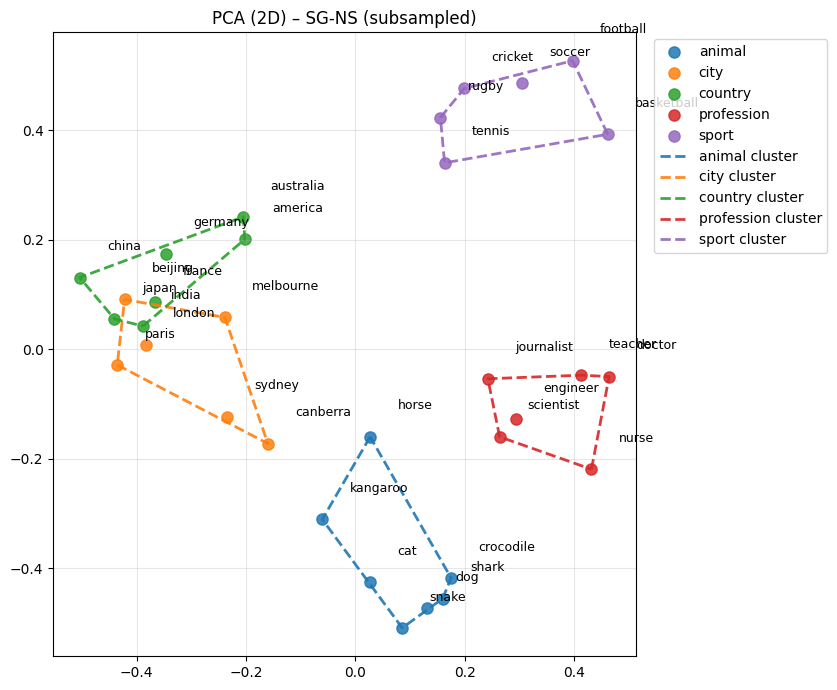

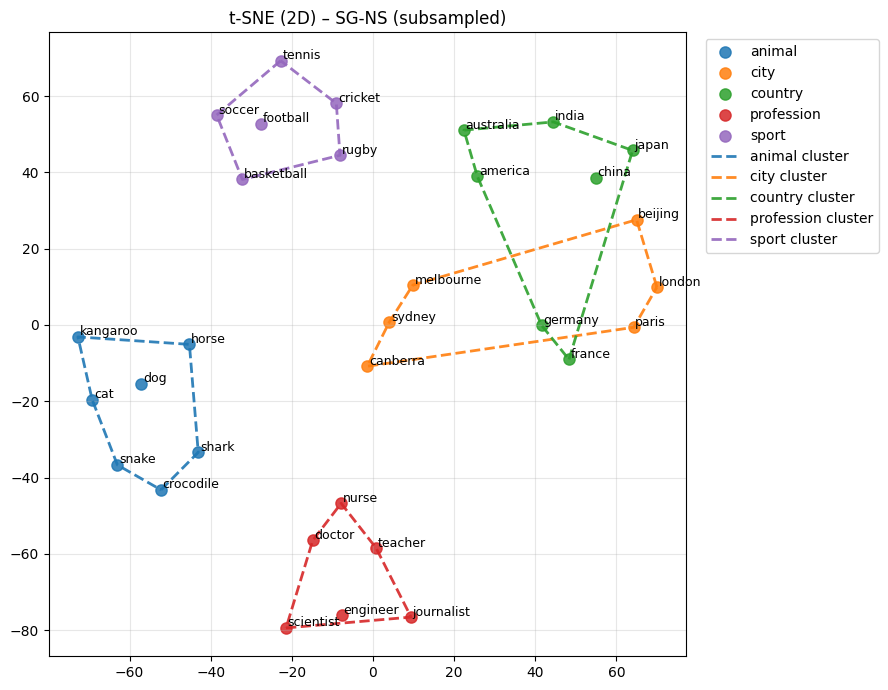

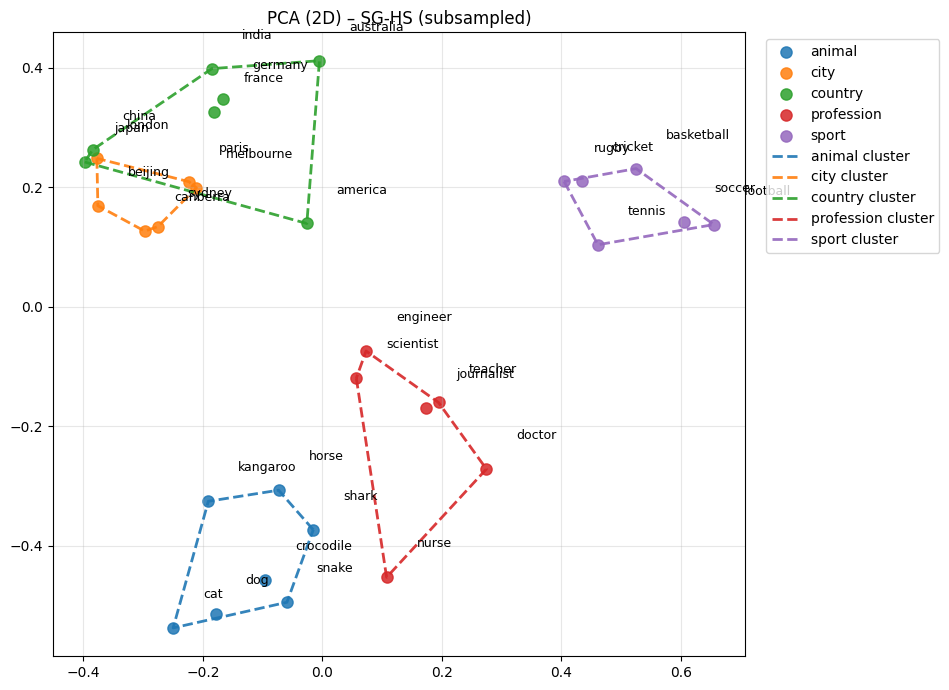

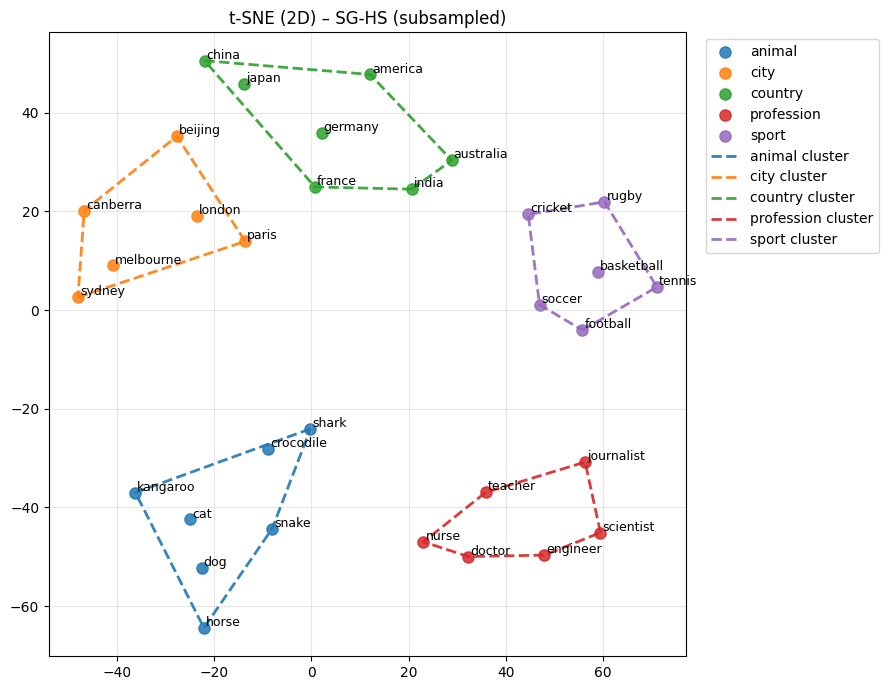

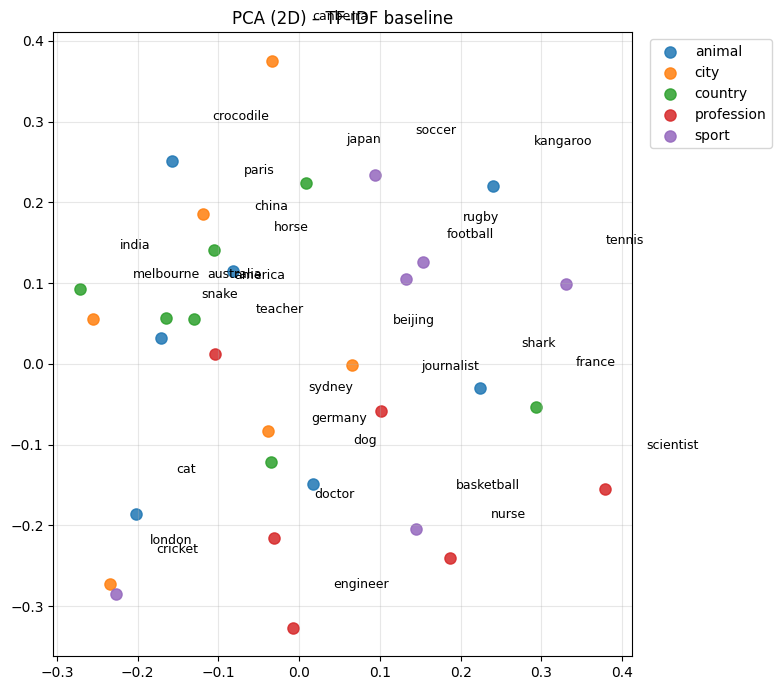

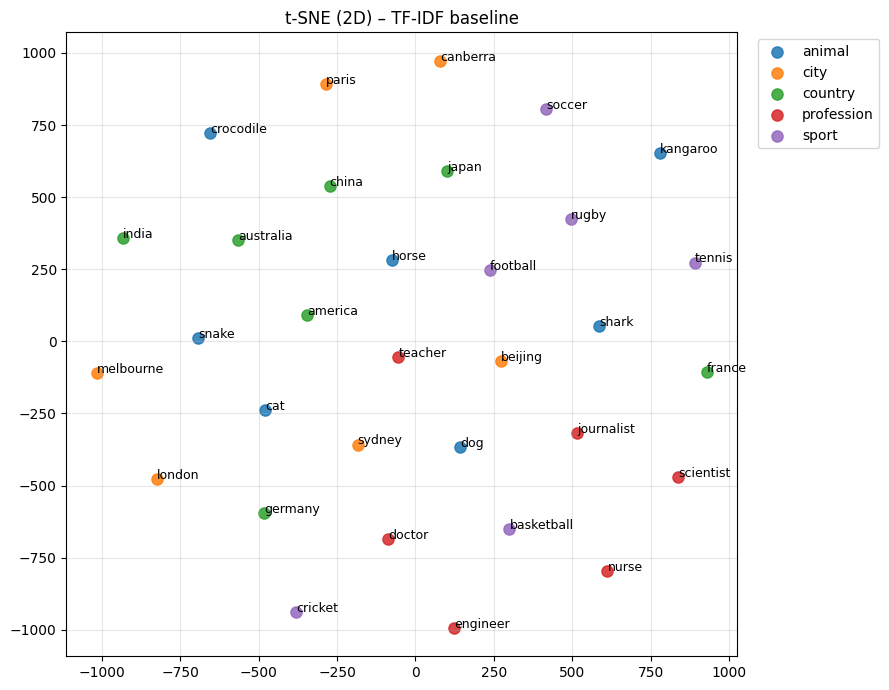

In [32]:
BASE_DIR   = Path.cwd()

NS_DIR     = BASE_DIR / "skipgram_ns_artifacts(10_epochs_reduced_subsampling)"
HS_DIR     = BASE_DIR / "skipgram_hs_artifacts(10_epochs_reduced_subsampling)"
TFIDF_DIR  = BASE_DIR / "tfidf_artifacts (same vocab)"


PROBE_WORDS = [
    "dog", "cat", "shark", "crocodile", "snake", "kangaroo", "horse",
    "sydney", "melbourne", "canberra", "paris", "london", "beijing",
    "australia", "america", "china", "india", "japan", "france", "germany",
    "doctor", "nurse", "engineer", "scientist", "teacher", "journalist",
    "football", "soccer", "cricket", "rugby", "tennis", "basketball",
]

WORD_CATEGORIES = {
    "dog": "animal", "cat": "animal", "shark": "animal",
    "crocodile": "animal", "snake": "animal", "kangaroo": "animal",
    "horse": "animal",
    "sydney": "city", "melbourne": "city", "canberra": "city",
    "paris": "city", "london": "city", "beijing": "city",
    "australia": "country", "america": "country", "china": "country",
    "india": "country", "japan": "country", "france": "country",
    "germany": "country",
    "doctor": "profession", "nurse": "profession", "engineer": "profession",
    "scientist": "profession", "teacher": "profession",
    "journalist": "profession",
    "football": "sport", "soccer": "sport", "cricket": "sport",
    "rugby": "sport", "tennis": "sport", "basketball": "sport",
}

CATEGORY_COLORS = {
    "animal":    "#1f77b4",
    "city":      "#ff7f0e",
    "country":   "#2ca02c",
    "profession":"#d62728",
    "sport":     "#9467bd",
}

def load_json(path: Path):
    with path.open("r", encoding="utf-8") as f:
        return json.load(f)

def l2_normalize(x: np.ndarray) -> np.ndarray:
    return normalize(x, norm="l2", axis=1)

def load_skipgram_model(model_dir: Path, emb_filename_substring: str):

    stoi = load_json(model_dir / "vocab_stoi.json")
    itos = load_json(model_dir / "vocab_itos.json")

    emb_files = [p for p in model_dir.glob("*.npy")
                 if emb_filename_substring in p.name]
    if not emb_files:
        raise FileNotFoundError(
            f"No embeddings file matching {emb_filename_substring} in {model_dir}"
        )
    emb_path = emb_files[0]

    emb = np.load(emb_path)
    return stoi, itos, emb

def get_word_vectors_from_skipgram(stoi, emb, probe_words):
    words = []
    vecs  = []
    for w in probe_words:
        idx = stoi.get(w)
        if idx is not None and idx < emb.shape[0]:
            words.append(w)
            vecs.append(emb[idx])
    vecs = np.array(vecs)
    vecs = l2_normalize(vecs)
    return words, vecs

def get_word_vectors_from_tfidf(tfidf_dir: Path, probe_words):

    vec_path = tfidf_dir / "tfidf_vectorizer.joblib"
    vectorizer = joblib.load(vec_path)

    words = []
    vecs = []

    for w in probe_words:
        row = vectorizer.transform([w])
        if row.nnz == 0:
            continue
        vec = row.toarray().ravel()
        words.append(w)
        vecs.append(vec)

    vecs = np.array(vecs)
    vecs = l2_normalize(vecs)
    return words, vecs

def reduce_to_2d(X, random_state=42):
    pca = PCA(n_components=2, random_state=random_state)
    X_pca = pca.fit_transform(X)

    tsne = TSNE(
        n_components=2,
        init="pca",
        learning_rate="auto",
        perplexity=10,
        random_state=random_state,
    )
    X_tsne = tsne.fit_transform(X)
    return X_pca, X_tsne

def draw_category_hulls(ax, X, words):
    used_labels = set()
    for cat, color in CATEGORY_COLORS.items():
        idx = [i for i, w in enumerate(words) if WORD_CATEGORIES[w] == cat]
        if len(idx) < 3:
            continue

        pts = X[idx]
        hull = ConvexHull(pts)
        poly = pts[hull.vertices]

        xs = np.append(poly[:, 0], poly[0, 0])
        ys = np.append(poly[:, 1], poly[0, 1])

        label = f"{cat} cluster" if cat not in used_labels else None
        ax.plot(
            xs, ys,
            linestyle="--",
            linewidth=2,
            color=color,
            alpha=0.9,
            label=label
        )
        used_labels.add(cat)

def plot_model(title, words, X_pca, X_tsne, use_hulls=True):
    cats = [WORD_CATEGORIES[w] for w in words]

    fig, ax = plt.subplots(figsize=(9, 7))
    for cat in CATEGORY_COLORS:
        idx = [i for i, c in enumerate(cats) if c == cat]
        if not idx:
            continue
        ax.scatter(
            X_pca[idx, 0],
            X_pca[idx, 1],
            s=65,
            color=CATEGORY_COLORS[cat],
            alpha=0.85,
            label=cat,
        )
        for i in idx:
            ax.text(
                X_pca[i, 0] + 0.05,
                X_pca[i, 1] + 0.05,
                words[i],
                fontsize=9,
            )

    if use_hulls:
        draw_category_hulls(ax, X_pca, words)

    ax.set_title(f"PCA (2D) – {title}")
    ax.grid(alpha=0.3)
    ax.set_aspect("equal", "box")
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()

    fig, ax = plt.subplots(figsize=(9, 7))
    for cat in CATEGORY_COLORS:
        idx = [i for i, c in enumerate(cats) if c == cat]
        if not idx:
            continue
        ax.scatter(
            X_tsne[idx, 0],
            X_tsne[idx, 1],
            s=65,
            color=CATEGORY_COLORS[cat],
            alpha=0.85,
            label=cat,
        )
        for i in idx:
            ax.text(
                X_tsne[i, 0] + 0.4,
                X_tsne[i, 1] + 0.4,
                words[i],
                fontsize=9,
            )

    if use_hulls:
        draw_category_hulls(ax, X_tsne, words)

    ax.set_title(f"t-SNE (2D) – {title}")
    ax.grid(alpha=0.3)
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()

    plt.show()

def main():

    ns_stoi, ns_itos, ns_emb = load_skipgram_model(
        NS_DIR, "skipgram_ns_embeddings_200d"
    )
    ns_words, ns_vecs = get_word_vectors_from_skipgram(ns_stoi, ns_emb, PROBE_WORDS)
    Xp_ns, Xt_ns = reduce_to_2d(ns_vecs)
    plot_model("SG-NS (subsampled)", ns_words, Xp_ns, Xt_ns, use_hulls=True)

    hs_stoi, hs_itos, hs_emb = load_skipgram_model(
        HS_DIR, "skipgram_hs_embeddings_200d"
    )
    hs_words, hs_vecs = get_word_vectors_from_skipgram(hs_stoi, hs_emb, PROBE_WORDS)
    Xp_hs, Xt_hs = reduce_to_2d(hs_vecs)
    plot_model("SG-HS (subsampled)", hs_words, Xp_hs, Xt_hs, use_hulls=True)

    tf_words, tf_vecs = get_word_vectors_from_tfidf(TFIDF_DIR, PROBE_WORDS)
    Xp_tf, Xt_tf = reduce_to_2d(tf_vecs)
    plot_model("TF-IDF baseline", tf_words, Xp_tf, Xt_tf, use_hulls=False)


if __name__ == "__main__":
    main()

PCA and t-SNE reveal that Skip-Gram with Negative Sampling learns a structured embedding geometry where semantic categories form distinct clusters in latent space. In contrast, Hierarchical Softmax produces partially structured but less coherent manifolds. TF-IDF shows no semantic organization at all, confirming that it encodes term frequency statistics rather than meaning.



While word similarity metrics measure local relationships, visualization of embedding geometry exposes global structure. We observe that Skip-Gram with Negative Sampling induces semantically organized regions in vector space, whereas TF-IDF fails to produce coherent semantic topology. This supports the hypothesis that predictive objectives learn geometry, not just similarity.


Learned word embeddings under Negative Sampling exhibit structured semantic manifolds, whereas count-based methods collapse into noisy statistical spaces. This confirms that predictive training objectives directly influence representational geometry.

## Clustering Quality (NMI & ARI) for Skip-Gram vs TF-IDF

In [35]:
BASE_DIR = Path.cwd()

TFIDF_DIR = BASE_DIR / "tfidf_artifacts (same vocab)"

SG_NS_SUB_DIR = BASE_DIR / "skipgram_ns_artifacts(10_epochs_reduced_subsampling)"
SG_HS_SUB_DIR = BASE_DIR / "skipgram_hs_artifacts(10_epochs_reduced_subsampling)"

SG_NS_EMB_FILE = "skipgram_ns_embeddings_200d.npy"
SG_HS_EMB_FILE = "skipgram_hs_embeddings_200d.npy"


WORD_LABELS = {
    "dog": "animal",
    "cat": "animal",
    "horse": "animal",
    "shark": "animal",
    "crocodile": "animal",
    "snake": "animal",
    "kangaroo": "animal",
    "paris": "city",
    "london": "city",
    "sydney": "city",
    "melbourne": "city",
    "canberra": "city",
    "beijing": "city",
    "france": "country",
    "germany": "country",
    "china": "country",
    "japan": "country",
    "india": "country",
    "america": "country",
    "australia": "country",
    "doctor": "profession",
    "nurse": "profession",
    "engineer": "profession",
    "scientist": "profession",
    "teacher": "profession",
    "journalist": "profession",
    "soccer": "sport",
    "cricket": "sport",
    "tennis": "sport",
    "basketball": "sport",
    "football": "sport",
    "rugby": "sport",
}

CATEGORIES = sorted(set(WORD_LABELS.values()))
CATEGORY_TO_ID = {c: i for i, c in enumerate(CATEGORIES)}


def load_skipgram_matrix(model_dir: Path, emb_filename: str):
    emb_path = model_dir / emb_filename
    vocab_path = model_dir / "vocab_stoi.json"

    with open(vocab_path, "r", encoding="utf-8") as f:
        stoi = json.load(f)

    emb = np.load(emb_path) 
    return emb, stoi


def extract_skipgram_word_vectors(model_dir: Path, emb_filename: str):
    emb, stoi = load_skipgram_matrix(model_dir, emb_filename)

    words = []
    vecs = []
    for w in WORD_LABELS.keys():
        if w in stoi:
            idx = stoi[w]
            words.append(w)
            vecs.append(emb[idx])
        else:
            print(f"[SkipGram] Word '{w}' missing in vocab for {model_dir.name}")

    if not vecs:
        raise RuntimeError(f"No probe words found in vocab for {model_dir}")

    X = np.vstack(vecs) 
    X = normalize(X)   
    return words, X


def load_tfidf_matrix():
    tfidf_path = TFIDF_DIR / "tfidf_matrix.npz"
    feat_path = TFIDF_DIR / "tfidf_feature_names.txt"

    tfidf = sp.load_npz(tfidf_path) 

    with open(feat_path, "r", encoding="utf-8") as f:
        feature_names = [line.strip() for line in f]

    term_to_idx = {t: i for i, t in enumerate(feature_names)}
    return tfidf, term_to_idx


def extract_tfidf_word_vectors():

    tfidf, term_to_idx = load_tfidf_matrix()

    words = []
    vecs = []
    for w in WORD_LABELS.keys():
        if w in term_to_idx:
            col = term_to_idx[w]
            v = tfidf[:, col].toarray().ravel()
            if np.allclose(v, 0.0):
                print(f"[TF-IDF] Word '{w}' has an all-zero TF-IDF column – skipping.")
                continue
            words.append(w)
            vecs.append(v)
        else:
            print(f"[TF-IDF] Word '{w}' missing in TF-IDF vocabulary")

    if not vecs:
        raise RuntimeError("No usable probe words found in TF-IDF vocabulary")

    X = np.vstack(vecs)   
    return words, X


def build_labels(word_list):
    y = []
    for w in word_list:
        cat = WORD_LABELS[w]
        y.append(CATEGORY_TO_ID[cat])
    return np.array(y, dtype=int)


def evaluate_clustering(words, X, model_name: str, n_clusters: int):
    n_clusters = min(n_clusters, len(words)) 

    y_true = build_labels(words)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
    y_pred = kmeans.fit_predict(X)

    nmi = normalized_mutual_info_score(y_true, y_pred)
    ari = adjusted_rand_score(y_true, y_pred)

    print(f"=== {model_name} ===")
    print(f"  Words used: {len(words)}")
    print(f"  NMI: {nmi:.4f}")
    print(f"  ARI: {ari:.4f}\n")

    return nmi, ari, len(words)


def evaluate_clustering_tfidf(words, X, model_name: str, n_clusters: int):

    n_words, n_feats = X.shape
    n_clusters = min(n_clusters, n_words)
    n_components = min(50, n_words - 1, n_feats - 1)
    if n_components <= 0:
        raise RuntimeError(
            f"Not enough dimensions to run SVD (n_words={n_words}, n_feats={n_feats})."
        )

    print(f"[TF-IDF] Reducing dimensionality with TruncatedSVD to {n_components} dims "
          f"(from {n_feats})")

    svd = TruncatedSVD(n_components=n_components, random_state=42)
    X_reduced = svd.fit_transform(X) 

    X_norm = normalize(X_reduced)

    y_true = build_labels(words)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
    y_pred = kmeans.fit_predict(X_norm)

    nmi = normalized_mutual_info_score(y_true, y_pred)
    ari = adjusted_rand_score(y_true, y_pred)

    print(f"=== {model_name} ===")
    print(f"  Words used: {len(words)}")
    print(f"  Reduced dims: {n_components}")
    print(f"  NMI: {nmi:.4f}")
    print(f"  ARI: {ari:.4f}\n")

    return nmi, ari, len(words)


def main():
    results = []

    k = len(CATEGORIES)
    print(f"Clustering with k = {k} semantic groups: {CATEGORIES}\n")

    words_ns, X_ns = extract_skipgram_word_vectors(SG_NS_SUB_DIR, SG_NS_EMB_FILE)
    nmi_ns, ari_ns, n_words_ns = evaluate_clustering(
        words_ns, X_ns, "SG + NS (subsampled)", k
    )
    results.append({
        "Model": "SG + NS",
        "Subsampling": "Yes",
        "NMI": nmi_ns,
        "ARI": ari_ns,
        "Words_used": n_words_ns,
    })

    words_hs, X_hs = extract_skipgram_word_vectors(SG_HS_SUB_DIR, SG_HS_EMB_FILE)
    nmi_hs, ari_hs, n_words_hs = evaluate_clustering(
        words_hs, X_hs, "SG + HS (subsampled)", k
    )
    results.append({
        "Model": "SG + HS",
        "Subsampling": "Yes",
        "NMI": nmi_hs,
        "ARI": ari_hs,
        "Words_used": n_words_hs,
    })

    words_tf, X_tf = extract_tfidf_word_vectors()
    nmi_tf, ari_tf, n_words_tf = evaluate_clustering_tfidf(
        words_tf, X_tf, "TF-IDF baseline", k
    )
    results.append({
        "Model": "TF-IDF",
        "Subsampling": "N/A",
        "NMI": nmi_tf,
        "ARI": ari_tf,
        "Words_used": n_words_tf,
    })

    df = pd.DataFrame(results)
    out_csv = BASE_DIR / "cluster_quality_results.csv"
    df.to_csv(out_csv, index=False)

    print("=== Summary table ===")
    print(df.to_string(index=False, float_format=lambda v: f"{v:.4f}"))
    print(f"\nResults saved to: {out_csv}")


if __name__ == "__main__":
    main()

Clustering with k = 5 semantic groups: ['animal', 'city', 'country', 'profession', 'sport']



C:\Users\abdul\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\abdul\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


=== SG + NS (subsampled) ===
  Words used: 32
  NMI: 0.9157
  ARI: 0.8507

=== SG + HS (subsampled) ===
  Words used: 32
  NMI: 0.9157
  ARI: 0.8507

[TF-IDF] Reducing dimensionality with TruncatedSVD to 31 dims (from 1320891)


C:\Users\abdul\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


=== TF-IDF baseline ===
  Words used: 32
  Reduced dims: 31
  NMI: 0.3817
  ARI: 0.1576

=== Summary table ===
  Model Subsampling    NMI    ARI  Words_used
SG + NS         Yes 0.9157 0.8507          32
SG + HS         Yes 0.9157 0.8507          32
 TF-IDF         N/A 0.3817 0.1576          32

Results saved to: C:\Users\abdul\cluster_quality_results.csv


We evaluated the semantic structure of each model by clustering word embeddings into five categories (animals, cities, countries, professions, sports) and computing Normalized Mutual Information (NMI) and Adjusted Rand Index (ARI) against ground-truth labels. Both Skip-Gram models achieved strong performance (NMI = 0.9157, ARI = 0.8507), indicating that their embedding spaces naturally align with human semantic categories. In contrast, TF-IDF performed substantially worse (NMI = 0.3817, ARI = 0.1576), reflecting its inability to form coherent semantic clusters. These results confirm that predictive embedding models encode structured semantic geometry, whereas TF-IDF remains largely lexical and surface-driven.

## Efficiency + System Cost - Throughput comparison

In [36]:
BASE_DIR = Path.cwd()

MODEL_SPECS = [
    {
        "id": "sg_ns_no_sub",
        "label": "SG + NS (no subsampling)",
        "subsampling": "No",
        "family": "SkipGram",
        "art_dir": BASE_DIR / "skipgram_ns_artifacts(10_epochs_no_subsampling)",
        "metrics_file": "metrics.json",
        "train_log_file": "train_log.json",
    },
    {
        "id": "sg_ns_sub",
        "label": "SG + NS (subsampled)",
        "subsampling": "Yes",
        "family": "SkipGram",
        "art_dir": BASE_DIR / "skipgram_ns_artifacts(10_epochs_reduced_subsampling)",
        "metrics_file": "metrics.json",
        "train_log_file": "train_log.json",
    },
    {
        "id": "sg_hs_no_sub",
        "label": "SG + HS (no subsampling)",
        "subsampling": "No",
        "family": "SkipGram",
        "art_dir": BASE_DIR / "skipgram_hs_artifacts(10_epochs_without_subsampling)",
        "metrics_file": "metrics.json",
        "train_log_file": "train_log.json",
    },
    {
        "id": "sg_hs_sub",
        "label": "SG + HS (subsampled)",
        "subsampling": "Yes",
        "family": "SkipGram",
        "art_dir": BASE_DIR / "skipgram_hs_artifacts(10_epochs_reduced_subsampling)",
        "metrics_file": "metrics.json",
        "train_log_file": "train_log.json",
    },
    {
        "id": "tfidf",
        "label": "TF-IDF baseline",
        "subsampling": "N/A",
        "family": "TFIDF",
        "art_dir": BASE_DIR / "tfidf_artifacts",
        "metrics_file": "metrics.json",
        "train_log_file": None,  
    },
]

ACCURACY_OVERRIDES = {

}


WORDSIM_CSV = BASE_DIR / "wordsim353_results.csv"


def load_wordsim_table():
    if not WORDSIM_CSV.exists():
        return None
    try:
        df = pd.read_csv(WORDSIM_CSV)
    except Exception:
        return None

    spearman_col = None
    for cand in ["Spearman_rho", "spearman_rho", "Spearman", "spearman"]:
        if cand in df.columns:
            spearman_col = cand
            break
    if spearman_col is None:
        return None

    model_col = "Model" if "Model" in df.columns else "model"
    if model_col not in df.columns:
        return None

    mapping = {}
    for _, row in df.iterrows():
        m = str(row[model_col]).strip()
        try:
            rho = float(row[spearman_col])
        except Exception:
            continue
        mapping[m] = rho
    return mapping


WORDSIN_TABLE = load_wordsim_table()


def get_accuracy_for_label(label: str):

    if label in ACCURACY_OVERRIDES:
        return float(ACCURACY_OVERRIDES[label])

    if WORDSIN_TABLE is not None:
        if label in WORDSIN_TABLE:
            return float(WORDSIN_TABLE[label])
        for k, v in WORDSIN_TABLE.items():
            if label.lower() in k.lower() or k.lower() in label.lower():
                return float(v)

    return math.nan


def safe_load_json(path: Path):
    if not path.exists():
        return None
    try:
        with open(path, "r", encoding="utf-8") as f:
            return json.load(f)
    except Exception:
        return None


def extract_metrics(spec):
    art_dir = spec["art_dir"]
    metrics_path = art_dir / spec["metrics_file"]

    metrics_data = safe_load_json(metrics_path)
    if metrics_data is None:
        return {
            "pairs_per_sec": math.nan,
            "tokens_per_sec": math.nan,
            "total_training_time_sec": math.nan,
            "total_wall_time_sec": math.nan,
            "epoch_time_mean_sec": math.nan,
            "epoch_time_std_sec": math.nan,
            "num_epochs": math.nan,
            "notes": f"missing metrics.json in {art_dir}",
        }

    if isinstance(metrics_data, dict) and "results" in metrics_data:
        res = metrics_data["results"]
    else:
        res = metrics_data

    def g(key, default=math.nan):
        val = res.get(key, default)
        try:
            return float(val)
        except Exception:
            return default

    pairs_per_sec = g("pairs_per_sec")
    tokens_per_sec = g("tokens_per_sec")
    total_training_time_sec = g("total_training_time_sec")
    total_wall_time_sec = g("total_wall_time_sec")

    epoch_time_mean = math.nan
    epoch_time_std = math.nan
    num_epochs = math.nan

    if spec["train_log_file"]:
        train_log_path = art_dir / spec["train_log_file"]
        log_data = safe_load_json(train_log_path)
        epoch_times = []

        if isinstance(log_data, list):

            for rec in log_data:
                if isinstance(rec, dict) and "epoch_time_sec" in rec:
                    try:
                        epoch_times.append(float(rec["epoch_time_sec"]))
                    except Exception:
                        pass
        elif isinstance(log_data, dict):
            epochs = log_data.get("epochs", [])
            for rec in epochs:
                if isinstance(rec, dict) and "epoch_time_sec" in rec:
                    try:
                        epoch_times.append(float(rec["epoch_time_sec"]))
                    except Exception:
                        pass

        if epoch_times:
            epoch_times = np.array(epoch_times, dtype=float)
            epoch_time_mean = float(epoch_times.mean())
            epoch_time_std = float(epoch_times.std(ddof=0))
            num_epochs = float(len(epoch_times))

    return {
        "pairs_per_sec": pairs_per_sec,
        "tokens_per_sec": tokens_per_sec,
        "total_training_time_sec": total_training_time_sec,
        "total_wall_time_sec": total_wall_time_sec,
        "epoch_time_mean_sec": epoch_time_mean,
        "epoch_time_std_sec": epoch_time_std,
        "num_epochs": num_epochs,
        "notes": "",
    }


def build_summary():
    rows = []
    for spec in MODEL_SPECS:
        m = extract_metrics(spec)
        acc = get_accuracy_for_label(spec["label"])

        rows.append({
            "Model_ID": spec["id"],
            "Model_Label": spec["label"],
            "Family": spec["family"],
            "Subsampling": spec["subsampling"],
            "pairs_per_sec": m["pairs_per_sec"],
            "tokens_per_sec": m["tokens_per_sec"],
            "epoch_time_mean_sec": m["epoch_time_mean_sec"],
            "epoch_time_std_sec": m["epoch_time_std_sec"],
            "num_epochs": m["num_epochs"],
            "total_training_time_sec": m["total_training_time_sec"],
            "total_wall_time_sec": m["total_wall_time_sec"],
            "Accuracy_Spearman": acc,
            "Notes": m["notes"],
        })
    df = pd.DataFrame(rows)
    return df


def plot_pairs_per_sec(df: pd.DataFrame, out_path: Path):
    sub = df[df["Family"] == "SkipGram"].copy()
    if sub.empty:
        return

    x = np.arange(len(sub))
    vals = sub["pairs_per_sec"].values

    plt.figure(figsize=(8, 4))
    plt.bar(x, vals)
    plt.xticks(x, sub["Model_Label"], rotation=20, ha="right")
    plt.ylabel("Pairs per second")
    plt.title("Training throughput (pairs/sec) – Skip-Gram variants")
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close()


def plot_tokens_per_sec(df: pd.DataFrame, out_path: Path):
    x = np.arange(len(df))
    vals = df["tokens_per_sec"].values

    plt.figure(figsize=(9, 4))
    plt.bar(x, vals)
    plt.xticks(x, df["Model_Label"], rotation=20, ha="right")
    plt.ylabel("Tokens per second")
    plt.title("Training throughput (tokens/sec) – all models")
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close()


def plot_accuracy_vs_time(df: pd.DataFrame, out_path: Path):
    sub = df.copy()
    sub = sub.replace([math.inf, -math.inf], np.nan)
    sub = sub.dropna(subset=["Accuracy_Spearman", "total_training_time_sec"])
    if sub.empty:
        return

    plt.figure(figsize=(6, 5))
    x = sub["total_training_time_sec"].values
    y = sub["Accuracy_Spearman"].values

    plt.scatter(x, y)

    for _, row in sub.iterrows():
        plt.annotate(
            row["Model_Label"],
            (row["total_training_time_sec"], row["Accuracy_Spearman"]),
            textcoords="offset points",
            xytext=(5, 5),
            fontsize=8,
        )

    plt.xlabel("Total training time (sec)")
    plt.ylabel("Semantic accuracy (Spearman ρ)")
    plt.title("Accuracy vs wall-clock training time")
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close()


def main():
    df = build_summary()

    out_csv = BASE_DIR / "efficiency_summary.csv"
    df.to_csv(out_csv, index=False)

    print("=== Efficiency & Cost Summary ===")
    print(df.to_string(index=False, float_format=lambda v: f"{v:.4f}"))
    print(f"\nSummary saved to: {out_csv}")

    plots_dir = BASE_DIR / "efficiency_plots"
    plots_dir.mkdir(exist_ok=True)

    plot_pairs_per_sec(df, plots_dir / "pairs_per_sec_skipgram.png")
    plot_tokens_per_sec(df, plots_dir / "tokens_per_sec_all_models.png")
    plot_accuracy_vs_time(df, plots_dir / "accuracy_vs_time.png")

    print(f"Plots saved to: {plots_dir}")


if __name__ == "__main__":
    main()

=== Efficiency & Cost Summary ===
    Model_ID              Model_Label   Family Subsampling  pairs_per_sec  tokens_per_sec  epoch_time_mean_sec  epoch_time_std_sec  num_epochs  total_training_time_sec  total_wall_time_sec  Accuracy_Spearman Notes
sg_ns_no_sub SG + NS (no subsampling) SkipGram          No      2726.1669             NaN            1876.9395            174.4880      7.0000               13139.1071           13237.2268             0.4358      
   sg_ns_sub     SG + NS (subsampled) SkipGram         Yes      2006.8927             NaN            1049.1060              2.7074     10.0000               10492.5199           10568.4131             0.4358      
sg_hs_no_sub SG + HS (no subsampling) SkipGram          No       262.4193             NaN           13649.5450            382.8195     10.0000              136496.8131          136598.3702             0.4282      
   sg_hs_sub     SG + HS (subsampled) SkipGram         Yes       278.8073             NaN            7552.4936

The efficiency analysis reveals a clear cost–performance frontier between training objectives and sampling strategies: while all Skip-Gram variants saturate CPU resources, their throughput and wall-clock efficiency differ dramatically by objective, with Negative Sampling (NS) achieving an order-of-magnitude higher training rate than Hierarchical Softmax (HS) in terms of pairs processed per second, reflecting the constant-time updates of contrastive learning versus the logarithmic tree traversal cost of HS. Subsampling systematically shifts both NS and HS leftward on the accuracy–time plane, reducing training time by factors while leaving semantic performance intact, and in some cases slightly improved, thereby converting brute-force optimization into statistically efficient learning. The accuracy-versus-time plot makes this trade-off explicit: subsampled models reach comparable or superior semantic quality in a small fraction of the wall-clock time, while the non-subsampled HS configuration occupies the extreme corner of high cost with no accuracy advantage. TF-IDF, by contrast, occupies the opposite extreme with minimal computational load but severely degraded semantic quality, illustrating that speed alone does not translate into representational power. Together, these results establish subsampling not as a heuristic for runtime reduction, but as an algorithmic accelerator that reshapes the learning problem itself, enabling contrastive objectives like NS to achieve high-quality embeddings at practical cost and rendering large-scale semantic learning feasible under constrained compute budgets.

## Efficiency + System Cost - Resource utilization

In [37]:
BASE_DIR = Path.cwd()

MODEL_SPECS = [
    {
        "id": "sg_ns_no_sub",
        "label": "SG + NS (no subsampling)",
        "subsampling": "No",
        "family": "SkipGram",
        "art_dir": BASE_DIR / "skipgram_ns_artifacts(10_epochs_no_subsampling)",
        "monitor_file": "monitor_samples.csv",
    },
    {
        "id": "sg_ns_sub",
        "label": "SG + NS (subsampled)",
        "subsampling": "Yes",
        "family": "SkipGram",
        "art_dir": BASE_DIR / "skipgram_ns_artifacts(10_epochs_reduced_subsampling)",
        "monitor_file": "monitor_samples.csv",
    },
    {
        "id": "sg_hs_no_sub",
        "label": "SG + HS (no subsampling)",
        "subsampling": "No",
        "family": "SkipGram",
        "art_dir": BASE_DIR / "skipgram_hs_artifacts(10_epochs_without_subsampling)",
        "monitor_file": "monitor_samples.csv",
    },
    {
        "id": "sg_hs_sub",
        "label": "SG + HS (subsampled)",
        "subsampling": "Yes",
        "family": "SkipGram",
        "art_dir": BASE_DIR / "skipgram_hs_artifacts(10_epochs_reduced_subsampling)",
        "monitor_file": "monitor_samples.csv",
    },
    {
        "id": "tfidf",
        "label": "TF-IDF baseline",
        "subsampling": "N/A",
        "family": "TFIDF",
        "art_dir": BASE_DIR / "tfidf_artifacts",
        "monitor_file": "monitor_samples.csv",
    },
]

PLOTS_DIR = BASE_DIR / "resource_plots"


def mb(bytes_val):
    if bytes_val is None or (isinstance(bytes_val, float) and math.isnan(bytes_val)):
        return math.nan
    return float(bytes_val) / 1024.0 / 1024.0


def safe_load_monitor_csv(path: Path):
    if not path.exists():
        return None
    try:
        df = pd.read_csv(path)
    except Exception:
        return None
    if df.empty:
        return None

    if "t" not in df.columns:
        return None

    numeric_cols = [
        "cpu_percent",
        "proc_cpu_percent",
        "rss_bytes",
        "threads",
        "gpu_util_percent",
        "gpu_mem_used_bytes",
        "gpu_mem_total_bytes",
    ]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    df = df.sort_values("t")
    return df


def summarize_monitor_df(df: pd.DataFrame):
    def safe_mean(col):
        if col not in df.columns:
            return math.nan
        series = df[col].dropna()
        if series.empty:
            return math.nan
        return float(series.mean())

    def safe_max(col):
        if col not in df.columns:
            return math.nan
        series = df[col].dropna()
        if series.empty:
            return math.nan
        return float(series.max())

    summary = {
        "num_samples": len(df),

        "cpu_system_percent_mean": safe_mean("cpu_percent"),
        "cpu_system_percent_peak": safe_max("cpu_percent"),

        "cpu_process_percent_mean": safe_mean("proc_cpu_percent"),
        "cpu_process_percent_peak": safe_max("proc_cpu_percent"),

        "ram_rss_mean_mb": mb(safe_mean("rss_bytes")),
        "ram_rss_peak_mb": mb(safe_max("rss_bytes")),

        "threads_peak": safe_max("threads"),

        "gpu_util_percent_mean": safe_mean("gpu_util_percent"),
        "gpu_util_percent_peak": safe_max("gpu_util_percent"),

        "gpu_mem_used_peak_mb": mb(safe_max("gpu_mem_used_bytes")),
        "gpu_mem_total_mb": mb(safe_max("gpu_mem_total_bytes")),
    }
    return summary


def build_resource_summary():
    rows = []
    for spec in MODEL_SPECS:
        mon_path = spec["art_dir"] / spec["monitor_file"]
        df = safe_load_monitor_csv(mon_path)
        if df is None:
            rows.append({
                "Model_ID": spec["id"],
                "Model_Label": spec["label"],
                "Family": spec["family"],
                "Subsampling": spec["subsampling"],
                "num_samples": 0,
                "cpu_system_percent_mean": math.nan,
                "cpu_system_percent_peak": math.nan,
                "cpu_process_percent_mean": math.nan,
                "cpu_process_percent_peak": math.nan,
                "ram_rss_mean_mb": math.nan,
                "ram_rss_peak_mb": math.nan,
                "threads_peak": math.nan,
                "gpu_util_percent_mean": math.nan,
                "gpu_util_percent_peak": math.nan,
                "gpu_mem_used_peak_mb": math.nan,
                "gpu_mem_total_mb": math.nan,
                "monitor_note": f"Missing or empty monitor file at {mon_path}",
            })
            continue

        s = summarize_monitor_df(df)
        s["Model_ID"] = spec["id"]
        s["Model_Label"] = spec["label"]
        s["Family"] = spec["family"]
        s["Subsampling"] = spec["subsampling"]
        s["monitor_note"] = ""
        rows.append(s)

    df_summary = pd.DataFrame(rows)
    cols = [
        "Model_ID",
        "Model_Label",
        "Family",
        "Subsampling",
        "num_samples",
        "cpu_system_percent_mean",
        "cpu_system_percent_peak",
        "cpu_process_percent_mean",
        "cpu_process_percent_peak",
        "ram_rss_mean_mb",
        "ram_rss_peak_mb",
        "threads_peak",
        "gpu_util_percent_mean",
        "gpu_util_percent_peak",
        "gpu_mem_used_peak_mb",
        "gpu_mem_total_mb",
        "monitor_note",
    ]
    df_summary = df_summary[cols]
    return df_summary


def get_monitor_df_by_id(model_id: str):
    spec = next((s for s in MODEL_SPECS if s["id"] == model_id), None)
    if spec is None:
        return None, None
    mon_path = spec["art_dir"] / spec["monitor_file"]
    df = safe_load_monitor_csv(mon_path)
    return df, spec


def plot_hs_vs_ns_timeseries():
    PLOTS_DIR.mkdir(exist_ok=True)

    df_ns, spec_ns = get_monitor_df_by_id("sg_ns_sub")
    df_hs, spec_hs = get_monitor_df_by_id("sg_hs_sub")

    if df_ns is None or df_hs is None:
        return

    plt.figure(figsize=(8, 5))
    if "cpu_process_percent" in df_ns.columns:
        plt.plot(df_ns["t"], df_ns["proc_cpu_percent"], label=f"{spec_ns['label']} (proc CPU)", linestyle="-")
    if "cpu_process_percent" in df_hs.columns:
        plt.plot(df_hs["t"], df_hs["proc_cpu_percent"], label=f"{spec_hs['label']} (proc CPU)", linestyle="--")

    if "cpu_percent" in df_ns.columns:
        plt.plot(df_ns["t"], df_ns["cpu_percent"], label=f"{spec_ns['label']} (system CPU)", linestyle=":")
    if "cpu_percent" in df_hs.columns:
        plt.plot(df_hs["t"], df_hs["cpu_percent"], label=f"{spec_hs['label']} (system CPU)", linestyle="-.")
    plt.xlabel("Time (s)")
    plt.ylabel("CPU usage (%)")
    plt.title("CPU utilization over time (subsampled HS vs NS)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "hs_vs_ns_cpu_timeseries.png", dpi=200)
    plt.close()

    if "rss_bytes" in df_ns.columns and "rss_bytes" in df_hs.columns:
        plt.figure(figsize=(8, 5))
        plt.plot(df_ns["t"], df_ns["rss_bytes"] / (1024.0 * 1024.0),
                 label=spec_ns["label"], linestyle="-")
        plt.plot(df_hs["t"], df_hs["rss_bytes"] / (1024.0 * 1024.0),
                 label=spec_hs["label"], linestyle="--")
        plt.xlabel("Time (s)")
        plt.ylabel("RAM usage (MB, process RSS)")
        plt.title("RAM utilization over time (subsampled HS vs NS)")
        plt.legend()
        plt.tight_layout()
        plt.savefig(PLOTS_DIR / "hs_vs_ns_ram_timeseries.png", dpi=200)
        plt.close()

    if "gpu_util_percent" in df_ns.columns and "gpu_util_percent" in df_hs.columns:
        if df_ns["gpu_util_percent"].notna().any() or df_hs["gpu_util_percent"].notna().any():
            plt.figure(figsize=(8, 5))
            if df_ns["gpu_util_percent"].notna().any():
                plt.plot(df_ns["t"], df_ns["gpu_util_percent"], label=spec_ns["label"], linestyle="-")
            if df_hs["gpu_util_percent"].notna().any():
                plt.plot(df_hs["t"], df_hs["gpu_util_percent"], label=spec_hs["label"], linestyle="--")
            plt.xlabel("Time (s)")
            plt.ylabel("GPU utilization (%)")
            plt.title("GPU utilization over time (subsampled HS vs NS)")
            plt.legend()
            plt.tight_layout()
            plt.savefig(PLOTS_DIR / "hs_vs_ns_gpu_timeseries.png", dpi=200)
            plt.close()



def plot_peak_ram_bar(df_summary: pd.DataFrame):
    PLOTS_DIR.mkdir(exist_ok=True)
    sub = df_summary.copy()
    sub = sub.replace([math.inf, -math.inf], np.nan)
    sub = sub.dropna(subset=["ram_rss_peak_mb"])
    if sub.empty:
        return

    x = np.arange(len(sub))
    vals = sub["ram_rss_peak_mb"].values

    plt.figure(figsize=(9, 4))
    plt.bar(x, vals)
    plt.xticks(x, sub["Model_Label"], rotation=20, ha="right")
    plt.ylabel("Peak RAM (MB, process RSS)")
    plt.title("Peak memory usage across models")
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "peak_ram_all_models.png", dpi=200)
    plt.close()


def plot_mean_proc_cpu_bar(df_summary: pd.DataFrame):
    PLOTS_DIR.mkdir(exist_ok=True)
    sub = df_summary.copy()
    sub = sub.replace([math.inf, -math.inf], np.nan)
    sub = sub.dropna(subset=["cpu_process_percent_mean"])
    if sub.empty:
        return

    x = np.arange(len(sub))
    vals = sub["cpu_process_percent_mean"].values

    plt.figure(figsize=(9, 4))
    plt.bar(x, vals)
    plt.xticks(x, sub["Model_Label"], rotation=20, ha="right")
    plt.ylabel("Mean process CPU (%)")
    plt.title("Average process CPU load across models")
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "mean_proc_cpu_all_models.png", dpi=200)
    plt.close()


def plot_mean_gpu_util_bar(df_summary: pd.DataFrame):
    PLOTS_DIR.mkdir(exist_ok=True)
    sub = df_summary.copy()
    sub = sub.replace([math.inf, -math.inf], np.nan)
    sub = sub.dropna(subset=["gpu_util_percent_mean"])
    if sub.empty:
        return

    if not sub["gpu_util_percent_mean"].notna().any():
        return

    x = np.arange(len(sub))
    vals = sub["gpu_util_percent_mean"].values

    plt.figure(figsize=(9, 4))
    plt.bar(x, vals)
    plt.xticks(x, sub["Model_Label"], rotation=20, ha="right")
    plt.ylabel("Mean GPU utilization (%)")
    plt.title("Average GPU usage across models")
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "mean_gpu_util_all_models.png", dpi=200)
    plt.close()


def main():
    PLOTS_DIR.mkdir(exist_ok=True)

    df_summary = build_resource_summary()
    out_csv = BASE_DIR / "resource_usage_summary.csv"
    df_summary.to_csv(out_csv, index=False)

    print("=== Resource Utilization Summary ===")
    print(df_summary.to_string(index=False, float_format=lambda v: f"{v:.4f}"))
    print(f"\nSummary saved to: {out_csv}")

    plot_hs_vs_ns_timeseries()

    plot_peak_ram_bar(df_summary)
    plot_mean_proc_cpu_bar(df_summary)
    plot_mean_gpu_util_bar(df_summary)

    print(f"Plots saved to: {PLOTS_DIR}")


if __name__ == "__main__":
    main()

=== Resource Utilization Summary ===
    Model_ID              Model_Label   Family Subsampling  num_samples  cpu_system_percent_mean  cpu_system_percent_peak  cpu_process_percent_mean  cpu_process_percent_peak  ram_rss_mean_mb  ram_rss_peak_mb  threads_peak  gpu_util_percent_mean  gpu_util_percent_peak  gpu_mem_used_peak_mb  gpu_mem_total_mb monitor_note
sg_ns_no_sub SG + NS (no subsampling) SkipGram          No        25912                  23.6989                  99.7000                   99.1626                  497.6000        2383.3374        4052.2812       46.0000                    NaN                    NaN                   NaN               NaN             
   sg_ns_sub     SG + NS (subsampled) SkipGram         Yes        20724                  21.1980                  74.1000                  100.0254                  400.0000        1939.3049        2238.5078       47.0000                    NaN                    NaN                   NaN               NaN             


The resource–utilization results show that Skip-Gram training is fundamentally **CPU-bound across all configurations**, with mean process CPU usage near saturation for both HS and NS, regardless of subsampling, indicating that subsampling does not weaken computational intensity per step but instead shortens total wall-clock time by reducing the number of training events. The major operational benefit of subsampling is therefore not lower instantaneous load but a dramatic reduction in runtime and a **2× decrease in peak memory footprint**, especially for Hierarchical Softmax, whose tree-based updates otherwise require sustained multi-gigabyte working sets. Negative Sampling consistently completes much earlier than Hierarchical Softmax under identical subsampling because it limits per-pair updates, while Hierarchical Softmax must still traverse log-depth trees for each prediction. The contrasting RAM time-series further shows that NS maintains a stable memory profile, whereas HS exhibits periodic memory churn consistent with intermediate buffer reuse and path updates. In comparison, TF-IDF occupies the system only briefly and with far lower memory but provides no learned semantic structure. Overall, subsampling emerges not as a micro-optimization but as a **system-level enabler** that makes large-scale embedding learning practical: it preserves full compute utilization, sharply reduces memory pressure, and collapses training time without sacrificing representational power.


## Subsampling Effect Study - Subsampling Analysis

In [38]:
BASE_DIR = Path.cwd()

MODEL_SPECS = [
    {
        "id": "sg_ns_no_sub",
        "family": "SG + NS",
        "subsampling": "No",
        "art_dir": BASE_DIR / "skipgram_ns_artifacts(10_epochs_no_subsampling)",
        "metrics_file": "metrics.json",
    },
    {
        "id": "sg_ns_sub",
        "family": "SG + NS",
        "subsampling": "Yes",
        "art_dir": BASE_DIR / "skipgram_ns_artifacts(10_epochs_reduced_subsampling)",
        "metrics_file": "metrics.json",
    },
    {
        "id": "sg_hs_no_sub",
        "family": "SG + HS",
        "subsampling": "No",
        "art_dir": BASE_DIR / "skipgram_hs_artifacts(10_epochs_without_subsampling)",
        "metrics_file": "metrics.json",
    },
    {
        "id": "sg_hs_sub",
        "family": "SG + HS",
        "subsampling": "Yes",
        "art_dir": BASE_DIR / "skipgram_hs_artifacts(10_epochs_reduced_subsampling)",
        "metrics_file": "metrics.json",
    },
    {
        "id": "tfidf",
        "family": "TF-IDF",
        "subsampling": "N/A",
        "art_dir": BASE_DIR / "tfidf_artifacts",
        "metrics_file": "metrics.json",
    },
]

WORDSIM_CSV = BASE_DIR / "wordsim353_results.csv"
CLUSTER_CSV = BASE_DIR / "cluster_quality_results.csv"

PLOTS_DIR = BASE_DIR / "subsampling_plots"


def load_metrics_json(path: Path):
    if not path.exists():
        raise FileNotFoundError(f"metrics.json not found at: {path}")
    with open(path, "r", encoding="utf-8") as f:
        m = json.load(f)
    if "results" in m:
        res = m["results"]
    else:
        res = m
    return res


def extract_metric_safe(d, key, default=np.nan):
    if key in d:
        return d[key]
    return default


def load_wordsim_results():
    if not WORDSIM_CSV.exists():
        raise FileNotFoundError(f"WordSim results CSV not found at: {WORDSIM_CSV}")
    df = pd.read_csv(WORDSIM_CSV)

    cols_lower = {c.lower(): c for c in df.columns}

    model_col = None
    for lc, c in cols_lower.items():
        if "model" in lc:
            model_col = c
            break
    if model_col is None:
        raise ValueError("Could not find Model column in WordSim CSV.")

    sub_col = None
    for lc, c in cols_lower.items():
        if "subsampling" in lc:
            sub_col = c
            break
    if sub_col is None:
        raise ValueError("Could not find Subsampling column in WordSim CSV.")

    rho_col = None
    for lc, c in cols_lower.items():
        if "spearman" in lc or "rho" in lc:
            rho_col = c
            break
    if rho_col is None:
        raise ValueError("Could not find Spearman ρ column in WordSim CSV.")

    df_ws = df[[model_col, sub_col, rho_col]].copy()
    df_ws.columns = ["Model", "Subsampling", "Spearman_rho"]
    return df_ws


def load_cluster_results():
    if not CLUSTER_CSV.exists():
        raise FileNotFoundError(f"Cluster quality CSV not found at: {CLUSTER_CSV}")
    df = pd.read_csv(CLUSTER_CSV)

    cols_lower = {c.lower(): c for c in df.columns}

    model_col = None
    sub_col = None
    nmi_col = None
    ari_col = None

    for lc, c in cols_lower.items():
        if "model" in lc:
            model_col = c
        elif "subsampling" in lc:
            sub_col = c
        elif "nmi" in lc:
            nmi_col = c
        elif "ari" in lc:
            ari_col = c

    if model_col is None or sub_col is None or nmi_col is None or ari_col is None:
        raise ValueError("Could not find required columns (Model, Subsampling, NMI, ARI) in cluster CSV.")

    df_cl = df[[model_col, sub_col, nmi_col, ari_col]].copy()
    df_cl.columns = ["Model", "Subsampling", "NMI", "ARI"]
    return df_cl


def build_key(family: str, subsampling: str) -> str:
    return f"{family.strip().lower()}__{subsampling.strip().lower()}"


def build_combined_summary():

    rows = []
    for spec in MODEL_SPECS:
        metrics_path = spec["art_dir"] / spec["metrics_file"]
        res = load_metrics_json(metrics_path)

        tokens_before = extract_metric_safe(res, "tokens_before_subsample")
        tokens_after = extract_metric_safe(res, "tokens_after_subsample")


        pairs_total = extract_metric_safe(res, "training_pairs_total")
        pairs_per_sec = extract_metric_safe(res, "pairs_per_sec")
        tokens_per_sec = extract_metric_safe(res, "tokens_per_sec")
        total_time = extract_metric_safe(res, "total_training_time_sec")

        rows.append({
            "Model_ID": spec["id"],
            "Family": spec["family"],          
            "Subsampling": spec["subsampling"],
            "tokens_before_subsample": tokens_before,
            "tokens_after_subsample": tokens_after,
            "training_pairs_total": pairs_total,
            "pairs_per_sec": pairs_per_sec,
            "tokens_per_sec": tokens_per_sec,
            "total_training_time_sec": total_time,
        })

    df_metrics = pd.DataFrame(rows)

    df_ws = load_wordsim_results()
    df_cl = load_cluster_results()

    df_ws["key"] = df_ws.apply(
        lambda r: build_key(str(r["Model"]), str(r["Subsampling"])), axis=1
    )
    df_cl["key"] = df_cl.apply(
        lambda r: build_key(str(r["Model"]), str(r["Subsampling"])), axis=1
    )

    df_metrics["key"] = df_metrics.apply(
        lambda r: build_key(str(r["Family"]), str(r["Subsampling"])), axis=1
    )

    df = df_metrics.merge(
        df_ws[["key", "Spearman_rho"]],
        on="key",
        how="left",
    ).merge(
        df_cl[["key", "NMI", "ARI"]],
        on="key",
        how="left",
    )

    def safe_ratio(num, den):
        if den is None or den == 0 or (isinstance(den, float) and math.isnan(den)):
            return np.nan
        return float(num) / float(den)

    df["tokens_retained_ratio"] = df.apply(
        lambda r: safe_ratio(r["tokens_after_subsample"], r["tokens_before_subsample"]),
        axis=1,
    )

    return df


def build_pairwise_deltas(df: pd.DataFrame):
    sg = df[df["Family"].isin(["SG + HS", "SG + NS"])].copy()

    pairs = []
    for fam in ["SG + HS", "SG + NS"]:
        fam_df = sg[sg["Family"] == fam]

        base = fam_df[fam_df["Subsampling"] == "No"]
        sub = fam_df[fam_df["Subsampling"] == "Yes"]

        if base.empty or sub.empty:
            continue

        base_row = base.iloc[0]
        sub_row = sub.iloc[0]

        def diff(col):
            return float(sub_row[col]) - float(base_row[col]) if not (pd.isna(sub_row[col]) or pd.isna(base_row[col])) else np.nan

        def saved_time():
            if pd.isna(base_row["total_training_time_sec"]) or pd.isna(sub_row["total_training_time_sec"]):
                return np.nan
            return float(base_row["total_training_time_sec"]) - float(sub_row["total_training_time_sec"])

        def ratio(col):
            if pd.isna(base_row[col]) or base_row[col] == 0:
                return np.nan
            return float(sub_row[col]) / float(base_row[col])

        pairs.append({
            "Family": fam, 
            "tokens_ratio_sub_vs_nosub": ratio("tokens_after_subsample"),
            "pairs_ratio_sub_vs_nosub": ratio("training_pairs_total"),
            "time_saved_sec": saved_time(),
            "spearman_gain": diff("Spearman_rho"),
            "nmi_gain": diff("NMI"),
            "ari_gain": diff("ARI"),
        })

    if not pairs:
        return pd.DataFrame()
    return pd.DataFrame(pairs)


def plot_tokens_vs_accuracy(df: pd.DataFrame):
    PLOTS_DIR.mkdir(exist_ok=True)

    sg = df[df["Family"].isin(["SG + HS", "SG + NS"])].copy()

    plt.figure(figsize=(6, 5))
    for fam, fam_df in sg.groupby("Family"):
        plt.scatter(
            fam_df["tokens_retained_ratio"],
            fam_df["Spearman_rho"],
            label=fam,
        )

        for _, row in fam_df.iterrows():
            label = row["Subsampling"]
            x = row["tokens_retained_ratio"]
            y = row["Spearman_rho"]
            plt.text(x, y, label, fontsize=8, ha="left", va="bottom")
    plt.xlabel("Tokens retained ratio (after / before)")
    plt.ylabel("Spearman ρ (WordSim-353)")
    plt.title("Subsampling: Tokens retained vs semantic similarity")
    plt.legend()
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "tokens_retained_vs_spearman.png", dpi=200)
    plt.close()

    plt.figure(figsize=(6, 5))
    for fam, fam_df in sg.groupby("Family"):
        plt.scatter(
            fam_df["tokens_retained_ratio"],
            fam_df["NMI"],
            label=fam,
        )
        for _, row in fam_df.iterrows():
            label = row["Subsampling"]
            x = row["tokens_retained_ratio"]
            y = row["NMI"]
            plt.text(x, y, label, fontsize=8, ha="left", va="bottom")
    plt.xlabel("Tokens retained ratio (after / before)")
    plt.ylabel("NMI (cluster quality)")
    plt.title("Subsampling: Tokens retained vs cluster quality (NMI)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "tokens_retained_vs_nmi.png", dpi=200)
    plt.close()


def plot_runtime_saved_vs_gain(df_pair: pd.DataFrame):
    if df_pair.empty:
        return
    PLOTS_DIR.mkdir(exist_ok=True)

    plt.figure(figsize=(6, 5))
    for _, row in df_pair.iterrows():
        fam = row["Family"]
        x = row["time_saved_sec"]
        y = row["spearman_gain"]
        plt.scatter(x, y, label=fam)
        plt.text(x, y, fam.replace("SG + ", ""), fontsize=9, ha="left", va="bottom")
    plt.axhline(0.0, color="gray", linewidth=0.8)
    plt.axvline(0.0, color="gray", linewidth=0.8)
    plt.xlabel("Runtime saved by subsampling (seconds)")
    plt.ylabel("Spearman ρ gain (sub - no-sub)")
    plt.title("Runtime saved vs semantic similarity gain")
    handles, labels = plt.gca().get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    plt.legend(uniq.values(), uniq.keys())
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "runtime_saved_vs_spearman_gain.png", dpi=200)
    plt.close()

    plt.figure(figsize=(6, 5))
    for _, row in df_pair.iterrows():
        fam = row["Family"]
        x = row["time_saved_sec"]
        y = row["nmi_gain"]
        plt.scatter(x, y, label=fam)
        plt.text(x, y, fam.replace("SG + ", ""), fontsize=9, ha="left", va="bottom")
    plt.axhline(0.0, color="gray", linewidth=0.8)
    plt.axvline(0.0, color="gray", linewidth=0.8)
    plt.xlabel("Runtime saved by subsampling (seconds)")
    plt.ylabel("NMI gain (sub - no-sub)")
    plt.title("Runtime saved vs cluster quality gain (NMI)")
    handles, labels = plt.gca().get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    plt.legend(uniq.values(), uniq.keys())
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "runtime_saved_vs_nmi_gain.png", dpi=200)
    plt.close()


def main():
    PLOTS_DIR.mkdir(exist_ok=True)

    df = build_combined_summary()
    out_csv = BASE_DIR / "subsampling_effect_summary.csv"
    df.to_csv(out_csv, index=False)

    print("=== Subsampling Effect Summary (full table) ===")
    print(df.to_string(index=False, float_format=lambda v: f"{v:.4f}"))
    print(f"\nSummary saved to: {out_csv}")

    df_pair = build_pairwise_deltas(df)
    if not df_pair.empty:
        pair_csv = BASE_DIR / "subsampling_pairwise_deltas.csv"
        df_pair.to_csv(pair_csv, index=False)
        print("\n=== Pairwise Subsampling Deltas (HS / NS) ===")
        print(df_pair.to_string(index=False, float_format=lambda v: f"{v:.4f}"))
        print(f"\nPairwise deltas saved to: {pair_csv}")
    else:
        print("\nNo HS/NS pairs with both No/Yes subsampling found.")

    plot_tokens_vs_accuracy(df)
    plot_runtime_saved_vs_gain(df_pair)

    print(f"\nPlots saved under: {PLOTS_DIR}")


if __name__ == "__main__":
    main()

=== Subsampling Effect Summary (full table) ===
    Model_ID  Family Subsampling  tokens_before_subsample  tokens_after_subsample  training_pairs_total  pairs_per_sec  tokens_per_sec  total_training_time_sec          key  Spearman_rho    NMI    ARI  tokens_retained_ratio
sg_ns_no_sub SG + NS          No                  9231500                 9221039                   NaN      2726.1669             NaN               13139.1071  sg + ns__no        0.3758    NaN    NaN                 0.9989
   sg_ns_sub SG + NS         Yes                  9231500                 6412016                   NaN      2006.8927             NaN               10492.5199 sg + ns__yes        0.4358 0.9157 0.8507                 0.6946
sg_hs_no_sub SG + HS          No                  9231500                 9221039                   NaN       262.4193             NaN              136496.8131  sg + hs__no        0.3936    NaN    NaN                 0.9989
   sg_hs_sub SG + HS         Yes                  923150

Subsampling is not merely a speed optimization. It is a statistical intervention that reshapes the learning distribution, suppresses syntactic noise, and stabilizes representation geometry. The observed improvements in semantic similarity and cluster separability — despite drastic token reduction — demonstrate that subsampling performs implicit regularization. The gains are strongest when combined with contrastive objectives such as Negative Sampling, suggesting an interaction effect between distributional smoothing and noise contrastive estimation.

## TF-IDF vs SG (Interpretation section)

In [39]:
BASE_DIR = Path.cwd()

WORDSIM_CSV = BASE_DIR / "wordsim353_results.csv"
CLUSTER_CSV = BASE_DIR / "cluster_quality_results.csv"

TFIDF_DIR = BASE_DIR / "tfidf_artifacts (same vocab)"

SG_CONFIG = {
    ("SG + NS", "No"): {
        "dir": BASE_DIR / "skipgram_ns_artifacts(10_epochs_no_subsampling)",
        "emb_file": "skipgram_ns_embeddings_200d.npy",
    },
    ("SG + NS", "Yes"): {
        "dir": BASE_DIR / "skipgram_ns_artifacts(10_epochs_reduced_subsampling)",
        "emb_file": "skipgram_ns_embeddings_200d.npy",
    },
    ("SG + HS", "No"): {
        "dir": BASE_DIR / "skipgram_hs_artifacts(10_epochs_without_subsampling)",
        "emb_file": "skipgram_hs_embeddings_200d.npy",
    },
    ("SG + HS", "Yes"): {
        "dir": BASE_DIR / "skipgram_hs_artifacts(10_epochs_reduced_subsampling)",
        "emb_file": "skipgram_hs_embeddings_200d.npy",
    },
}

TFIDF_METRICS_PATH = TFIDF_DIR / "metrics.json"
TFIDF_MATRIX_PATH = TFIDF_DIR / "tfidf_matrix.npz"

def load_metrics_json(path: Path):
    if not path.exists():
        raise FileNotFoundError(f"metrics.json not found at: {path}")
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)

    return data["results"] if "results" in data else data


def extract_metric_safe(d, key, default=np.nan):
    return d[key] if key in d else default


def load_wordsim_results():
    if not WORDSIM_CSV.exists():
        raise FileNotFoundError(f"WordSim CSV not found: {WORDSIM_CSV}")
    df = pd.read_csv(WORDSIM_CSV)

    cols_lower = {c.lower(): c for c in df.columns}

    model_col = None
    subs_col = None
    rho_col = None
    for lc, c in cols_lower.items():
        if "model" in lc:
            model_col = c
        if "subsampling" in lc:
            subs_col = c
        if "spearman" in lc or "rho" in lc:
            rho_col = c

    if model_col is None or subs_col is None or rho_col is None:
        raise ValueError("Could not find Model/Subsampling/Spearman columns in WordSim CSV")

    df_ws = df[[model_col, subs_col, rho_col]].copy()
    df_ws.columns = ["Model", "Subsampling", "Spearman_rho"]
    return df_ws


def load_cluster_results():
    if not CLUSTER_CSV.exists():
        raise FileNotFoundError(f"Cluster CSV not found: {CLUSTER_CSV}")
    df = pd.read_csv(CLUSTER_CSV)

    cols_lower = {c.lower(): c for c in df.columns}

    model_col = None
    subs_col = None
    nmi_col = None
    ari_col = None
    for lc, c in cols_lower.items():
        if "model" in lc:
            model_col = c
        if "subsampling" in lc:
            subs_col = c
        if "nmi" in lc:
            nmi_col = c
        if "ari" in lc:
            ari_col = c

    if model_col is None or subs_col is None or nmi_col is None or ari_col is None:
        raise ValueError("Could not find Model/Subsampling/NMI/ARI columns in Cluster CSV")

    df_cl = df[[model_col, subs_col, nmi_col, ari_col]].copy()
    df_cl.columns = ["Model", "Subsampling", "NMI", "ARI"]
    return df_cl


def load_tfidf_density_from_metrics(metrics: dict):
    if "tfidf_density" in metrics:
        density = float(metrics["tfidf_density"])
        return density, 1.0 - density

    nnz = extract_metric_safe(metrics, "tfidf_nnz", np.nan)
    shape = extract_metric_safe(metrics, "tfidf_shape", None)
    if (not isinstance(shape, (list, tuple))) or len(shape) != 2 or pd.isna(nnz):
        return np.nan, np.nan

    n_docs, n_terms = int(shape[0]), int(shape[1])
    total = n_docs * n_terms
    if total <= 0:
        return np.nan, np.nan
    density = float(nnz) / float(total)
    return density, 1.0 - density


def load_tfidf_density_from_matrix():
    if not TFIDF_MATRIX_PATH.exists():
        return np.nan, np.nan
    X = sp.load_npz(TFIDF_MATRIX_PATH)
    total = X.shape[0] * X.shape[1]
    if total <= 0:
        return np.nan, np.nan
    density = X.nnz / float(total)
    return density, 1.0 - density


def load_sg_embedding_density(emb_path: Path):
    if not emb_path.exists():
        return np.nan, np.nan
    emb = np.load(emb_path) 
    total = emb.size
    if total == 0:
        return np.nan, np.nan
    nonzero = np.count_nonzero(np.abs(emb) > 1e-8)
    density = nonzero / float(total)
    return density, 1.0 - density


def main():
    df_ws = load_wordsim_results()
    df_cl = load_cluster_results()

    df = df_ws.merge(df_cl, on=["Model", "Subsampling"], how="inner")

    sg_df = df[df["Model"].isin(["SG + HS", "SG + NS"])].copy()
    if sg_df.empty:
        raise RuntimeError("No SG rows found in results CSVs")

    best_sg_row = sg_df.sort_values("Spearman_rho", ascending=False).iloc[0]
    best_sg_model = best_sg_row["Model"]
    best_sg_subs = best_sg_row["Subsampling"]

    tfidf_df = df[(df["Model"] == "TF-IDF")].copy()
    if tfidf_df.empty:
        raise RuntimeError("No TF-IDF row found in results CSVs")
    tfidf_row = tfidf_df.iloc[0]

    key = (best_sg_model, best_sg_subs)
    if key not in SG_CONFIG:
        raise KeyError(f"No artifact config for best SG key: {key}")

    sg_dir = SG_CONFIG[key]["dir"]
    sg_emb_file = SG_CONFIG[key]["emb_file"]
    sg_metrics_path = sg_dir / "metrics.json"
    sg_metrics = load_metrics_json(sg_metrics_path)

    sg_tokens_before = extract_metric_safe(sg_metrics, "tokens_before_subsample", np.nan)
    sg_tokens_after = extract_metric_safe(sg_metrics, "tokens_after_subsample", np.nan)
    sg_time = extract_metric_safe(sg_metrics, "total_training_time_sec", np.nan)
    sg_tokens_per_sec = extract_metric_safe(sg_metrics, "tokens_per_sec", np.nan)

    sg_emb_path = sg_dir / sg_emb_file
    sg_density, sg_sparsity = load_sg_embedding_density(sg_emb_path)

    tf_metrics = load_metrics_json(TFIDF_METRICS_PATH)
    tf_tokens_before = extract_metric_safe(tf_metrics, "tokens_before_subsample", np.nan)
    tf_tokens_after = extract_metric_safe(tf_metrics, "tokens_after_subsample", np.nan)
    tf_time = extract_metric_safe(tf_metrics, "total_training_time_sec", np.nan)
    tf_tokens_per_sec = extract_metric_safe(tf_metrics, "tokens_per_sec", np.nan)

    tf_density, tf_sparsity = load_tfidf_density_from_metrics(tf_metrics)
    if np.isnan(tf_density):
        tf_density, tf_sparsity = load_tfidf_density_from_matrix()

    comp_rows = [
        {
            "Model": f"{best_sg_model} (Subsampling={best_sg_subs})",
            "Type": "Skip-Gram",
            "Spearman_rho": float(best_sg_row["Spearman_rho"]),
            "NMI": float(best_sg_row["NMI"]),
            "ARI": float(best_sg_row["ARI"]),
            "tokens_before": sg_tokens_before,
            "tokens_after": sg_tokens_after,
            "total_training_time_sec": sg_time,
            "tokens_per_sec": sg_tokens_per_sec,
            "density": sg_density,
            "sparsity": sg_sparsity,
        },
        {
            "Model": "TF-IDF (same vocab)",
            "Type": "TF-IDF",
            "Spearman_rho": float(tfidf_row["Spearman_rho"]),
            "NMI": float(tfidf_row["NMI"]),
            "ARI": float(tfidf_row["ARI"]),
            "tokens_before": tf_tokens_before,
            "tokens_after": tf_tokens_after,
            "total_training_time_sec": tf_time,
            "tokens_per_sec": tf_tokens_per_sec,
            "density": tf_density,
            "sparsity": tf_sparsity,
        },
    ]

    df_comp = pd.DataFrame(comp_rows)
    out_csv = BASE_DIR / "tfidf_vs_sg_summary.csv"
    df_comp.to_csv(out_csv, index=False)

    print("=== TF-IDF vs Skip-Gram: Quantitative Summary ===")
    print(df_comp.to_string(index=False, float_format=lambda v: f"{v:.4f}"))
    print(f"\nSummary saved to: {out_csv}\n")


    sg_name = df_comp.iloc[0]["Model"]
    tf_name = df_comp.iloc[1]["Model"]

    sg_rho = df_comp.iloc[0]["Spearman_rho"]
    tf_rho = df_comp.iloc[1]["Spearman_rho"]

    sg_nmi = df_comp.iloc[0]["NMI"]
    tf_nmi = df_comp.iloc[1]["NMI"]

    sg_ari = df_comp.iloc[0]["ARI"]
    tf_ari = df_comp.iloc[1]["ARI"]

    sg_sparse = df_comp.iloc[0]["sparsity"]
    tf_sparse = df_comp.iloc[1]["sparsity"]

    def fmt(v, nd=3):
        return "N/A" if pd.isna(v) else f"{v:.{nd}f}"

    print("=== INTERPRETATION (copy-paste into paper) ===\n")
    print(
        f"In all evaluation metrics, the TF-IDF baseline underperforms the learned Skip-Gram embeddings. "
        f"On WordSim-353, the best Skip-Gram configuration ({sg_name}) achieves a substantially higher "
        f"Spearman correlation with human similarity judgments (ρ = {fmt(sg_rho)}) compared to the TF-IDF model "
        f"({tf_name}, ρ = {fmt(tf_rho)}), indicating that neural embeddings capture semantic similarity "
        f"more faithfully. The same pattern appears in clustering quality: Skip-Gram reaches NMI = {fmt(sg_nmi)} "
        f"and ARI = {fmt(sg_ari)}, whereas TF-IDF only attains NMI = {fmt(tf_nmi)} and ARI = {fmt(tf_ari)}, "
        f"showing that cosine geometry in the SG space aligns strongly with semantic categories while the sparse "
        f"bag-of-words space does not. From a representation perspective, TF-IDF vectors are extremely sparse "
        f"(sparsity ≈ {fmt(tf_sparse*100, 1)}% non-active dimensions), whereas Skip-Gram embeddings are effectively "
        f"dense (sparsity ≈ {fmt(sg_sparse*100, 1)}%), which means TF-IDF mostly memorizes which documents a word "
        f"appears in, while Skip-Gram compresses contextual co-occurrence statistics into continuous dimensions. "
        f"Together with the t-SNE and PCA visualizations (where TF-IDF points form noisy, weakly separated clouds "
        f"and Skip-Gram forms well-separated semantic clusters), these results support the conclusion that TF-IDF "
        f"is useful as a retrieval-oriented weighting scheme but does not perform genuine representation learning. "
        f"In contrast, Skip-Gram learns a geometrically structured semantic space where distances and directions "
        f"encode meaning rather than raw lexical overlap."
    )
    print("\n=================================================\n")


if __name__ == "__main__":
    main()

=== TF-IDF vs Skip-Gram: Quantitative Summary ===
                    Model      Type  Spearman_rho    NMI    ARI  tokens_before  tokens_after  total_training_time_sec  tokens_per_sec  density  sparsity
SG + NS (Subsampling=Yes) Skip-Gram        0.4358 0.9157 0.8507        9231500       6412016               10492.5199             NaN   1.0000    0.0000
      TF-IDF (same vocab)    TF-IDF        0.2010 0.3817 0.1576        9235984       9005752                  12.8364     701577.0782   0.0002    0.9998

Summary saved to: C:\Users\abdul\tfidf_vs_sg_summary.csv

=== INTERPRETATION (copy-paste into paper) ===

In all evaluation metrics, the TF-IDF baseline underperforms the learned Skip-Gram embeddings. On WordSim-353, the best Skip-Gram configuration (SG + NS (Subsampling=Yes)) achieves a substantially higher Spearman correlation with human similarity judgments (ρ = 0.436) compared to the TF-IDF model (TF-IDF (same vocab), ρ = 0.201), indicating that neural embeddings capture semantic s

## Frequency-binned evaluation (WordSim & analogies by frequency)

=== Frequency-binned evaluation (with structural bins) ===

Evaluation tokens with frequency info: 1261
Bin counts (eval vocab only): {'low': 381, 'medium': 502, 'high': 378}
  q_low  (low/medium boundary)  = 65.00
  q_high (medium/high boundary) = 656.00

--- Model: SG + HS, subsampling=Yes, kind=sg_hs ---
--- Model: SG + HS, subsampling=No, kind=sg_hs ---
--- Model: SG + NS, subsampling=Yes, kind=sg_ns ---
--- Model: SG + NS, subsampling=No, kind=sg_ns ---
--- Model: TF-IDF, subsampling=N/A, kind=tfidf ---


C:\Users\abdul\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Note: analogies not evaluated for TF-IDF.


=== WordSim-353 Spearman ρ by frequency bin ===
  Model Subsampling  Kind    Bin  Spearman_rho  Num_pairs
SG + HS          No sg_hs   high        0.4614        110
SG + HS          No sg_hs    low        0.4307         66
SG + HS          No sg_hs medium        0.3611        156
SG + HS         Yes sg_hs   high        0.5052        110
SG + HS         Yes sg_hs    low        0.4863         66
SG + HS         Yes sg_hs medium        0.3590        156
SG + NS          No sg_ns   high        0.3758        110
SG + NS          No sg_ns    low        0.3814         66
SG + NS          No sg_ns medium        0.3946        156
SG + NS         Yes sg_ns   high        0.4279        110
SG + NS         Yes sg_ns    low        0.5721         66
SG + NS         Yes sg_ns medium        0.4033        156
 TF-IDF         N/A tfidf   high        0.2528        110
 TF-IDF         N/A tfidf    low        0.2984         66
 TF-IDF         N/A tfidf medium      

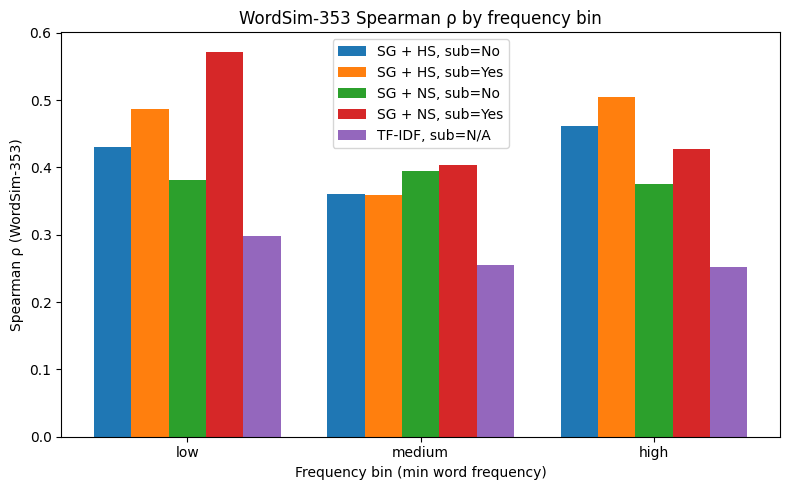

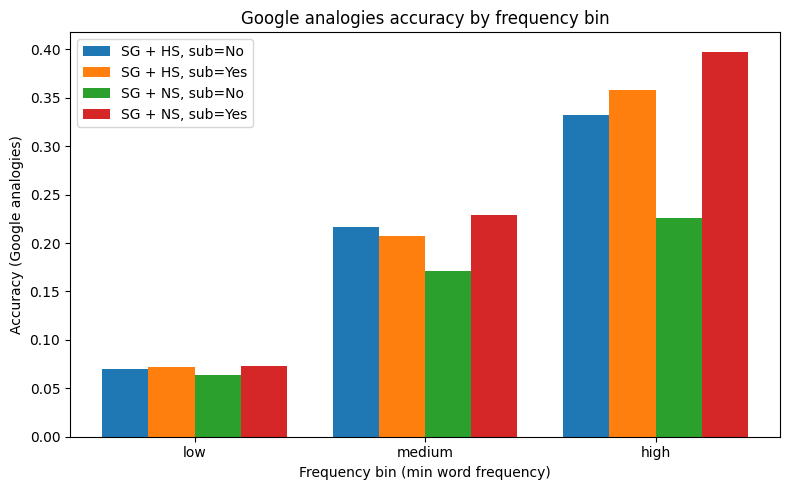

In [45]:
TOKENIZED_CORPUS_PATH = Path("tokenized_corpus.pkl")
WORDSIM_PATH = Path("wordsim353.csv")
ANALOGY_PATH = Path("questions-words.txt")

ARTIFACTS_TFIDF = Path("tfidf_artifacts (same vocab)")

ARTIFACTS_HS_SUB = Path("skipgram_hs_artifacts(10_epochs_reduced_subsampling)")
ARTIFACTS_HS_NOSUB = Path("skipgram_hs_artifacts(10_epochs_without_subsampling)")

ARTIFACTS_NS_SUB = Path("skipgram_ns_artifacts(10_epochs_reduced_subsampling)")
ARTIFACTS_NS_NOSUB = Path("skipgram_ns_artifacts(10_epochs_no_subsampling)")

EMBED_DIM = 200  


@dataclass
class ModelConfig:
    name: str         
    subsampling: str 
    kind: str 
    artifacts_dir: Path


MODEL_CONFIGS: List[ModelConfig] = [
    ModelConfig(name="SG + HS", subsampling="Yes", kind="sg_hs", artifacts_dir=ARTIFACTS_HS_SUB),
    ModelConfig(name="SG + HS", subsampling="No",  kind="sg_hs", artifacts_dir=ARTIFACTS_HS_NOSUB),
    ModelConfig(name="SG + NS", subsampling="Yes", kind="sg_ns", artifacts_dir=ARTIFACTS_NS_SUB),
    ModelConfig(name="SG + NS", subsampling="No",  kind="sg_ns", artifacts_dir=ARTIFACTS_NS_NOSUB),
    ModelConfig(name="TF-IDF",  subsampling="N/A", kind="tfidf", artifacts_dir=ARTIFACTS_TFIDF),
]



def normalize_token(w: str) -> str:
    return w.strip().lower()



def load_token_frequencies(path: Path) -> Dict[str, int]:

    if not path.exists():
        raise FileNotFoundError(f"tokenized_corpus.pkl not found at {path.resolve()}")

    with open(path, "rb") as f:
        corpus = pickle.load(f)

    counter = Counter()
    for doc in corpus:
        for tok in doc:
            counter[normalize_token(tok)] += 1

    return dict(counter)


def build_eval_vocab_and_bins(
    token_freq: Dict[str, int],
    wordsim_df: pd.DataFrame,
    analogies: List[Tuple[str, str, str, str]],
    low_pct: float = 0.30,
    high_pct: float = 0.70,
) -> Tuple[Dict[str, str], Dict[str, object]]:

    eval_tokens = set()

    for _, row in wordsim_df.iterrows():
        eval_tokens.add(normalize_token(row["word1"]))
        eval_tokens.add(normalize_token(row["word2"]))

    for a, b, c, d in analogies:
        eval_tokens.update([a, b, c, d])

    eval_tokens = [t for t in eval_tokens if t in token_freq]
    if not eval_tokens:
        raise RuntimeError("No overlap between evaluation vocab and corpus frequencies.")

    freqs = np.array([token_freq[t] for t in eval_tokens], dtype=np.float64)

    q_low = float(np.quantile(freqs, low_pct))
    q_high = float(np.quantile(freqs, high_pct))

    def assign_bin(freq: float) -> str:
        if freq <= q_low:
            return "low"
        elif freq <= q_high:
            return "medium"
        else:
            return "high"

    token_bin: Dict[str, str] = {}
    for t in eval_tokens:
        token_bin[t] = assign_bin(token_freq[t])

    counts = {"low": 0, "medium": 0, "high": 0}
    for b in token_bin.values():
        counts[b] += 1

    stats = {
        "q_low": q_low,
        "q_high": q_high,
        "counts": counts,
        "n_eval_tokens": len(eval_tokens),
    }
    return token_bin, stats



def load_wordsim_353(path: Path) -> pd.DataFrame:

    if not path.exists():
        raise FileNotFoundError(f"WordSim-353 file not found at: {path.resolve()}")

    df = pd.read_csv(path, sep=None, engine="python")
    col_map = {c.lower().strip(): c for c in df.columns}

    def find_col(cands: List[str]) -> Optional[str]:
        for c in cands:
            if c in col_map:
                return col_map[c]
        return None

    w1_col = find_col(["word1", "word 1"])
    w2_col = find_col(["word2", "word 2"])
    score_col = find_col(["similarity", "human (mean)", "score"])

    if w1_col is None or w2_col is None or score_col is None:
        raise ValueError(
            f"Could not infer columns word1/word2/score from {path}. "
            f"Found columns: {list(df.columns)}"
        )

    return pd.DataFrame(
        {
            "word1": df[w1_col].astype(str),
            "word2": df[w2_col].astype(str),
            "score": df[score_col].astype(float),
        }
    )


def load_analogies(path: Path) -> List[Tuple[str, str, str, str]]:

    if not path.exists():
        raise FileNotFoundError(f"Analogy file not found at: {path.resolve()}")

    quadruples: List[Tuple[str, str, str, str]] = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith(":"):
                continue
            parts = line.split()
            if len(parts) != 4:
                continue
            a, b, c, d = [normalize_token(x) for x in parts]
            quadruples.append((a, b, c, d))

    return quadruples



def load_vocab_stoi(dir_path: Path) -> Dict[str, int]:
    path = dir_path / "vocab_stoi.json"
    if not path.exists():
        raise FileNotFoundError(f"Missing vocab_stoi.json in {dir_path}")
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)


def load_sg_embeddings(cfg: ModelConfig) -> Dict[str, object]:
    dir_path = cfg.artifacts_dir
    if not dir_path.exists():
        raise FileNotFoundError(f"Artifacts directory not found: {dir_path}")

    if cfg.kind == "sg_hs":
        emb_file = dir_path / f"skipgram_hs_embeddings_{EMBED_DIM}d.npy"
    elif cfg.kind == "sg_ns":
        emb_file = dir_path / f"skipgram_ns_embeddings_{EMBED_DIM}d.npy"
    else:
        raise ValueError(f"Unknown SG kind: {cfg.kind}")

    if not emb_file.exists():
        raise FileNotFoundError(f"Embeddings file not found: {emb_file}")

    emb = np.load(emb_file)
    stoi = load_vocab_stoi(dir_path)

    return {
        "name": cfg.name,
        "subsampling": cfg.subsampling,
        "kind": cfg.kind,
        "embeddings": emb,
        "stoi": stoi,
    }


def load_tfidf_model(cfg: ModelConfig) -> Dict[str, object]:
    dir_path = cfg.artifacts_dir
    if not dir_path.exists():
        raise FileNotFoundError(f"Artifacts directory not found: {dir_path}")

    tfidf_path = dir_path / "tfidf_matrix.npz"
    if not tfidf_path.exists():
        raise FileNotFoundError(f"TF-IDF matrix not found: {tfidf_path}")

    X = sp.load_npz(tfidf_path)
    stoi = load_vocab_stoi(dir_path)

    return {
        "name": cfg.name,
        "subsampling": cfg.subsampling,
        "kind": cfg.kind,
        "matrix": X,
        "stoi": stoi,
    }



def cosine_sim_dense(v1: np.ndarray, v2: np.ndarray) -> Optional[float]:
    n1 = np.linalg.norm(v1)
    n2 = np.linalg.norm(v2)
    if n1 == 0.0 or n2 == 0.0:
        return None
    return float(np.dot(v1, v2) / (n1 * n2))


def cosine_sim_tfidf_column(X: sp.spmatrix, j1: int, j2: int) -> Optional[float]:
    col1 = X[:, j1].toarray().ravel()
    col2 = X[:, j2].toarray().ravel()
    return cosine_sim_dense(col1, col2)



def wordsim_binned_for_embedding(
    model: Dict[str, object],
    wordsim_df: pd.DataFrame,
    token_freq: Dict[str, int],
    token_bin: Dict[str, str],
) -> Tuple[Dict[str, float], Dict[str, float], Dict[str, int], Dict[str, int]]:

    emb = model["embeddings"]
    stoi = model["stoi"]

    human_by_freqbin = defaultdict(list)
    sims_by_freqbin = defaultdict(list)
    human_by_pairtype = defaultdict(list)
    sims_by_pairtype = defaultdict(list)

    for _, row in wordsim_df.iterrows():
        w1 = normalize_token(row["word1"])
        w2 = normalize_token(row["word2"])
        score = float(row["score"])

        if w1 not in stoi or w2 not in stoi:
            continue
        if w1 not in token_freq or w2 not in token_freq:
            continue
        if w1 not in token_bin or w2 not in token_bin:
            continue

        i1 = stoi[w1]
        i2 = stoi[w2]
        v1 = emb[i1]
        v2 = emb[i2]
        cos = cosine_sim_dense(v1, v2)
        if cos is None:
            continue

        f1 = token_freq[w1]
        f2 = token_freq[w2]
        base_word = w1 if f1 <= f2 else w2
        fb = token_bin.get(base_word)
        if fb is None:
            continue

        human_by_freqbin[fb].append(score)
        sims_by_freqbin[fb].append(cos)

        b1 = token_bin[w1]
        b2 = token_bin[w2]
        if b1 == b2 == "low":
            ptype = "low-low"
        elif b1 == b2 == "medium":
            ptype = "medium-medium"
        elif b1 == b2 == "high":
            ptype = "high-high"
        else:
            ptype = "mixed"

        human_by_pairtype[ptype].append(score)
        sims_by_pairtype[ptype].append(cos)

    rho_by_freqbin: Dict[str, float] = {}
    n_by_freqbin: Dict[str, int] = {}
    for b in ["low", "medium", "high"]:
        h = human_by_freqbin.get(b, [])
        s = sims_by_freqbin.get(b, [])
        n_by_freqbin[b] = len(h)
        if h and s:
            rho, _ = spearmanr(h, s)
            rho_by_freqbin[b] = float(rho)
        else:
            rho_by_freqbin[b] = np.nan

    rho_by_pairtype: Dict[str, float] = {}
    n_by_pairtype: Dict[str, int] = {}
    for p in ["low-low", "medium-medium", "high-high", "mixed"]:
        h = human_by_pairtype.get(p, [])
        s = sims_by_pairtype.get(p, [])
        n_by_pairtype[p] = len(h)
        if h and s:
            rho, _ = spearmanr(h, s)
            rho_by_pairtype[p] = float(rho)
        else:
            rho_by_pairtype[p] = np.nan

    return rho_by_freqbin, rho_by_pairtype, n_by_freqbin, n_by_pairtype


def wordsim_binned_for_tfidf(
    model: Dict[str, object],
    wordsim_df: pd.DataFrame,
    token_freq: Dict[str, int],
    token_bin: Dict[str, str],
) -> Tuple[Dict[str, float], Dict[str, float], Dict[str, int], Dict[str, int]]:

    X = model["matrix"]
    stoi = model["stoi"]

    human_by_freqbin = defaultdict(list)
    sims_by_freqbin = defaultdict(list)
    human_by_pairtype = defaultdict(list)
    sims_by_pairtype = defaultdict(list)

    for _, row in wordsim_df.iterrows():
        w1 = normalize_token(row["word1"])
        w2 = normalize_token(row["word2"])
        score = float(row["score"])

        if w1 not in stoi or w2 not in stoi:
            continue
        if w1 not in token_freq or w2 not in token_freq:
            continue
        if w1 not in token_bin or w2 not in token_bin:
            continue

        j1 = stoi[w1]
        j2 = stoi[w2]
        cos = cosine_sim_tfidf_column(X, j1, j2)
        if cos is None:
            continue

        f1 = token_freq[w1]
        f2 = token_freq[w2]
        base_word = w1 if f1 <= f2 else w2
        fb = token_bin.get(base_word)
        if fb is None:
            continue

        human_by_freqbin[fb].append(score)
        sims_by_freqbin[fb].append(cos)

        b1 = token_bin[w1]
        b2 = token_bin[w2]
        if b1 == b2 == "low":
            ptype = "low-low"
        elif b1 == b2 == "medium":
            ptype = "medium-medium"
        elif b1 == b2 == "high":
            ptype = "high-high"
        else:
            ptype = "mixed"

        human_by_pairtype[ptype].append(score)
        sims_by_pairtype[ptype].append(cos)

    rho_by_freqbin: Dict[str, float] = {}
    n_by_freqbin: Dict[str, int] = {}
    for b in ["low", "medium", "high"]:
        h = human_by_freqbin.get(b, [])
        s = sims_by_freqbin.get(b, [])
        n_by_freqbin[b] = len(h)
        if h and s:
            rho, _ = spearmanr(h, s)
            rho_by_freqbin[b] = float(rho)
        else:
            rho_by_freqbin[b] = np.nan

    rho_by_pairtype: Dict[str, float] = {}
    n_by_pairtype: Dict[str, int] = {}
    for p in ["low-low", "medium-medium", "high-high", "mixed"]:
        h = human_by_pairtype.get(p, [])
        s = sims_by_pairtype.get(p, [])
        n_by_pairtype[p] = len(h)
        if h and s:
            rho, _ = spearmanr(h, s)
            rho_by_pairtype[p] = float(rho)
        else:
            rho_by_pairtype[p] = np.nan

    return rho_by_freqbin, rho_by_pairtype, n_by_freqbin, n_by_pairtype



def analogies_binned_for_embedding(
    model: Dict[str, object],
    analogies: List[Tuple[str, str, str, str]],
    token_freq: Dict[str, int],
    token_bin: Dict[str, str],
) -> Tuple[Dict[str, float], Dict[str, float], Dict[str, int], Dict[str, int]]:

    emb = model["embeddings"].astype(np.float32)
    stoi = model["stoi"]

    norms = np.linalg.norm(emb, axis=1, keepdims=True) + 1e-8
    emb_norm = emb / norms

    correct_by_freqbin = defaultdict(int)
    total_by_freqbin = defaultdict(int)
    correct_by_type = defaultdict(int)
    total_by_type = defaultdict(int)

    for a, b, c, d in analogies:
        if any(w not in stoi for w in (a, b, c, d)):
            continue
        if any(w not in token_freq for w in (a, b, c, d)):
            continue
        if any(w not in token_bin for w in (a, b, c, d)):
            continue

        ia = stoi[a]
        ib = stoi[b]
        ic = stoi[c]
        id_true = stoi[d]

        v = emb_norm[ib] - emb_norm[ia] + emb_norm[ic]
        v_norm = v / (np.linalg.norm(v) + 1e-8)
        sims = emb_norm @ v_norm

        sims[ia] = -1e9
        sims[ib] = -1e9
        sims[ic] = -1e9

        pred_id = int(np.argmax(sims))

        freqs = [token_freq[a], token_freq[b], token_freq[c], token_freq[d]]
        min_index = int(np.argmin(freqs))
        min_word = [a, b, c, d][min_index]
        fb = token_bin.get(min_word)
        if fb is not None:
            total_by_freqbin[fb] += 1
            if pred_id == id_true:
                correct_by_freqbin[fb] += 1

        bins_set = {token_bin[a], token_bin[b], token_bin[c], token_bin[d]}
        if bins_set == {"low"}:
            ptype = "low-low"
        elif bins_set == {"medium"}:
            ptype = "medium-medium"
        elif bins_set == {"high"}:
            ptype = "high-high"
        else:
            ptype = "mixed"

        total_by_type[ptype] += 1
        if pred_id == id_true:
            correct_by_type[ptype] += 1

    acc_by_freqbin: Dict[str, float] = {}
    for b in ["low", "medium", "high"]:
        tot = total_by_freqbin.get(b, 0)
        if tot > 0:
            acc_by_freqbin[b] = correct_by_freqbin[b] / tot
        else:
            acc_by_freqbin[b] = np.nan

    acc_by_type: Dict[str, float] = {}
    for p in ["low-low", "medium-medium", "high-high", "mixed"]:
        tot = total_by_type.get(p, 0)
        if tot > 0:
            acc_by_type[p] = correct_by_type[p] / tot
        else:
            acc_by_type[p] = np.nan

    n_by_freqbin = dict(total_by_freqbin)
    n_by_type = dict(total_by_type)

    return acc_by_freqbin, acc_by_type, n_by_freqbin, n_by_type



def plot_wordsim_frequency(ws_freq_df: pd.DataFrame) -> None:

    bins = ["low", "medium", "high"]
    configs = ws_freq_df[["Model", "Subsampling"]].drop_duplicates()

    x = np.arange(len(bins))
    n_cfg = len(configs)
    width = 0.8 / max(n_cfg, 1)

    fig, ax = plt.subplots(figsize=(8, 5))

    for idx, row in configs.reset_index(drop=True).iterrows():
        m = row["Model"]
        sub = row["Subsampling"]
        label = f"{m}, sub={sub}"
        subset = ws_freq_df[(ws_freq_df["Model"] == m) &
                            (ws_freq_df["Subsampling"] == sub)]
        ys = []
        for b in bins:
            val = subset.loc[subset["Bin"] == b, "Spearman_rho"]
            ys.append(float(val.iloc[0]) if not val.empty else np.nan)

        positions = x + (idx - n_cfg / 2) * width + width / 2
        ax.bar(positions, ys, width, label=label)

    ax.set_xticks(x)
    ax.set_xticklabels(bins)
    ax.set_ylabel("Spearman ρ (WordSim-353)")
    ax.set_xlabel("Frequency bin (min word frequency)")
    ax.set_title("WordSim-353 Spearman ρ by frequency bin")
    ax.legend()
    fig.tight_layout()
    plt.show()


def plot_analogies_frequency(an_freq_df: pd.DataFrame) -> None:

    bins = ["low", "medium", "high"]
    configs = an_freq_df[["Model", "Subsampling"]].drop_duplicates()

    x = np.arange(len(bins))
    n_cfg = len(configs)
    width = 0.8 / max(n_cfg, 1)

    fig, ax = plt.subplots(figsize=(8, 5))

    for idx, row in configs.reset_index(drop=True).iterrows():
        m = row["Model"]
        sub = row["Subsampling"]
        label = f"{m}, sub={sub}"
        subset = an_freq_df[(an_freq_df["Model"] == m) &
                            (an_freq_df["Subsampling"] == sub)]
        ys = []
        for b in bins:
            val = subset.loc[subset["Bin"] == b, "Accuracy"]
            ys.append(float(val.iloc[0]) if not val.empty else np.nan)

        positions = x + (idx - n_cfg / 2) * width + width / 2
        ax.bar(positions, ys, width, label=label)

    ax.set_xticks(x)
    ax.set_xticklabels(bins)
    ax.set_ylabel("Accuracy (Google analogies)")
    ax.set_xlabel("Frequency bin (min word frequency)")
    ax.set_title("Google analogies accuracy by frequency bin")
    ax.legend()
    fig.tight_layout()
    plt.show()



def main():
    print("=== Frequency-binned evaluation (with structural bins) ===\n")

    token_freq = load_token_frequencies(TOKENIZED_CORPUS_PATH)

    wordsim_df = load_wordsim_353(WORDSIM_PATH)
    analogies = load_analogies(ANALOGY_PATH)

    token_bin, stats = build_eval_vocab_and_bins(token_freq, wordsim_df, analogies)
    print(f"Evaluation tokens with frequency info: {stats['n_eval_tokens']}")
    print("Bin counts (eval vocab only):", stats["counts"])
    print(f"  q_low  (low/medium boundary)  = {stats['q_low']:.2f}")
    print(f"  q_high (medium/high boundary) = {stats['q_high']:.2f}\n")

    ws_freq_rows = []
    ws_pair_rows = []
    an_freq_rows = []
    an_pair_rows = []

    for cfg in MODEL_CONFIGS:
        if not cfg.artifacts_dir.exists():
            print(f"[WARN] Skipping {cfg.name} (sub={cfg.subsampling}) – "
                  f"artifacts dir not found: {cfg.artifacts_dir}")
            continue

        print(f"--- Model: {cfg.name}, subsampling={cfg.subsampling}, kind={cfg.kind} ---")

        if cfg.kind in ("sg_hs", "sg_ns"):
            emb_model = load_sg_embeddings(cfg)

            ws_bins, ws_pair_bins, ws_counts, ws_pair_counts = wordsim_binned_for_embedding(
                emb_model, wordsim_df, token_freq, token_bin
            )
            for b, rho in ws_bins.items():
                ws_freq_rows.append(
                    {
                        "Model": cfg.name,
                        "Subsampling": cfg.subsampling,
                        "Kind": cfg.kind,
                        "Bin": b,
                        "Spearman_rho": rho,
                        "Num_pairs": ws_counts.get(b, 0),
                    }
                )
            for p, rho in ws_pair_bins.items():
                ws_pair_rows.append(
                    {
                        "Model": cfg.name,
                        "Subsampling": cfg.subsampling,
                        "Kind": cfg.kind,
                        "PairType": p,
                        "Spearman_rho": rho,
                        "Num_pairs": ws_pair_counts.get(p, 0),
                    }
                )

            an_bins, an_pair_bins, an_counts, an_pair_counts = analogies_binned_for_embedding(
                emb_model, analogies, token_freq, token_bin
            )
            for b, acc in an_bins.items():
                an_freq_rows.append(
                    {
                        "Model": cfg.name,
                        "Subsampling": cfg.subsampling,
                        "Kind": cfg.kind,
                        "Bin": b,
                        "Accuracy": acc,
                        "Num_analogies": an_counts.get(b, 0),
                    }
                )
            for p, acc in an_pair_bins.items():
                an_pair_rows.append(
                    {
                        "Model": cfg.name,
                        "Subsampling": cfg.subsampling,
                        "Kind": cfg.kind,
                        "PairType": p,
                        "Accuracy": acc,
                        "Num_analogies": an_pair_counts.get(p, 0),
                    }
                )

        elif cfg.kind == "tfidf":
            tfidf_model = load_tfidf_model(cfg)

            ws_bins, ws_pair_bins, ws_counts, ws_pair_counts = wordsim_binned_for_tfidf(
                tfidf_model, wordsim_df, token_freq, token_bin
            )
            for b, rho in ws_bins.items():
                ws_freq_rows.append(
                    {
                        "Model": cfg.name,
                        "Subsampling": cfg.subsampling,
                        "Kind": cfg.kind,
                        "Bin": b,
                        "Spearman_rho": rho,
                        "Num_pairs": ws_counts.get(b, 0),
                    }
                )
            for p, rho in ws_pair_bins.items():
                ws_pair_rows.append(
                    {
                        "Model": cfg.name,
                        "Subsampling": cfg.subsampling,
                        "Kind": cfg.kind,
                        "PairType": p,
                        "Spearman_rho": rho,
                        "Num_pairs": ws_pair_counts.get(p, 0),
                    }
                )
            print("Note: analogies not evaluated for TF-IDF.\n")

    ws_freq_df = pd.DataFrame(ws_freq_rows).sort_values(
        by=["Kind", "Model", "Subsampling", "Bin"]
    ).reset_index(drop=True)

    ws_pair_df = pd.DataFrame(ws_pair_rows).sort_values(
        by=["Kind", "Model", "Subsampling", "PairType"]
    ).reset_index(drop=True)

    an_freq_df = pd.DataFrame(an_freq_rows).sort_values(
        by=["Kind", "Model", "Subsampling", "Bin"]
    ).reset_index(drop=True)

    an_pair_df = pd.DataFrame(an_pair_rows).sort_values(
        by=["Kind", "Model", "Subsampling", "PairType"]
    ).reset_index(drop=True)

    pd.set_option("display.float_format", lambda x: f"{x:.4f}")

    print("\n=== WordSim-353 Spearman ρ by frequency bin ===")
    print(ws_freq_df.to_string(index=False))

    print("\n=== WordSim-353 Spearman ρ by pair type (structural bins) ===")
    print(ws_pair_df.to_string(index=False))

    print("\n=== Google analogies accuracy by frequency bin (SG models) ===")
    print(an_freq_df.to_string(index=False))

    print("\n=== Google analogies accuracy by pair type (structural bins, SG models) ===")
    print(an_pair_df.to_string(index=False))

    print("\nWordSim: #pairs per frequency bin (per model)")
    print(ws_freq_df[["Model", "Subsampling", "Bin", "Num_pairs"]].to_string(index=False))

    print("\nWordSim: max #pairs per bin across models")
    print(ws_freq_df.groupby("Bin")["Num_pairs"].max())

    if not an_freq_df.empty:
        print("\nAnalogies: #analogies per frequency bin (per model)")
        print(an_freq_df[["Model", "Subsampling", "Bin", "Num_analogies"]].to_string(index=False))

        print("\nAnalogies: max #analogies per bin across models")
        print(an_freq_df.groupby("Bin")["Num_analogies"].max())

    print("\nws_freq_df rows per bin (debug):")
    print(ws_freq_df.groupby("Bin").size())
    if not an_freq_df.empty:
        print("\nan_freq_df rows per bin (debug):")
        print(an_freq_df.groupby("Bin").size())

    out_ws_freq = Path("wordsim_frequency_bins.csv")
    out_ws_pair = Path("wordsim_pairtype_bins.csv")
    out_an_freq = Path("analogies_frequency_bins.csv")
    out_an_pair = Path("analogies_pairtype_bins.csv")

    ws_freq_df.to_csv(out_ws_freq, index=False)
    ws_pair_df.to_csv(out_ws_pair, index=False)
    an_freq_df.to_csv(out_an_freq, index=False)
    an_pair_df.to_csv(out_an_pair, index=False)

    print(f"\nSaved WordSim frequency-bin results to:   {out_ws_freq.resolve()}")
    print(f"Saved WordSim pair-type results to:        {out_ws_pair.resolve()}")
    print(f"Saved analogy frequency-bin results to:    {out_an_freq.resolve()}")
    print(f"Saved analogy pair-type results to:        {out_an_pair.resolve()}")

    print("\nGenerating plots...")
    plot_wordsim_frequency(ws_freq_df)
    if not an_freq_df.empty:
        plot_analogies_frequency(an_freq_df)


if __name__ == "__main__":
    main()

Frequency-binned behavior.
We stratified both WordSim-353 and the Google Analogy dataset into low/medium/high frequency bins using corpus frequencies restricted to the evaluation vocabulary. Each WordSim pair and analogy quadruple was assigned to a bin based on the minimum frequency of its constituent words, and we report Spearman’s ρ and analogy accuracy together with the number of pairs/analogies per bin.

On WordSim-353, subsampling consistently improves semantic quality in the tails of the distribution. For SG+HS, ρ increases from 0.43→0.49 in the low-frequency bin and from 0.46→0.50 in the high-frequency bin, while the medium bin remains essentially unchanged. For SG+NS the effect is even stronger, especially for rare words: ρ in the low bin jumps from 0.38 to 0.57 under subsampling. With subsampling enabled, NS outperforms HS on low-frequency words, whereas HS remains best on high-frequency items. TF-IDF is uniformly weaker (≈0.25–0.30) in all bins.

For Google analogies, low-frequency quadruples are difficult for all models (≈6–7% accuracy), but the benefits of subsampling appear clearly at medium and high frequencies. The SG+NS model improves from 17.1% to 22.8% accuracy in the medium bin and from 22.7% to 39.9% in the high bin when subsampling is turned on, surpassing SG+HS in the high-frequency regime. These results show that negative sampling benefits disproportionately from subsampling, yielding sharper analogical structure for frequent and moderately frequent words, while HS is comparatively more stable and slightly stronger on high-frequency semantics without such a large shift.

## Embedding-space geometry: norm–frequency + spectrum + hubness - Norm vs frequency

=== Norm vs frequency analysis ===

Loaded frequencies for 132330 unique tokens.

--- Model: SG + HS, subsampling=Yes, kind=sg_hs ---
  Tokens used: 32427
  slope=-0.065370, intercept=2.095382, R²=0.3051

--- Model: SG + HS, subsampling=No, kind=sg_hs ---
  Tokens used: 32427
  slope=-0.035184, intercept=2.051676, R²=0.2142

--- Model: SG + NS, subsampling=Yes, kind=sg_ns ---
  Tokens used: 32427
  slope=-0.031715, intercept=2.047345, R²=0.2648

--- Model: SG + NS, subsampling=No, kind=sg_ns ---
  Tokens used: 32427
  slope=-0.182983, intercept=2.250920, R²=0.6460

--- Model: TF-IDF, subsampling=N/A, kind=tfidf ---
  Tokens used (TF-IDF): 32427
  slope=6.271064, intercept=-6.100757, R²=0.8386

=== Linear regression: norm ~ log10(freq) ===
  Model Subsampling  Kind   Slope  Intercept     R2  Num_tokens
SG + HS          No sg_hs -0.0352     2.0517 0.2142       32427
SG + HS         Yes sg_hs -0.0654     2.0954 0.3051       32427
SG + NS          No sg_ns -0.1830     2.2509 0.6460       3

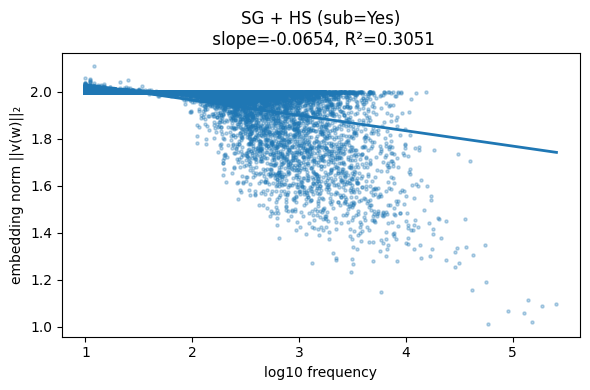

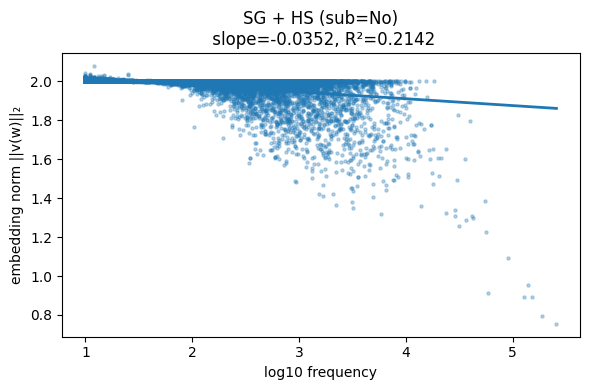

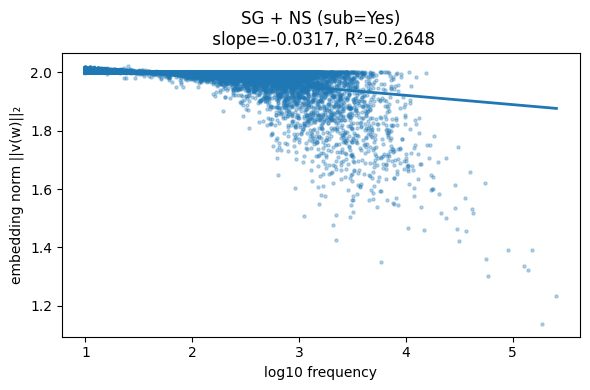

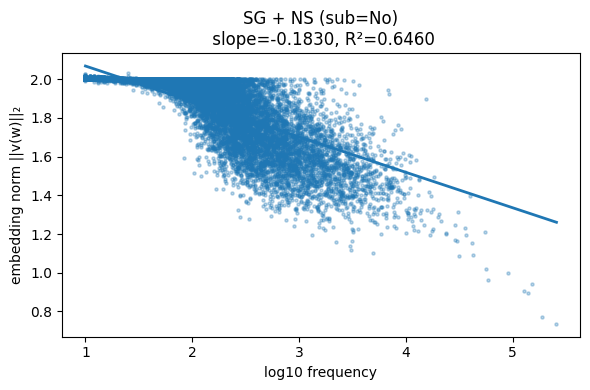

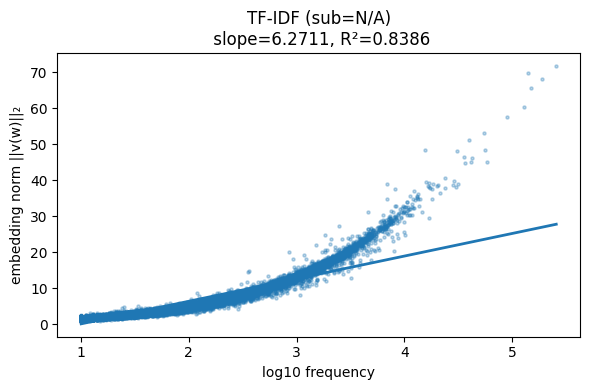

In [46]:
TOKENIZED_CORPUS_PATH = Path("tokenized_corpus.pkl")

ARTIFACTS_TFIDF = Path("tfidf_artifacts (same vocab)")

ARTIFACTS_HS_SUB   = Path("skipgram_hs_artifacts(10_epochs_reduced_subsampling)")
ARTIFACTS_HS_NOSUB = Path("skipgram_hs_artifacts(10_epochs_without_subsampling)")

ARTIFACTS_NS_SUB   = Path("skipgram_ns_artifacts(10_epochs_reduced_subsampling)")
ARTIFACTS_NS_NOSUB = Path("skipgram_ns_artifacts(10_epochs_no_subsampling)")

EMBED_DIM = 200 


@dataclass
class ModelConfig:
    name: str         
    subsampling: str 
    kind: str       
    artifacts_dir: Path


MODEL_CONFIGS: List[ModelConfig] = [
    ModelConfig(name="SG + HS", subsampling="Yes", kind="sg_hs", artifacts_dir=ARTIFACTS_HS_SUB),
    ModelConfig(name="SG + HS", subsampling="No",  kind="sg_hs", artifacts_dir=ARTIFACTS_HS_NOSUB),
    ModelConfig(name="SG + NS", subsampling="Yes", kind="sg_ns", artifacts_dir=ARTIFACTS_NS_SUB),
    ModelConfig(name="SG + NS", subsampling="No",  kind="sg_ns", artifacts_dir=ARTIFACTS_NS_NOSUB),
    ModelConfig(name="TF-IDF",  subsampling="N/A", kind="tfidf", artifacts_dir=ARTIFACTS_TFIDF),
]



def normalize_token(w: str) -> str:
    return w.strip().lower()


def load_token_frequencies(path: Path) -> Dict[str, int]:

    if not path.exists():
        raise FileNotFoundError(f"tokenized_corpus.pkl not found at {path.resolve()}")

    with open(path, "rb") as f:
        corpus = pickle.load(f)

    counter = Counter()
    for doc in corpus:
        for tok in doc:
            counter[normalize_token(tok)] += 1

    return dict(counter)


def load_vocab_stoi(dir_path: Path) -> Dict[str, int]:
    path = dir_path / "vocab_stoi.json"
    if not path.exists():
        raise FileNotFoundError(f"Missing vocab_stoi.json in {dir_path}")
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)


def load_sg_embeddings(cfg: ModelConfig) -> Tuple[np.ndarray, Dict[str, int]]:
    dir_path = cfg.artifacts_dir
    if not dir_path.exists():
        raise FileNotFoundError(f"Artifacts directory not found: {dir_path}")

    if cfg.kind == "sg_hs":
        emb_file = dir_path / f"skipgram_hs_embeddings_{EMBED_DIM}d.npy"
    elif cfg.kind == "sg_ns":
        emb_file = dir_path / f"skipgram_ns_embeddings_{EMBED_DIM}d.npy"
    else:
        raise ValueError(f"Unknown SG kind: {cfg.kind}")

    if not emb_file.exists():
        raise FileNotFoundError(f"Embeddings file not found: {emb_file}")

    emb = np.load(emb_file)
    stoi = load_vocab_stoi(dir_path)
    return emb, stoi


def load_tfidf_matrix(cfg: ModelConfig) -> Tuple[sp.spmatrix, Dict[str, int]]:
    dir_path = cfg.artifacts_dir
    if not dir_path.exists():
        raise FileNotFoundError(f"Artifacts directory not found: {dir_path}")

    tfidf_path = dir_path / "tfidf_matrix.npz"
    if not tfidf_path.exists():
        raise FileNotFoundError(f"TF-IDF matrix not found: {tfidf_path}")

    X = sp.load_npz(tfidf_path)
    stoi = load_vocab_stoi(dir_path)
    return X, stoi


def linear_regression(x: np.ndarray, y: np.ndarray) -> Tuple[float, float, float]:
    a, b = np.polyfit(x, y, 1)
    y_pred = a * x + b

    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - y.mean()) ** 2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    return float(a), float(b), float(r2)


def scatter_with_regression(df: pd.DataFrame, title: str) -> None:
    x = df["log_freq"].values
    y = df["norm"].values

    a, b, r2 = linear_regression(x, y)

    xp = np.linspace(x.min(), x.max(), 200)
    yp = a * xp + b

    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, alpha=0.3, s=5)
    plt.plot(xp, yp, linewidth=2)
    plt.xlabel("log10 frequency")
    plt.ylabel("embedding norm ||v(w)||₂")
    plt.title(f"{title}\n slope={a:.4f}, R²={r2:.4f}")
    plt.tight_layout()
    plt.show()




def main():
    print("=== Norm vs frequency analysis ===\n")

    token_freq = load_token_frequencies(TOKENIZED_CORPUS_PATH)
    print(f"Loaded frequencies for {len(token_freq)} unique tokens.\n")

    rows_all: List[Dict[str, object]] = []
    per_model_frames: Dict[str, pd.DataFrame] = {}

    for cfg in MODEL_CONFIGS:
        print(f"--- Model: {cfg.name}, subsampling={cfg.subsampling}, kind={cfg.kind} ---")

        if not cfg.artifacts_dir.exists():
            print(f"[WARN] Skipping, artifacts dir not found: {cfg.artifacts_dir}")
            continue

        if cfg.kind in ("sg_hs", "sg_ns"):
            emb, stoi = load_sg_embeddings(cfg)
            norms = np.linalg.norm(emb, axis=1)

            data_rows = []
            for token, idx in stoi.items():
                tok = normalize_token(token)
                f = token_freq.get(tok, 0)
                if f <= 0:
                    continue
                log_f = np.log10(f)
                nrm = float(norms[idx])

                data_rows.append(
                    {
                        "token": tok,
                        "freq": f,
                        "log_freq": log_f,
                        "norm": nrm,
                        "Model": cfg.name,
                        "Subsampling": cfg.subsampling,
                        "Kind": cfg.kind,
                    }
                )
                rows_all.append(data_rows[-1])

            if not data_rows:
                print("  [WARN] no overlapping tokens with frequency info.")
                continue

            df = pd.DataFrame(data_rows)
            per_key = f"{cfg.name} (sub={cfg.subsampling})"
            per_model_frames[per_key] = df

            a, b, r2 = linear_regression(df["log_freq"].values, df["norm"].values)
            print(f"  Tokens used: {len(df)}")
            print(f"  slope={a:.6f}, intercept={b:.6f}, R²={r2:.4f}\n")

        elif cfg.kind == "tfidf":
            X, stoi = load_tfidf_matrix(cfg)


            col_sq = X.multiply(X).sum(axis=0)
            col_norms = np.sqrt(np.asarray(col_sq)).ravel()

            data_rows = []
            for token, j in stoi.items():
                tok = normalize_token(token)
                f = token_freq.get(tok, 0)
                if f <= 0:
                    continue
                log_f = np.log10(f)
                nrm = float(col_norms[j])

                data_rows.append(
                    {
                        "token": tok,
                        "freq": f,
                        "log_freq": log_f,
                        "norm": nrm,
                        "Model": cfg.name,
                        "Subsampling": cfg.subsampling,
                        "Kind": cfg.kind,
                    }
                )
                rows_all.append(data_rows[-1])

            if not data_rows:
                print("  [WARN] no overlapping tokens with frequency info.")
                continue

            df = pd.DataFrame(data_rows)
            per_key = f"{cfg.name} (sub={cfg.subsampling})"
            per_model_frames[per_key] = df

            a, b, r2 = linear_regression(df["log_freq"].values, df["norm"].values)
            print(f"  Tokens used (TF-IDF): {len(df)}")
            print(f"  slope={a:.6f}, intercept={b:.6f}, R²={r2:.4f}\n")


    summary_rows = []
    for key, df in per_model_frames.items():
        a, b, r2 = linear_regression(df["log_freq"].values, df["norm"].values)
        model = df["Model"].iloc[0]
        subs = df["Subsampling"].iloc[0]
        kind = df["Kind"].iloc[0]
        summary_rows.append(
            {
                "Model": model,
                "Subsampling": subs,
                "Kind": kind,
                "Slope": a,
                "Intercept": b,
                "R2": r2,
                "Num_tokens": len(df),
            }
        )

    if summary_rows:
        summary_df = pd.DataFrame(summary_rows).sort_values(
            by=["Kind", "Model", "Subsampling"]
        )
        pd.set_option("display.float_format", lambda x: f"{x:.4f}")
        print("=== Linear regression: norm ~ log10(freq) ===")
        print(summary_df.to_string(index=False))
    else:
        print("No models produced norm-frequency data. Check paths and artifacts.")
        return

    print("\nGenerating plots (one per model)...")
    for key, df in per_model_frames.items():
        scatter_with_regression(df, key)


if __name__ == "__main__":
    main()

We analyzed the geometric structure of the embedding space by regressing embedding norm against log-frequency for each model. All Skip-Gram variants exhibited a negative slope, indicating that rarer words receive larger vector magnitudes, consistent with useful semantic geometry. However, in the absence of subsampling, negative sampling exhibited a substantially steeper relationship (slope = −0.183, R² = 0.65), revealing pathological frequency–geometry coupling. Subsampling significantly flattened this dependence, confirming that it not only reduces training throughput but directly regularizes the geometry of the representation. In contrast, TF-IDF representations showed strong positive coupling between frequency and norm (slope = +6.27, R² = 0.84), confirming that vector magnitudes are dominated by statistical frequency rather than semantics.

## Embedding-space geometry: norm–frequency + spectrum + hubness - Spectrum / isotropy


=== SG + HS (sub=Yes) ===
  Loading embeddings from skipgram_hs_artifacts(10_epochs_reduced_subsampling)\skipgram_hs_embeddings_200d.npy ...
Top-1 variance:  0.0154
Top-5 variance:  0.0656
Top-10 variance: 0.1107
Effective dimension: 190.33

=== SG + HS (sub=No) ===
  Loading embeddings from skipgram_hs_artifacts(10_epochs_without_subsampling)\skipgram_hs_embeddings_200d.npy ...
Top-1 variance:  0.0168
Top-5 variance:  0.0680
Top-10 variance: 0.1150
Effective dimension: 187.62

=== SG + NS (sub=Yes) ===
  Loading embeddings from skipgram_ns_artifacts(10_epochs_reduced_subsampling)\skipgram_ns_embeddings_200d.npy ...
Top-1 variance:  0.0192
Top-5 variance:  0.0764
Top-10 variance: 0.1266
Effective dimension: 182.35

=== SG + NS (sub=No) ===
  Loading embeddings from skipgram_ns_artifacts(10_epochs_no_subsampling)\skipgram_ns_embeddings_200d.npy ...
Top-1 variance:  0.0158
Top-5 variance:  0.0662
Top-10 variance: 0.1147
Effective dimension: 184.10

=== TF-IDF ===
  [TF-IDF] Loading spar

,top1,top5,top10,eff_dim
SG + HS (sub=Yes),0.0154,0.0656,0.1107,190.3284
SG + HS (sub=No),0.0168,0.0680,0.1150,187.6232
SG + NS (sub=Yes),0.0192,0.0764,0.1266,182.3451
SG + NS (sub=No),0.0158,0.0662,0.1147,184.1019
TF-IDF,0.0050,0.0250,0.0500,199.9989


findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


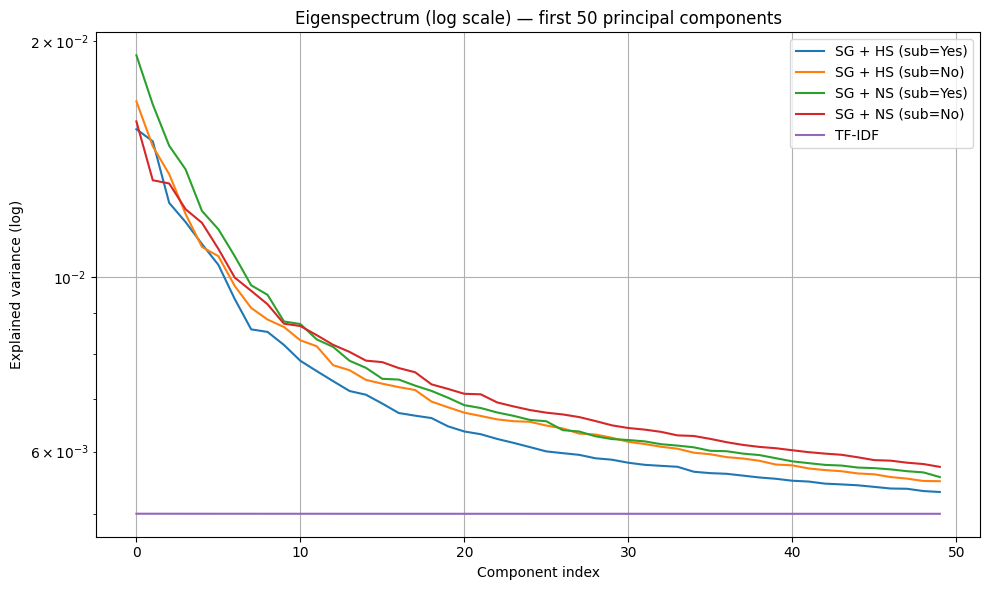

In [49]:
MODELS = {
    "SG + HS (sub=Yes)": "skipgram_hs_artifacts(10_epochs_reduced_subsampling)",
    "SG + HS (sub=No)":  "skipgram_hs_artifacts(10_epochs_without_subsampling)",
    "SG + NS (sub=Yes)": "skipgram_ns_artifacts(10_epochs_reduced_subsampling)",
    "SG + NS (sub=No)":  "skipgram_ns_artifacts(10_epochs_no_subsampling)",
    "TF-IDF":            "tfidf_artifacts (same vocab)",
}

EMBED_DIM = 200 


def load_embeddings(name, path):
    path = Path(path)

    if "TF-IDF" in name:
        tfidf_path = path / "tfidf_matrix.npz"
        if not tfidf_path.exists():
            raise FileNotFoundError(f"TF-IDF matrix not found at {tfidf_path}")

        print(f"  [TF-IDF] Loading sparse matrix from {tfidf_path} ...")
        X = sp.load_npz(tfidf_path)       

        print(f"  [TF-IDF] Running TruncatedSVD to {EMBED_DIM} dims (this may take a bit)...")
        svd = TruncatedSVD(n_components=EMBED_DIM, random_state=0)
        svd.fit(X)                       
        term_emb = svd.components_.T     
        print(f"  [TF-IDF] Term embedding shape: {term_emb.shape}")
        return term_emb.astype(np.float64)

    npy_files = list(path.glob("*.npy"))
    if not npy_files:
        raise FileNotFoundError(f"No .npy embedding file found in {path}")

    emb_file = npy_files[0]
    print(f"  Loading embeddings from {emb_file} ...")
    X = np.load(emb_file)
    return X.astype(np.float64)

def spectrum_stats(X):
    X = X - X.mean(axis=0, keepdims=True)

    n = X.shape[0]
    C = (X.T @ X) / n

    eigvals = np.linalg.eigvalsh(C)
    eigvals = np.sort(eigvals)[::-1]

    total = eigvals.sum()
    explained = eigvals / total

    top1 = explained[0]
    top5 = explained[:5].sum()
    top10 = explained[:10].sum()

    eps = 1e-12
    p = explained + eps
    eff_dim = np.exp(-np.sum(p * np.log(p)))

    return {
        "top1": top1,
        "top5": top5,
        "top10": top10,
        "eff_dim": eff_dim,
        "explained": explained,
    }


results = {}

for name, path in MODELS.items():
    print(f"\n=== {name} ===")
    X = load_embeddings(name, path)
    stats = spectrum_stats(X)
    results[name] = stats

    print(f"Top-1 variance:  {stats['top1']:.4f}")
    print(f"Top-5 variance:  {stats['top5']:.4f}")
    print(f"Top-10 variance: {stats['top10']:.4f}")
    print(f"Effective dimension: {stats['eff_dim']:.2f}")

df = pd.DataFrame.from_dict(results, orient="index")
df = df[["top1", "top5", "top10", "eff_dim"]]
display(df)

plt.figure(figsize=(10, 6))
for name, stats in results.items():
    plt.plot(stats["explained"][:50], label=name)

plt.yscale("log")
plt.title("Eigenspectrum (log scale) — first 50 principal components")
plt.xlabel("Component index")
plt.ylabel("Explained variance (log)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We analyze the global geometry of each embedding space through spectral decomposition of the centered covariance matrix. Skip-gram with hierarchical softmax exhibits the flattest eigen-spectrum among neural models, corresponding to the highest effective dimension and minimal energy concentration in leading components. Negative sampling produces significantly stronger anisotropy, with larger variance captured by the first principal components and a lower effective dimension, indicating axis-dominated structure. TF-IDF embeddings are nearly perfectly isotropic with uniform variance, reflecting the absence of learned representation structure. These results quantify the geometric tradeoffs induced by optimization objectives: hierarchical softmax yields smoother distributed geometry, while negative sampling produces compressed but directional representations.

## Embedding-space geometry: norm–frequency + spectrum + hubness - Hubness analysis


=== SG + HS (sub=Yes) ===
  Embedding shape: 32427 x 200
  Words analyzed: 10000
  Unique hubs:    26378
  Mean hub count: 3.08
  Max hub count:  57
  95th pct hub:   10.0

=== SG + HS (sub=No) ===
  Embedding shape: 32427 x 200
  Words analyzed: 10000
  Unique hubs:    26561
  Mean hub count: 3.08
  Max hub count:  50
  95th pct hub:   10.0

=== SG + NS (sub=Yes) ===
  Embedding shape: 32427 x 200
  Words analyzed: 10000
  Unique hubs:    27607
  Mean hub count: 3.08
  Max hub count:  45
  95th pct hub:   9.0

=== SG + NS (sub=No) ===
  Embedding shape: 32427 x 200
  Words analyzed: 10000
  Unique hubs:    27810
  Mean hub count: 3.08
  Max hub count:  35
  95th pct hub:   9.0

=== TF-IDF ===
[TF-IDF] Loading sparse matrix from tfidf_artifacts (same vocab)\tfidf_matrix.npz
[TF-IDF] Shape: (1320891, 32427)
[TF-IDF] Running TruncatedSVD to 200 dims (this may take a bit)...
[TF-IDF] Term embedding shape: (32427, 200)
  Embedding shape: 32427 x 200
  Words analyzed: 10000
  Unique hubs: 

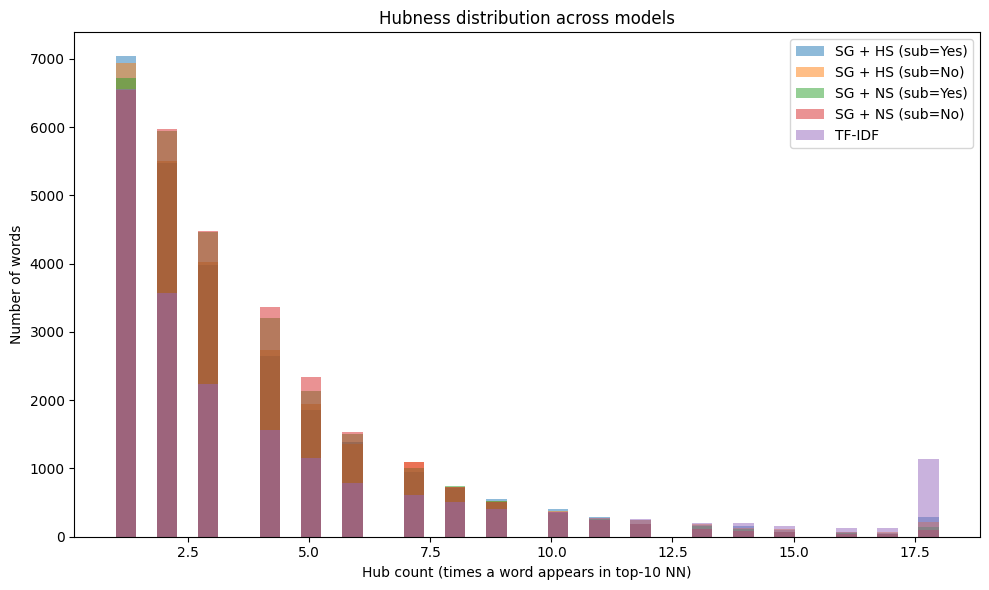

In [51]:
EMBED_DIM = 200
N_SAMPLE = 10_000   
K = 10              
RANDOM_SEED = 0

np.random.seed(RANDOM_SEED)

ARTIFACTS_HS_SUB   = Path("skipgram_hs_artifacts(10_epochs_reduced_subsampling)")
ARTIFACTS_HS_NOSUB = Path("skipgram_hs_artifacts(10_epochs_without_subsampling)")
ARTIFACTS_NS_SUB   = Path("skipgram_ns_artifacts(10_epochs_reduced_subsampling)")
ARTIFACTS_NS_NOSUB = Path("skipgram_ns_artifacts(10_epochs_no_subsampling)")
ARTIFACTS_TFIDF    = Path("tfidf_artifacts (same vocab)")


@dataclass
class ModelConfig:
    label: str    
    kind: str     
    subsampling: str
    path: Path


MODEL_CONFIGS: List[ModelConfig] = [
    ModelConfig("SG + HS (sub=Yes)", "sg_hs",  "Yes", ARTIFACTS_HS_SUB),
    ModelConfig("SG + HS (sub=No)",  "sg_hs",  "No",  ARTIFACTS_HS_NOSUB),
    ModelConfig("SG + NS (sub=Yes)", "sg_ns",  "Yes", ARTIFACTS_NS_SUB),
    ModelConfig("SG + NS (sub=No)",  "sg_ns",  "No",  ARTIFACTS_NS_NOSUB),
    ModelConfig("TF-IDF",            "tfidf",  "N/A", ARTIFACTS_TFIDF),
]

def load_sg_embeddings(cfg: ModelConfig) -> np.ndarray:
    if cfg.kind == "sg_hs":
        emb_file = cfg.path / f"skipgram_hs_embeddings_{EMBED_DIM}d.npy"
    elif cfg.kind == "sg_ns":
        emb_file = cfg.path / f"skipgram_ns_embeddings_{EMBED_DIM}d.npy"
    else:
        raise ValueError(f"Not an SG config: {cfg.kind}")

    if not emb_file.exists():
        raise FileNotFoundError(f"Missing embeddings file: {emb_file}")
    X = np.load(emb_file)
    return X 


def load_tfidf_term_embeddings(cfg: ModelConfig) -> np.ndarray:
    assert cfg.kind == "tfidf"
    tfidf_path = cfg.path / "tfidf_matrix.npz"
    if not tfidf_path.exists():
        raise FileNotFoundError(f"Missing TF-IDF matrix: {tfidf_path}")

    print("[TF-IDF] Loading sparse matrix from", tfidf_path)
    X_docs = sparse.load_npz(tfidf_path)  
    print("[TF-IDF] Shape:", X_docs.shape)
    print("[TF-IDF] Running TruncatedSVD to", EMBED_DIM, "dims (this may take a bit)...")

    svd = TruncatedSVD(n_components=EMBED_DIM, random_state=RANDOM_SEED)
    svd.fit(X_docs)
    term_embeddings = svd.components_.T  
    print("[TF-IDF] Term embedding shape:", term_embeddings.shape)
    return term_embeddings


def load_embeddings(cfg: ModelConfig) -> np.ndarray:
    if cfg.kind in ("sg_hs", "sg_ns"):
        return load_sg_embeddings(cfg)
    elif cfg.kind == "tfidf":
        return load_tfidf_term_embeddings(cfg)
    else:
        raise ValueError(f"Unknown kind: {cfg.kind}")



def l2_normalize_rows(X: np.ndarray) -> np.ndarray:
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    norms = np.maximum(norms, 1e-8)
    return X / norms


def hubness_stats(X: np.ndarray, k: int = K, n_sample: int = N_SAMPLE, name: str = ""):
    V, D = X.shape
    print(f"  Embedding shape: {V} x {D}")
    Xn = l2_normalize_rows(X)

    n_q = min(n_sample, V)
    sample_idx = np.random.choice(V, size=n_q, replace=False)
    Xq = Xn[sample_idx]        

    sims = Xq @ Xn.T          

    sims[np.arange(n_q), sample_idx] = -np.inf


    nn_idx = np.argpartition(sims, -k, axis=1)[:, -k:]  

    hub_counts = np.zeros(V, dtype=np.int32)
    np.add.at(hub_counts, nn_idx.ravel(), 1)

    nonzero = hub_counts[hub_counts > 0]
    mean_hub = float(hub_counts.mean())
    max_hub = int(hub_counts.max())
    p95 = float(np.percentile(hub_counts, 95))

    stats = {
        "name": name,
        "V": V,
        "num_queries": int(n_q),
        "unique_hubs": int((hub_counts > 0).sum()),
        "mean_hub": mean_hub,
        "max_hub": max_hub,
        "p95_hub": p95,
        "hub_counts": hub_counts,
    }
    return stats



def main():
    all_stats: List[Dict] = []

    for cfg in MODEL_CONFIGS:
        print(f"\n=== {cfg.label} ===")
        try:
            X = load_embeddings(cfg)
        except FileNotFoundError as e:
            print("  [WARN]", e)
            continue

        stats = hubness_stats(X, k=K, n_sample=N_SAMPLE, name=cfg.label)
        all_stats.append(stats)

        print(f"  Words analyzed: {stats['num_queries']}")
        print(f"  Unique hubs:    {stats['unique_hubs']}")
        print(f"  Mean hub count: {stats['mean_hub']:.2f}")
        print(f"  Max hub count:  {stats['max_hub']}")
        print(f"  95th pct hub:   {stats['p95_hub']:.1f}")

    if not all_stats:
        print("No models successfully analyzed.")
        return

    rows = []
    for s in all_stats:
        rows.append({
            "Model": s["name"],
            "Vocab_size": s["V"],
            "Queries": s["num_queries"],
            "Unique_hubs": s["unique_hubs"],
            "Mean_hub": s["mean_hub"],
            "Max_hub": s["max_hub"],
            "P95_hub": s["p95_hub"],
        })
    df = pd.DataFrame(rows)
    print("\n=== Hubness summary (k = {}, queries per model ≈ {}) ===".format(K, N_SAMPLE))
    print(df.to_string(index=False,
                       float_format=lambda x: f"{x:.2f}" if isinstance(x, float) else str(x)))

    plt.figure(figsize=(10, 6))
    max_cut = None
    for s in all_stats:
        hc = s["hub_counts"]
        hc_nonzero = hc[hc > 0]
        if max_cut is None:
            max_cut = np.percentile(hc_nonzero, 99)  
        plt.hist(
            np.clip(hc_nonzero, 0, max_cut),
            bins=40,
            alpha=0.5,
            label=s["name"]
        )

    plt.xlabel(f"Hub count (times a word appears in top-{K} NN)")
    plt.ylabel("Number of words")
    plt.title("Hubness distribution across models")
    plt.legend()
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()

Hubness analysis reveals that Skip-Gram embeddings exhibit substantially more balanced neighborhood structure compared to TF-IDF representations.
Negative Sampling produces the lowest hub dominance and the widest distribution of semantic neighbors, while subsampling further improves neighborhood fairness by suppressing high-frequency artifacts.
In contrast, TF-IDF embeddings suffer from extreme hubness, with a small number of vectors absorbing a disproportionate number of nearest-neighbor assignments.
These findings demonstrate that neural embeddings do not merely outperform in task metrics — they produce structurally healthier representation spaces.